In [2]:
import os
import sys
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from scipy import stats
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Malgun Gothic'
import matplotlib.dates as mdates

def get_hstr(path):
    hstr = pd.read_csv(path)
    hstr['datetime'] = pd.to_datetime(hstr['CLCT_UNIX_TM'], unit='s', utc=True)
    hstr['datetime'] = hstr['datetime'].dt.tz_convert('Asia/Seoul').dt.strftime('%Y-%m-%d %H:%M:%S')
    hstr['datetime'] = hstr['datetime'].astype('datetime64[ns]')
    hstr.columns = ['현장교차로ID', '수집유닉스시각', '수집일시', '제어구분코드', '제어상태코드', '주기시간', '옵셋시간',
        'A링1현시시간', 'A링2현시시간', 'A링3현시시간', 'A링4현시시간', 'A링5현시시간', 'A링6현시시간',
        'A링7현시시간', 'A링8현시시간', 'B링1현시시간', 'B링2현시시간', 'B링3현시시간', 'B링4현시시간',
        'B링5현시시간', 'B링6현시시간', 'B링7현시시간', 'B링8현시시간', 'A링1현시보행시간',
        'A링2현시보행시간', 'A링3현시보행시간', 'A링4현시보행시간', 'A링5현시보행시간', 'A링6현시보행시간',
        'A링7현시보행시간', 'A링8현시보행시간', 'B링1현시보행시간', 'B링2현시보행시간', 'B링3현시보행시간',
        'B링4현시보행시간', 'B링5현시보행시간', 'B링6현시보행시간', 'B링7현시보행시간', 'B링8현시보행시간',
        '수집날짜시각']
    cols = list(hstr.columns).copy()
    cols.remove('수집날짜시각')
    cols.insert(1, '수집날짜시각')
    hstr = hstr[cols]
    return hstr

inter_nos = list(range(5031, 5048))

In [3]:
# 성남시 신호이력 데이터
s_tod_his = pd.read_csv('seongnam/S_TOD_HIS_1702597659892.csv')

# 인천시 신호이력 데이터
'''SELECT * FROM soitdspotintsoperhstr WHERE SPOT_INTS_ID BETWEEN 5031 AND 5047'''
csv_files = [f for f in os.listdir('incheon') if f.endswith('.csv')]

dfs = []
for file in csv_files:
    df_name = file.replace('.csv', '')
    print(df_name)
    globals()[df_name] = get_hstr(f'incheon/{file}')
    dfs.append(globals()[df_name])
    print(sorted([dt for dt in globals()[df_name]['수집날짜시각'] if dt.hour != 23])[0])
    print(sorted([dt for dt in globals()[df_name]['수집날짜시각'] if dt.hour != 23])[-1])
hstr = pd.concat(dfs).drop_duplicates().sort_values(by='수집날짜시각').reset_index(drop=True)
hstr = hstr[['현장교차로ID', '수집날짜시각', '주기시간', '옵셋시간',
             'A링1현시시간', 'A링2현시시간', 'A링3현시시간', 'A링4현시시간', 'A링5현시시간', 'A링6현시시간',
             'B링1현시시간', 'B링2현시시간', 'B링3현시시간', 'B링4현시시간', 'B링5현시시간', 'B링6현시시간']]
hstr = hstr[hstr.수집날짜시각.dt.day >= 12]
print(len(hstr))
print(sorted([dt for dt in hstr['수집날짜시각'] if dt.hour != 23])[0])
print(sorted([dt for dt in hstr['수집날짜시각'] if dt.hour != 23])[-1])

soitdspotintsoperhstr_202312110921
2023-12-10 09:00:00
2023-12-11 09:21:31
soitdspotintsoperhstr_202312120814
2023-12-11 09:00:57
2023-12-12 08:14:02
soitdspotintsoperhstr_202312131102
2023-12-12 09:00:58
2023-12-13 11:02:54
soitdspotintsoperhstr_202312141254
2023-12-13 09:00:58
2023-12-14 12:53:54
soitdspotintsoperhstr_202312150926
2023-12-14 09:00:58
2023-12-15 09:26:01
soitdspotintsoperhstr_202312151700
2023-12-15 09:00:58
2023-12-15 16:59:54
32466
2023-12-12 00:00:09
2023-12-15 16:59:54


In [4]:
infos = {}
# 신호이력
infos['hstr'] = {inter_no:hstr_temp for (inter_no, hstr_temp) in hstr.groupby('현장교차로ID')}
# 현시 개수
infos['number_of_phases'] = {}
for inter_no in inter_nos:
    a_ring_columns = [col for col in infos['hstr'][inter_no].columns if 'A링' in col]
    b_ring_columns = [col for col in infos['hstr'][inter_no].columns if 'B링' in col]
    max_a_ring = max([int(col[2]) for col in a_ring_columns if infos['hstr'][inter_no][col].any() != 0])
    max_b_ring = max([int(col[2]) for col in b_ring_columns if infos['hstr'][inter_no][col].any() != 0])
    if max_a_ring == max_b_ring:
        infos['number_of_phases'][inter_no] = max_a_ring
    else:
        raise "A링, B링 현시번호 최댓값이 서로 다름"
# 현시시간 목록
infos['durations'] = {inter_no:np.unique(infos['hstr'][inter_no].iloc[:,4:].values.flatten()) for inter_no in inter_nos}

In [5]:
# TOD 계획 데이터
todplans = pd.read_csv("soitdtodplan_202312181440.csv")
todplans.columns = ["현장교차로ID", "시각계획번호", "시각운영번호", "수집유닉스시각", "수집일시", "시작시", "시작분", "현시운영번호", "현시운영계획번호"]
todplans = todplans[(todplans['수집일시'] == 20231212) & (todplans['시각계획번호'] == 1) & (todplans['시작시']!=0)]

# 전이시각, ID
infos['transition_times'] = {inter_no:todplans[todplans.현장교차로ID == inter_no][['시작시', '시작분']] for inter_no in inter_nos}
infos['ID'] = {inter_no:todplans[todplans.현장교차로ID == inter_no].현시운영계획번호.unique() for inter_no in inter_nos}

# 시간계획 데이터
timeplans = pd.read_csv("soitdtimeplan_202312180943.csv")
timeplans.columns = ["현장교차로ID", "시간계획번호", "현시운영번호", "현시운영계획번호", "수집유닉스시각", "수집일시", "주기시간", "옵셋시간",
                     "A링1현시시간", "A링2현시시간", "A링3현시시간", "A링4현시시간", "A링5현시시간", "A링6현시시간", "A링7현시시간", "A링8현시시간",
                     "B링1현시시간", "B링2현시시간", "B링3현시시간", "B링4현시시간", "B링5현시시간", "B링6현시시간", "B링7현시시간", "B링8현시시간"]
timeplans = timeplans[(timeplans.시간계획번호 == 1)]
timeplan_list = []
for inter_no in inter_nos:
    timeplan_list.append(timeplans[(timeplans.현장교차로ID==inter_no) & (timeplans.현시운영계획번호.isin(infos['ID'][inter_no]))])
timeplans = pd.concat(timeplan_list)

# 이상치로 판단하지 않는 현시시간 / 이상치로 판단하는 현시시간
infos['accepted_durations'] = {}
infos['unaccepted_durations'] = {}

# 현시시간 빈도, 옵셋
infos['unique_durations'] = {}
infos['duration_frequencies'] = {}
infos['offsets'] = {}
infos['cycles'] = {}

for inter_no in inter_nos:
    phase_times = np.unique(timeplans[timeplans.현장교차로ID == inter_no].iloc[:, 8:].values.flatten())
    accepted_phase_times = np.unique(np.concatenate([phase_times - 1, phase_times, phase_times + 1]))
    infos['accepted_durations'][inter_no] = accepted_phase_times
    unaccepted_phase_times = sorted(set(infos['durations'][inter_no]) - set(accepted_phase_times))
    infos['unaccepted_durations'][inter_no] = unaccepted_phase_times

    unique_durations, frequencies = np.unique(infos['hstr'][inter_no].iloc[:,4:].values, return_counts=True)
    sorted_indices = np.argsort(frequencies)[::-1]
    infos['unique_durations'][inter_no] = unique_durations[sorted_indices]
    infos['duration_frequencies'][inter_no] = frequencies[sorted_indices]

    infos['offsets'][inter_no] = {}
    infos['cycles'][inter_no] = {}
    for _, row in infos['transition_times'][inter_no].iterrows():
        hour = row.시작시
        minute = row.시작분
        ID = todplans[(todplans.현장교차로ID==inter_no) & (todplans.시작시==hour) & (todplans.시작분==minute)].iloc[0].현시운영계획번호
        offset = timeplans[(timeplans.현장교차로ID==inter_no)&(timeplans.현시운영계획번호==ID)].iloc[0].옵셋시간
        cycle = timeplans[(timeplans.현장교차로ID==inter_no)&(timeplans.현시운영계획번호==ID)].iloc[0].주기시간
        infos['offsets'][inter_no][(hour, minute)] = offset
        infos['cycles'][inter_no][(hour, minute)] = cycle


In [6]:
print(infos['unique_durations'][5031])
print(infos['duration_frequencies'][5031])

[ 35  27   0  20  25  49  16  37  29  33  65  31  34  58  19  28  17  44
  18  51  30  43  40  39  50  32  66  36  48  26  56  21  54  38  22  52
  41  46  42  70  72  76  59  80  67  23 126 156  90  45  69  78  71  47
 161 179]
[4186 3992 3948 1586 1392 1384 1306 1306 1170  404  394  350  322  280
  276  162  142  140  130  120   98   94   92   82   50   44   20   20
   18   16   16   16   14   14   14   10   10    8    8    8    6    4
    4    4    4    4    2    2    2    2    2    2    2    2    2    2]


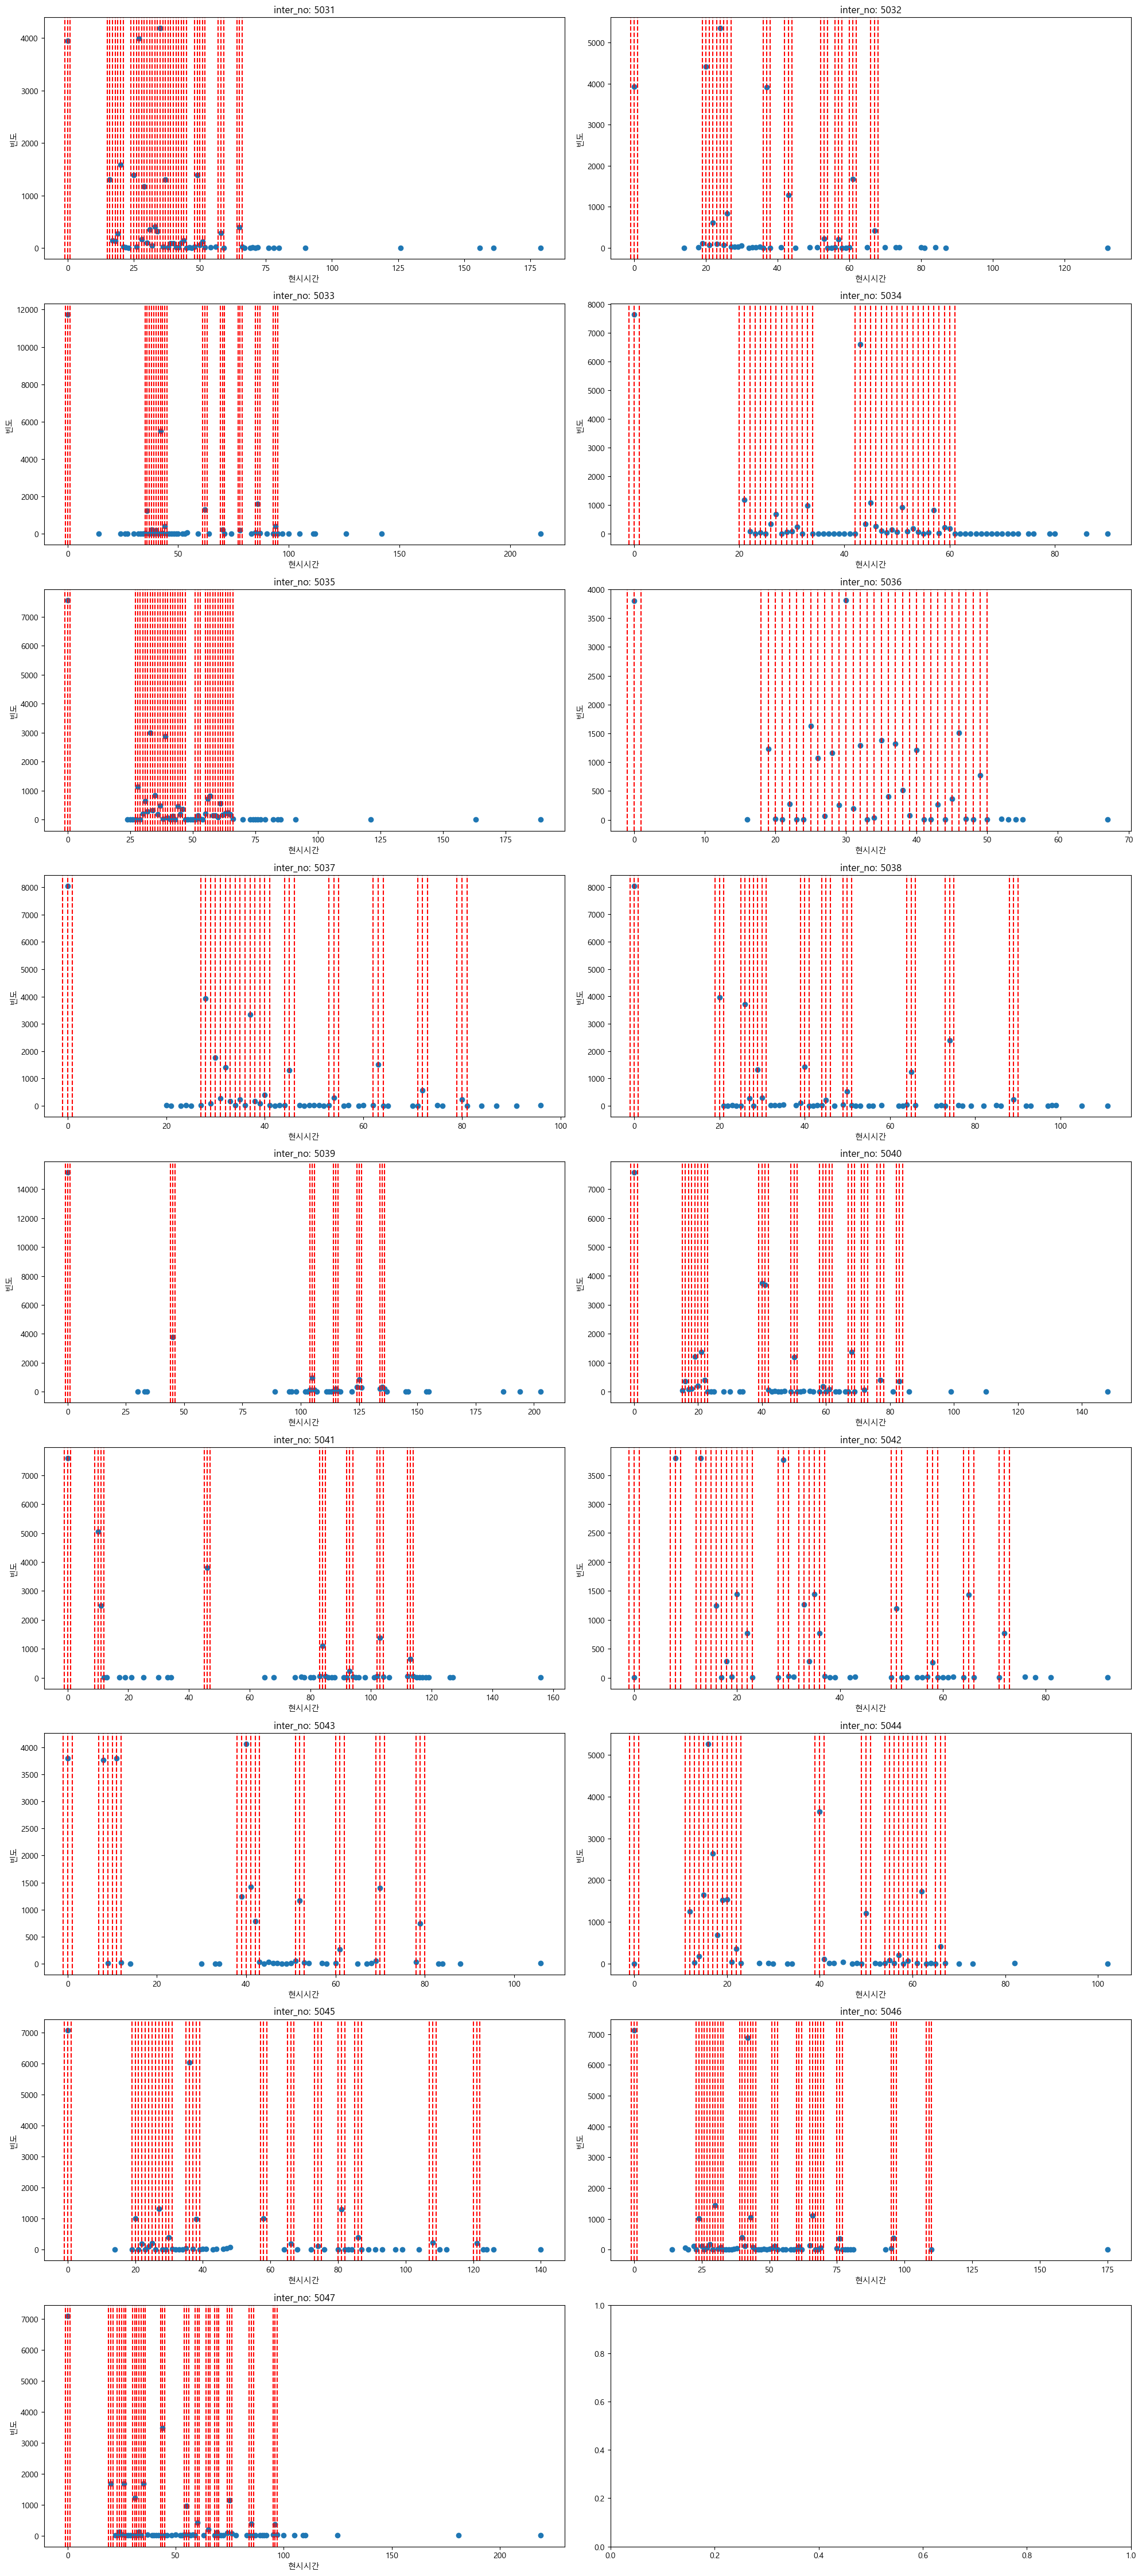

In [7]:
"""
1. 이상치 시각화 (1)

각 교차로ID별로 현시시간의 빈도를 그렸습니다.
예를 들어, 교차로ID가 5031인 경우에 대해서는 현시시간이 35인 경우가 4186번 존재했으므로 (35,4186)에 파란 점이 찍혔습니다.

그림에서 빨간 점선은 이상치가 아닌 정상 현시시간을 가지는 부분을 의미합니다.
시간계획 데이터에서 규정된 현시시간들에서 1의 오차를 허용한 값들은 이상치가 아니라고 정하고 (정상 현시시간), 1보다 큰 오차를 가진다면 이상치라고 정했습니다 (이상 현시시간).
그러니까, 아래 그림에서 빨간 점선에 해당하지 않는 파란 점들이 이상 현시시간 값들과 그 빈도를 나타냅니다.

해석 : 
정상 현시시간들은 높은 빈도를 보이는 경우가 많고, 이상 현시시간들은 낮은 (주로 2회) 빈도를 보입니다.
정상 현시시간들은 convex하지 않고 안에 구멍이 있는 경우가 있습니다.
정상 현시시간에서 많이 벗어나서 그 값이 비이상적으로 커지는 경우도 많이 보입니다.
"""
n_cols = 2
n_rows = len(inter_nos) // n_cols + 1
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 10, n_rows * 5))
for i, inter_no in enumerate(inter_nos):
    row = i // n_cols
    col = i % n_cols
    ax = axes[row, col]
    ax.scatter(infos['unique_durations'][inter_no], infos['duration_frequencies'][inter_no])
    for value in infos['accepted_durations'][inter_no]:
        ax.axvline(x=value, color='r', linestyle='--')
    ax.set_title(f'inter_no: {inter_no}')
    ax.set_xlabel('현시시간')
    ax.set_ylabel('빈도')
plt.tight_layout()
plt.show()

In [8]:
k = 2 # context number

# 이상치 dataframe, 이상치를 포함한 주변에 대한 dataframe, 정상 dataframe
infos['outlier_dfs'] = {}
infos['context_dfs'] = {}
infos['context_dfs_list'] = {}
infos['normal_dfs'] = {}
hstr_context = []
hstr_outlier = []
for inter_no in inter_nos:
    df = infos['hstr'][inter_no].sort_values(by='수집날짜시각').reset_index(drop=True)
    outliers = infos['unaccepted_durations'][inter_no]
    ring_columns = [col for col in df.columns if '현시시간' in col]
    outlier_indices = df[df[ring_columns].isin(outliers).any(axis=1)].index
    context_indices = [] # 각 아웃라이어 인덱스에 대해 위아래 네 행의 인덱스를 구합니다.
    context_indices_list = []
    for idx in outlier_indices:
        start_idx = max(idx - k, 0)  # 데이터프레임의 시작을 넘어가지 않도록 합니다.
        end_idx = min(idx + k + 1, len(df))  # 데이터프레임의 끝을 넘어가지 않도록 합니다.
        context_indices.extend(range(start_idx, end_idx))
        context_indices_list.append(list(range(start_idx, end_idx)))
    context_indices = sorted(context_indices)
    normal_indices = sorted(set(df.index) - set(outlier_indices))

    df['전이시간여부'] = False
    for _, row in infos['transition_times'][inter_no].iterrows():
        hour = row.시작시
        minute = row.시작분
        transition_range = ((df['수집날짜시각'].dt.hour==hour) & (df['수집날짜시각'].dt.minute >= minute) & (df['수집날짜시각'].dt.minute <= minute+20))
        df.loc[transition_range, '전이시간여부'] = True

    df['이상치존재'] = False
    df.loc[outlier_indices, '이상치존재'] = True

    infos['outlier_dfs'][inter_no] = df.iloc[outlier_indices].drop_duplicates()
    infos['context_dfs'][inter_no] = df.iloc[context_indices].drop_duplicates()
    infos['context_dfs_list'][inter_no] = []
    for context_indices_ in context_indices_list:
        infos['context_dfs_list'][inter_no].append(df.iloc[context_indices_])
    infos['normal_dfs'][inter_no]  = df.iloc[normal_indices]
    hstr_context.append(infos['context_dfs'][inter_no])
    hstr_outlier.append(infos['outlier_dfs'][inter_no])
hstr_context = pd.concat(hstr_context)
hstr_outlier = pd.concat(hstr_outlier)

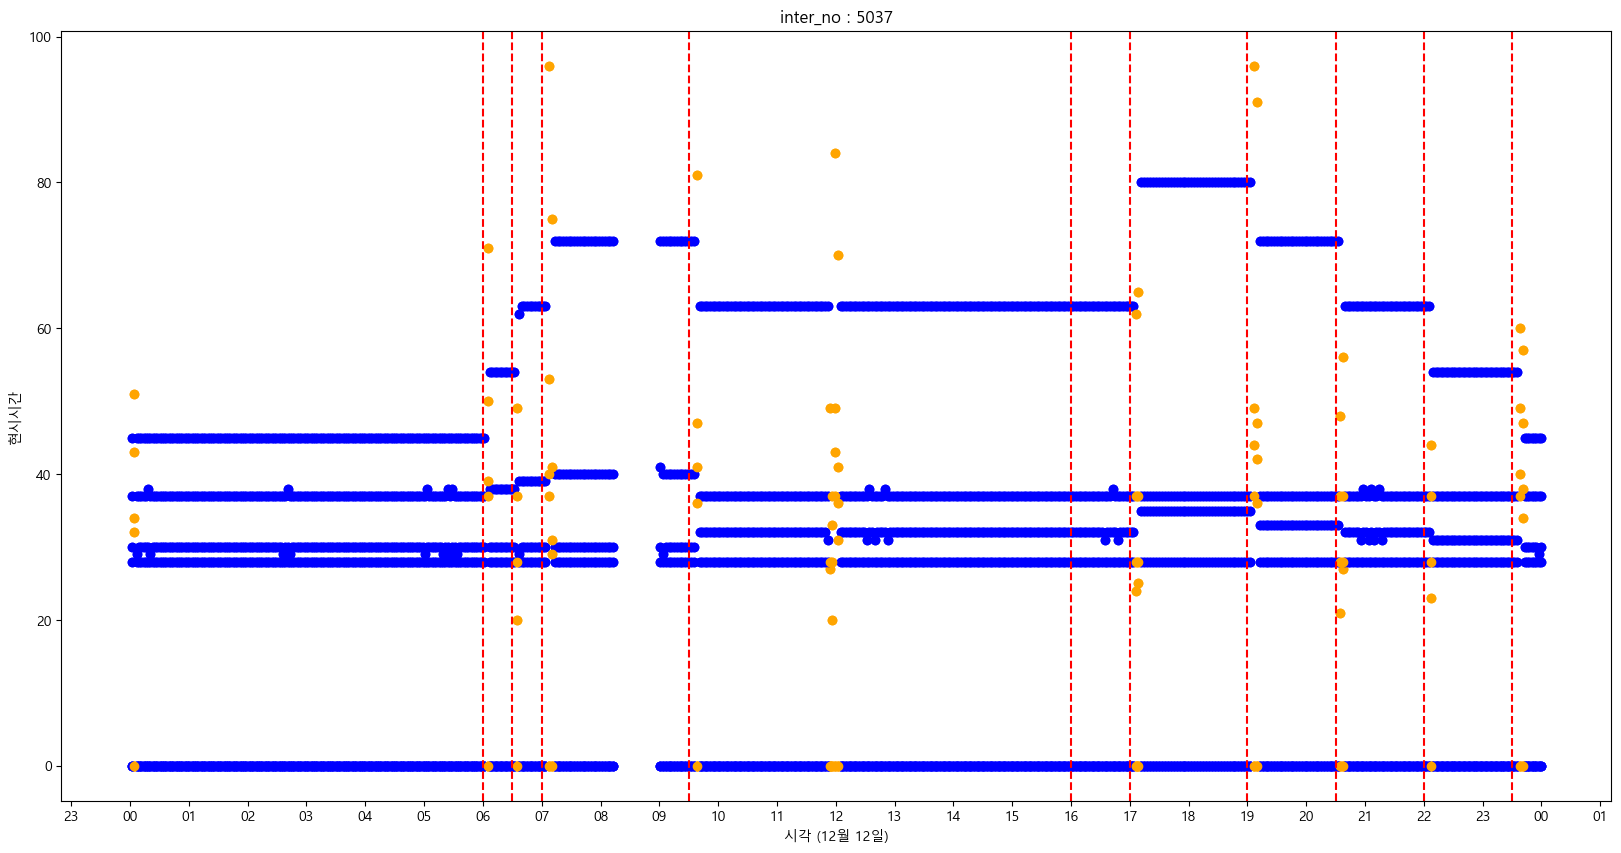

In [9]:
def plot_outliers(inter_no):
    """
    2. 이상치 시각화 (2)

    교차로ID 하나에 대하여 이상치 (이상 현시시간)가 나타나는 순간을 시각화했습니다.
    그림에서 파란 점들은 정상 현시시간이 나타나는 경우이고 노란 점들은 이상 현시시간이 나타나는 경우입니다.
    빨간 점선으로는 전이시각(현시조합이 바뀌는 순간)을 표시했습니다.
    날짜는 12월 12일로 한정지었습니다.

    해석 : (교차로ID = 5037)
    전이시각으로부터 향후 20분간을 전이시간이라고 정의하면, 대부분의 이상 현시시간은 전이시간 내에서 등장합니다.
    전이시간이 아니면서 이상 현시시간이 나타나는 경우가 12시 경에 한 번 있었습니다.
    """
    normal_df = infos['normal_dfs'][inter_no]
    normal_df = normal_df[normal_df.수집날짜시각.dt.day == 12]
    outlier_df = infos['outlier_dfs'][inter_no]
    outlier_df = outlier_df[outlier_df.수집날짜시각.dt.day == 12]
    ring_columns = [col for col in normal_df.columns if '현시시간' in col]
    plt.figure(figsize=(20,10))
    for col in ring_columns:
        plt.scatter(normal_df.수집날짜시각, normal_df[col], color='blue')
        plt.scatter(outlier_df.수집날짜시각, outlier_df[col], color='orange')
    for _, row in infos['transition_times'][inter_no].iterrows():
        start_hour = int(row.시작시)
        start_min = int(row.시작분)
        start_time = datetime(2023, 12, 12, start_hour, start_min)
        plt.axvline(x=start_time, color='r', linestyle='--')
    
    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
    ax.set_xlabel('시각 (12월 12일)')
    ax.set_ylabel('현시시간')
    ax.set_title(f'inter_no : {inter_no}')
    plt.show()
plot_outliers(5037)

In [10]:
"""
3. 이상치 관찰

이상 전이시간이 발생하는 경우를 관찰하기 위한 데이터프레임입니다.
이상치가 존재하는 순간을 포함하여 기준으로 앞의 두 순간, 뒤의 두 순간을 포함하여 총 다섯 행을 만듭니다.
이 다섯 행들을 모두 합치되 중복을 제거하여, 이상치가 발생하는 순간과, 그 전후 상황이 어떻게 나타나는지 관찰할 수 있게 합니다.

이상치가 존재하는 경우는 전이시간에 포함되는 경우, 포함되지 않는 경우로 나뉘어서 보아야 할 것이므로
"이상치존재" 열과 "전이시간여부" 행을 명시했습니다.

해석 : (교차로ID = 5037)
첫번째로 이상치가 존재하는 경우 (index = 1)는 2현시시간인 51이 이상 현시시간입니다.
이것은 여타 현시시간과 큰 값의 차이가 나는 것은 아니지만, 정상 현시시간으로 규정한 값에 포함되지 않습니다.
두번째로 이상치가 존재하는 경우 (index = 155)에도 2현시시간인 71이 이상현시시간입니다.
"""

inter_no = 5037
print(f"accepted_durations \n {infos['accepted_durations'][inter_no]}")
print(f"전이시간이 아닌데 이상치가 발생한 경우 \n {sorted(infos['outlier_dfs'][inter_no][infos['outlier_dfs'][inter_no]['전이시간여부']==False].index)}")
for (hour, minute) in infos['offsets'][inter_no]:
    print(f"{hour}:{minute}  {infos['offsets'][inter_no][(hour, minute)]}")
display(infos['context_dfs'][inter_no][:30])

accepted_durations 
 [-1  0  1 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 44 45 46 53 54 55
 62 63 64 71 72 73 79 80 81]
전이시간이 아닌데 이상치가 발생한 경우 
 [1, 267, 268, 269, 270, 537, 823, 824, 1059, 1348, 1349, 1350, 1610, 1903]
6:0  22
6:30  25
7:0  28
9:30  20
16:0  20
17:0  26
19:0  28
20:30  20
22:0  22
23:30  24


,현장교차로ID,수집날짜시각,주기시간,옵셋시간,A링1현시시간,A링2현시시간,A링3현시시간,A링4현시시간,A링5현시시간,A링6현시시간,B링1현시시간,B링2현시시간,B링3현시시간,B링4현시시간,B링5현시시간,B링6현시시간,전이시간여부,이상치존재
0,5037,2023-12-12 00:01:47,140,107,37,45,30,28,0,0,37,45,30,28,0,0,False,False
1,5037,2023-12-12 00:04:27,160,128,43,51,34,32,0,0,43,51,34,32,0,0,False,True
2,5037,2023-12-12 00:06:47,139,127,37,45,29,28,0,0,37,45,29,28,0,0,False,False
3,5037,2023-12-12 00:09:06,140,127,37,45,30,28,0,0,37,45,30,28,0,0,False,False
153,5037,2023-12-12 05:59:06,140,127,37,45,30,28,0,0,37,45,30,28,0,0,False,False
154,5037,2023-12-12 06:01:26,140,87,37,45,30,28,0,0,37,45,30,28,0,0,True,False
155,5037,2023-12-12 06:04:43,197,134,50,71,39,37,0,0,50,71,39,37,0,0,True,True
156,5037,2023-12-12 06:07:13,150,134,38,54,30,28,0,0,38,54,30,28,0,0,True,False
157,5037,2023-12-12 06:09:43,150,134,38,54,30,28,0,0,38,54,30,28,0,0,True,False
165,5037,2023-12-12 06:29:43,150,134,38,54,30,28,0,0,38,54,30,28,0,0,False,False


In [11]:
print([dt for dt in hstr.수집날짜시각 if dt.hour!=23][0])
print([dt for dt in hstr.수집날짜시각 if dt.hour!=23][-1])

2023-12-12 00:00:09
2023-12-15 16:59:54


In [12]:
"""
4. 이상 현시시간 비율 및 전이시간과의 관계
"""

n_outlier = 0
n_outlier_oustide_transition_ranges = 0
for inter_no in inter_nos:
    df = infos['outlier_dfs'][inter_no]
    n_outlier += len(df)
    n_outlier_oustide_transition_ranges += len(df[(df['전이시간여부'] == False) & (df['이상치존재'] == True)])
print(f"전체 현시시간 개수 : {len(hstr)}")
print(f"이상 현시시간 개수 : {n_outlier}")
print(f"전이시간 바깥의 이상 현시시간 개수 : {n_outlier_oustide_transition_ranges}")
print(f"이상 현시시간 비율 : {n_outlier / len(hstr) * 100} %")
print(f"이상 현시시간일 때, 그 이상치가 전이시간 바깥에서 존재하는 비율 : {n_outlier_oustide_transition_ranges / n_outlier * 100} %")

전체 현시시간 개수 : 32466
이상 현시시간 개수 : 940
전이시간 바깥의 이상 현시시간 개수 : 255
이상 현시시간 비율 : 2.895336659890347 %
이상 현시시간일 때, 그 이상치가 전이시간 바깥에서 존재하는 비율 : 27.127659574468083 %


In [13]:
"""
5. 전이시간 바깥에서 발생하는 이상현시시간 관찰

이상치존재가 True이고 전이시간여부가 False인 경우에 대하여 앞의 두 번 뒤의 두 번을 포함해 관찰합니다.
"""

infos['context_dfs_outside_the_transition_ranges'] = {}
infos['outlier_lists'] = {}
infos['outliers'] = []
for inter_no in inter_nos:
    dfs = infos['context_dfs_list'][inter_no]
    dfs = [dfs[i] for i in range(len(dfs)) if ~dfs[i].iloc[2]['전이시간여부']]
    infos['context_dfs_outside_the_transition_ranges'][inter_no] = pd.concat(dfs).drop_duplicates()

    df = infos['outlier_dfs'][inter_no].iloc[:,4:-2]
    is_outlier = df.isin(infos['unaccepted_durations'][inter_no])
    temp = df[is_outlier].values.flatten()
    temp = np.unique(temp[pd.notna(temp)])
    infos['outlier_lists'][inter_no] = np.unique(temp[pd.notna(temp)])
    infos['outliers'].extend(infos['outlier_lists'][inter_no])
infos['context_dfs_outside_the_transition_ranges'][5031]

,현장교차로ID,수집날짜시각,주기시간,옵셋시간,A링1현시시간,A링2현시시간,A링3현시시간,A링4현시시간,A링5현시시간,A링6현시시간,B링1현시시간,B링2현시시간,B링3현시시간,B링4현시시간,B링5현시시간,B링6현시시간,전이시간여부,이상치존재
776,5031,2023-12-13 10:31:40,160,140,49,20,27,29,35,0,49,20,27,29,35,0,False,False
777,5031,2023-12-13 10:34:20,160,140,49,20,27,29,35,0,49,20,27,29,35,0,False,False
778,5031,2023-12-13 10:39:07,31,107,49,20,27,156,35,0,49,20,27,156,35,0,False,True
779,5031,2023-12-13 10:41:27,140,87,37,16,27,25,35,0,37,16,27,25,35,0,False,False
780,5031,2023-12-13 10:45:00,213,140,69,31,31,43,39,0,69,31,31,43,39,0,False,True
781,5031,2023-12-13 10:47:40,160,140,49,20,27,29,35,0,49,20,27,29,35,0,False,False
782,5031,2023-12-13 10:50:20,160,140,49,20,27,29,35,0,49,20,27,29,35,0,False,False
910,5031,2023-12-13 18:02:38,180,159,65,20,27,33,35,0,65,20,27,33,35,0,False,False
911,5031,2023-12-13 18:05:38,180,159,65,20,27,33,35,0,65,20,27,33,35,0,False,False
912,5031,2023-12-13 18:10:47,52,107,65,20,27,161,35,0,65,20,27,161,35,0,False,True


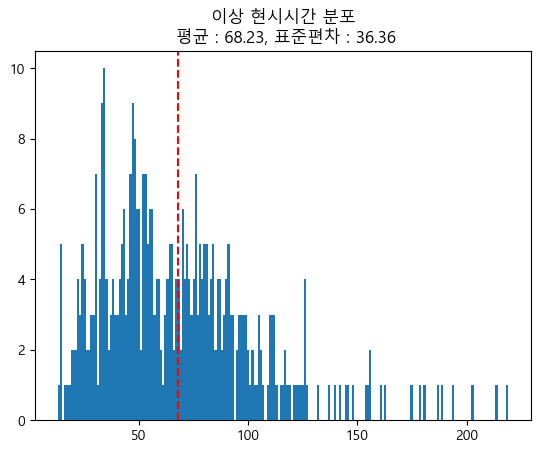

임계값 = 75초 -> 소실비율 = 36.93 %
임계값 = 90초 -> 소실비율 = 21.86 %
임계값 = 120초 -> 소실비율 = 8.04 %
임계값 = 180초 -> 소실비율 = 1.76 %
임계값 = 240초 -> 소실비율 = 0.00 %


In [14]:
"""
6. 이상 현시시간 분포

이상 현시시간은 그림에서 나오는 것과 같은 분포를 가집니다.
정규분포는 아니고 카이제곱분포처럼 생겼습니다.

신호이력을 수집하는 시간간격(threshold, 임계값)을 바꿔가면서 얼마만큼의 비율의 이상 현시시간이 소실되는지를 관찰했습니다.
임계값이 4분이면 아무런 소실이 없습니다.
그밖에 임계값을 2분 혹은 3분으로 하면서 8.04 %, 1.76 % 의 소실비율을 용인하는 것도 가능합니다.
"""
outliers = np.array(infos['outliers'])
Unique_values, Frequency = np.unique(outliers, return_counts=True)
mean = "{:.2f}".format(outliers.mean())
std  = "{:.2f}".format(outliers.std())
# plt.figure(figsize=(20,10))
plt.hist(outliers, bins=int(outliers.max() - outliers.min() + 1))
plt.axvline(x=float(mean), color='r', linestyle='--')
plt.title(f'이상 현시시간 분포\n 평균 : {mean}, 표준편차 : {std}')
plt.show()
plt.scatter(Unique_values, Frequency)
plt.axvline(x=float(mean), color='r', linestyle='--')
plt.title(f'이상 현시시간 분포\n 평균 : {mean}, 표준편차 : {std}')
plt.close()
thresholds = [75, 90, 120, 180, 240]
for threshold in thresholds:
    n_greater = [outlier for outlier in outliers if outlier > threshold]
    print(f"임계값 = {threshold}초 -> 소실비율 = " + "{:.2f}".format(len(n_greater)/len(outliers)*100) + " %")
    mean = "{:.2f}".format(outliers.mean())

In [15]:
# k = 2 # context number

# # 이상치 dataframe, 이상치를 포함한 주변에 대한 dataframe, 정상 dataframe
# infos['outlier_dfs'] = {}
# infos['context_dfs'] = {}
# infos['context_dfs_list'] = {}
# infos['normal_dfs'] = {}
# hstr_context = []
# hstr_outlier = []
# for inter_no in inter_nos:
#     df = infos['hstr'][inter_no].sort_values(by='수집날짜시각').reset_index(drop=True)
#     outliers = infos['unaccepted_durations'][inter_no]
#     ring_columns = [col for col in df.columns if '현시시간' in col]
#     outlier_indices = df[df[ring_columns].isin(outliers).any(axis=1)].index
#     context_indices = [] # 각 아웃라이어 인덱스에 대해 위아래 네 행의 인덱스를 구합니다.
#     context_indices_list = []
#     for idx in outlier_indices:
#         start_idx = max(idx - k, 0)  # 데이터프레임의 시작을 넘어가지 않도록 합니다.
#         end_idx = min(idx + k + 1, len(df))  # 데이터프레임의 끝을 넘어가지 않도록 합니다.
#         context_indices.extend(range(start_idx, end_idx))
#         context_indices_list.append(list(range(start_idx, end_idx)))
#     context_indices = sorted(context_indices)
#     normal_indices = sorted(set(df.index) - set(outlier_indices))

#     df['전이시간여부'] = False
#     for _, row in infos['transition_times'][inter_no].iterrows():
#         hour = row.시작시
#         minute = row.시작분
#         transition_range = ((df['수집날짜시각'].dt.hour==hour) & (df['수집날짜시각'].dt.minute >= minute) & (df['수집날짜시각'].dt.minute <= minute+20))
#         df.loc[transition_range, '전이시간여부'] = True

#     df['이상치존재'] = False
#     df.loc[outlier_indices, '이상치존재'] = True


In [16]:
k = 3 # context number
max_cycle = timeplans['주기시간'].max()
infos['missing_df'] = {}

for inter_no in inter_nos:
    df = infos['hstr'][inter_no].sort_values(by='수집날짜시각').reset_index(drop=True)
    df['시간차이'] = df['수집날짜시각'].diff().dt.total_seconds()
    df.dropna(inplace=True)
    df = df.reset_index(drop=True)
    missed_indices = df[df['시간차이'] > max_cycle + 10].index
    df['결측여부'] = False
    df.loc[missed_indices, '결측여부'] = True

    df['전이시간여부'] = False
    for _, row in infos['transition_times'][inter_no].iterrows():
        hour = row.시작시
        minute = row.시작분
        transition_range = ((df['수집날짜시각'].dt.hour==hour) & (df['수집날짜시각'].dt.minute >= minute) & (df['수집날짜시각'].dt.minute <= minute+20))
        df.loc[transition_range, '전이시간여부'] = True

    ring_columns = [col for col in df.columns if '현시시간' in col]
    df['주기일치'] = (df['주기시간'].astype(float) == df[ring_columns].sum(axis=1)/2)

    outliers = infos['unaccepted_durations'][inter_no]
    df['이상치존재'] = False
    df.loc[outlier_indices, '이상치존재'] = True

    infos['missing_df'][inter_no] = missed_indices
    context_indices = []
    for idx in missed_indices:
        start_idx = max(idx - k, 0)  # 데이터프레임의 시작을 넘어가지 않도록 합니다.
        end_idx = min(idx + k + 1, len(df))  # 데이터프레임의 끝을 넘어가지 않도록 합니다.
        context_indices.extend(range(start_idx, end_idx))
    infos['missing_df'][inter_no] = df.iloc[context_indices].drop_duplicates()
# for inter_no in inter_nos:
#     print(inter_no)
#     with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#         display(infos['missing_df'][inter_no])

In [17]:
infos['missing_dfs'] = {}
for inter_no in inter_nos:
    DF = infos['missing_df'][inter_no]
    dfs = []
    temp_indices = []

    for i in DF.index:
        if not temp_indices or i == temp_indices[-1] + 1:  # 첫 인덱스이거나 이전 인덱스와 연속적인 경우
            temp_indices.append(i)
        else:  # 연속이 끊긴 경우
            dfs.append(DF.loc[temp_indices])  # 현재까지의 임시 데이터프레임을 결과 리스트에 추가
            temp_indices = [i]  # 새로운 임시 데이터프레임 시작

    if temp_indices:
        dfs.append(DF.loc[temp_indices])
    infos['missing_dfs'][inter_no] = dfs


inter_no = 5034
j = 5
cycle = 180
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(infos['missing_dfs'][inter_no][j])
sum_of_durations = infos['missing_dfs'][inter_no][j].시간차이.sum()
print(sum_of_durations)
print(sum_of_durations % cycle)
print(infos['cycles'][inter_no])

,현장교차로ID,수집날짜시각,주기시간,옵셋시간,A링1현시시간,A링2현시시간,A링3현시시간,A링4현시시간,A링5현시시간,A링6현시시간,B링1현시시간,B링2현시시간,B링3현시시간,B링4현시시간,B링5현시시간,B링6현시시간,시간차이,결측여부,전이시간여부,주기일치,이상치존재
1201,5034,2023-12-14 08:59:38,180,158,53,33,51,43,0,0,26,60,51,43,0,0,180.0,False,False,True,False
1202,5034,2023-12-14 09:02:38,180,158,53,33,51,43,0,0,26,60,51,43,0,0,180.0,False,False,True,False
1203,5034,2023-12-14 09:05:38,180,158,53,33,51,43,0,0,26,60,51,43,0,0,180.0,False,False,True,False
1204,5034,2023-12-14 09:10:40,43,100,0,0,0,43,0,0,0,0,0,43,0,0,302.0,True,False,True,False
1205,5034,2023-12-14 09:13:09,150,69,43,21,43,43,0,0,21,43,43,43,0,0,149.0,False,False,True,False
1206,5034,2023-12-14 09:17:08,239,128,70,44,68,57,0,0,34,80,68,57,0,0,239.0,True,False,True,False
1207,5034,2023-12-14 09:20:38,210,158,62,38,60,50,0,0,30,70,60,50,0,0,210.0,False,False,True,False
1208,5034,2023-12-14 09:23:38,180,159,53,33,51,43,0,0,26,60,51,43,0,0,180.0,False,False,True,False
1209,5034,2023-12-14 09:26:37,179,157,53,33,50,43,0,0,26,60,50,43,0,0,179.0,False,False,True,False


1799.0
179.0
{(5, 30): 160, (6, 30): 170, (7, 0): 180, (9, 30): 170, (17, 0): 180, (21, 0): 170, (22, 0): 160, (23, 30): 150}


In [19]:
for inter_no in inter_nos:
    for j in range(len(infos['missing_dfs'][inter_no])):
        cycle = 180
        with pd.option_context('display.max_rows', None, 'display.max_columns', None):
            display(infos['missing_dfs'][inter_no][j])
        sum_of_durations = infos['missing_dfs'][inter_no][j].시간차이.sum()
        print(sum_of_durations)
        print(sum_of_durations % cycle)
        print(infos['cycles'][inter_no])

,현장교차로ID,수집날짜시각,주기시간,옵셋시간,A링1현시시간,A링2현시시간,A링3현시시간,A링4현시시간,A링5현시시간,A링6현시시간,B링1현시시간,B링2현시시간,B링3현시시간,B링4현시시간,B링5현시시간,B링6현시시간,시간차이,결측여부,전이시간여부,주기일치,이상치존재
175,5031,2023-12-12 06:58:32,160,152,43,25,27,30,35,0,43,25,27,30,35,0,160.0,False,False,True,False
176,5031,2023-12-12 07:01:12,160,152,43,25,27,30,35,0,43,25,27,30,35,0,160.0,False,True,True,False
177,5031,2023-12-12 07:03:52,160,52,43,25,27,30,35,0,43,25,27,30,35,0,160.0,False,True,True,False
178,5031,2023-12-12 07:07:51,239,111,70,51,31,48,39,0,70,51,31,48,39,0,239.0,True,True,True,False
179,5031,2023-12-12 07:11:41,230,161,66,48,31,46,39,0,66,48,31,46,39,0,230.0,False,True,True,False
180,5031,2023-12-12 07:14:41,180,162,49,35,27,34,35,0,49,35,27,34,35,0,180.0,False,True,True,False
181,5031,2023-12-12 07:17:40,179,161,49,35,27,33,35,0,49,35,27,33,35,0,179.0,False,True,True,False


1308.0
48.0
{(6, 0): 150, (6, 30): 160, (7, 0): 180, (9, 30): 160, (16, 0): 170, (17, 0): 180, (20, 30): 170, (21, 30): 160, (22, 30): 150, (23, 30): 140}


,현장교차로ID,수집날짜시각,주기시간,옵셋시간,A링1현시시간,A링2현시시간,A링3현시시간,A링4현시시간,A링5현시시간,A링6현시시간,B링1현시시간,B링2현시시간,B링3현시시간,B링4현시시간,B링5현시시간,B링6현시시간,시간차이,결측여부,전이시간여부,주기일치,이상치존재
197,5031,2023-12-12 08:05:40,180,161,49,35,27,34,35,0,49,35,27,34,35,0,180.0,False,False,True,False
198,5031,2023-12-12 08:08:41,180,161,49,35,27,34,35,0,49,35,27,34,35,0,181.0,False,False,True,False
199,5031,2023-12-12 08:11:41,180,161,49,35,27,34,35,0,49,35,27,34,35,0,180.0,False,False,True,False
200,5031,2023-12-12 09:02:41,180,161,49,35,27,34,35,0,49,35,27,34,35,0,3060.0,True,False,True,False
201,5031,2023-12-12 09:05:41,180,161,49,35,27,34,35,0,49,35,27,34,35,0,180.0,False,False,True,False
202,5031,2023-12-12 09:08:41,180,161,49,35,27,34,35,0,49,35,27,34,35,0,180.0,False,False,True,False
203,5031,2023-12-12 09:11:41,180,161,49,35,27,34,35,0,49,35,27,34,35,0,180.0,False,False,True,False


4141.0
1.0
{(6, 0): 150, (6, 30): 160, (7, 0): 180, (9, 30): 160, (16, 0): 170, (17, 0): 180, (20, 30): 170, (21, 30): 160, (22, 30): 150, (23, 30): 140}


,현장교차로ID,수집날짜시각,주기시간,옵셋시간,A링1현시시간,A링2현시시간,A링3현시시간,A링4현시시간,A링5현시시간,A링6현시시간,B링1현시시간,B링2현시시간,B링3현시시간,B링4현시시간,B링5현시시간,B링6현시시간,시간차이,결측여부,전이시간여부,주기일치,이상치존재
702,5031,2023-12-13 06:58:32,160,152,43,25,27,30,35,0,43,25,27,30,35,0,160.0,False,False,True,False
703,5031,2023-12-13 07:01:12,160,152,43,25,27,30,35,0,43,25,27,30,35,0,160.0,False,True,True,False
704,5031,2023-12-13 07:03:52,160,52,43,25,27,30,35,0,43,25,27,30,35,0,160.0,False,True,True,False
705,5031,2023-12-13 07:07:51,239,111,70,51,31,48,39,0,70,51,31,48,39,0,239.0,True,True,True,False
706,5031,2023-12-13 07:11:41,230,161,66,48,31,46,39,0,66,48,31,46,39,0,230.0,False,True,True,False
707,5031,2023-12-13 07:14:41,180,161,49,35,27,34,35,0,49,35,27,34,35,0,180.0,False,True,True,False
708,5031,2023-12-13 07:17:41,180,161,49,35,27,34,35,0,49,35,27,34,35,0,180.0,False,True,True,False


1309.0
49.0
{(6, 0): 150, (6, 30): 160, (7, 0): 180, (9, 30): 160, (16, 0): 170, (17, 0): 180, (20, 30): 170, (21, 30): 160, (22, 30): 150, (23, 30): 140}


,현장교차로ID,수집날짜시각,주기시간,옵셋시간,A링1현시시간,A링2현시시간,A링3현시시간,A링4현시시간,A링5현시시간,A링6현시시간,B링1현시시간,B링2현시시간,B링3현시시간,B링4현시시간,B링5현시시간,B링6현시시간,시간차이,결측여부,전이시간여부,주기일치,이상치존재
774,5031,2023-12-13 10:29:00,160,140,49,20,27,29,35,0,49,20,27,29,35,0,160.0,False,False,True,False
775,5031,2023-12-13 10:31:40,160,140,49,20,27,29,35,0,49,20,27,29,35,0,160.0,False,False,True,False
776,5031,2023-12-13 10:34:20,160,140,49,20,27,29,35,0,49,20,27,29,35,0,160.0,False,False,True,False
777,5031,2023-12-13 10:39:07,31,107,49,20,27,156,35,0,49,20,27,156,35,0,287.0,True,False,False,False
778,5031,2023-12-13 10:41:27,140,87,37,16,27,25,35,0,37,16,27,25,35,0,140.0,False,False,True,False
779,5031,2023-12-13 10:45:00,213,140,69,31,31,43,39,0,69,31,31,43,39,0,213.0,False,False,True,False
780,5031,2023-12-13 10:47:40,160,140,49,20,27,29,35,0,49,20,27,29,35,0,160.0,False,False,True,False


1280.0
20.0
{(6, 0): 150, (6, 30): 160, (7, 0): 180, (9, 30): 160, (16, 0): 170, (17, 0): 180, (20, 30): 170, (21, 30): 160, (22, 30): 150, (23, 30): 140}


,현장교차로ID,수집날짜시각,주기시간,옵셋시간,A링1현시시간,A링2현시시간,A링3현시시간,A링4현시시간,A링5현시시간,A링6현시시간,B링1현시시간,B링2현시시간,B링3현시시간,B링4현시시간,B링5현시시간,B링6현시시간,시간차이,결측여부,전이시간여부,주기일치,이상치존재
865,5031,2023-12-13 14:34:20,160,140,49,20,27,29,35,0,49,20,27,29,35,0,160.0,False,False,True,False
866,5031,2023-12-13 14:37:00,160,140,49,20,27,29,35,0,49,20,27,29,35,0,160.0,False,False,True,False
867,5031,2023-12-13 14:39:40,160,140,49,20,27,29,35,0,49,20,27,29,35,0,160.0,False,False,True,False
868,5031,2023-12-13 15:59:40,160,140,49,20,27,29,35,0,49,20,27,29,35,0,4800.0,True,False,True,False
869,5031,2023-12-13 16:05:01,160,100,49,20,27,29,35,0,49,20,27,29,35,0,321.0,True,True,True,False
870,5031,2023-12-13 16:08:43,223,153,80,29,31,44,39,0,80,29,31,44,39,0,222.0,False,True,True,False
871,5031,2023-12-13 16:11:33,170,153,58,19,27,31,35,0,58,19,27,31,35,0,170.0,False,True,True,False
872,5031,2023-12-13 16:14:23,170,153,58,19,27,31,35,0,58,19,27,31,35,0,170.0,False,True,True,False


6163.0
43.0
{(6, 0): 150, (6, 30): 160, (7, 0): 180, (9, 30): 160, (16, 0): 170, (17, 0): 180, (20, 30): 170, (21, 30): 160, (22, 30): 150, (23, 30): 140}


,현장교차로ID,수집날짜시각,주기시간,옵셋시간,A링1현시시간,A링2현시시간,A링3현시시간,A링4현시시간,A링5현시시간,A링6현시시간,B링1현시시간,B링2현시시간,B링3현시시간,B링4현시시간,B링5현시시간,B링6현시시간,시간차이,결측여부,전이시간여부,주기일치,이상치존재
908,5031,2023-12-13 17:59:38,180,159,65,20,27,33,35,0,65,20,27,33,35,0,180.0,False,False,True,False
909,5031,2023-12-13 18:02:38,180,159,65,20,27,33,35,0,65,20,27,33,35,0,180.0,False,False,True,False
910,5031,2023-12-13 18:05:38,180,159,65,20,27,33,35,0,65,20,27,33,35,0,180.0,False,False,True,True
911,5031,2023-12-13 18:10:47,52,107,65,20,27,161,35,0,65,20,27,161,35,0,309.0,True,False,False,True
912,5031,2023-12-13 18:13:07,140,67,37,16,27,25,35,0,37,16,27,25,35,0,140.0,False,False,True,True
913,5031,2023-12-13 18:17:06,239,126,90,31,31,48,39,0,90,31,31,48,39,0,239.0,True,False,True,False
914,5031,2023-12-13 18:20:39,213,159,78,25,31,40,39,0,78,25,31,40,39,0,213.0,False,False,True,False
915,5031,2023-12-13 18:23:39,180,160,65,20,27,33,35,0,65,20,27,33,35,0,180.0,False,False,True,False
916,5031,2023-12-13 18:26:38,179,159,65,20,27,32,35,0,65,20,27,32,35,0,179.0,False,False,True,False


1800.0
0.0
{(6, 0): 150, (6, 30): 160, (7, 0): 180, (9, 30): 160, (16, 0): 170, (17, 0): 180, (20, 30): 170, (21, 30): 160, (22, 30): 150, (23, 30): 140}


,현장교차로ID,수집날짜시각,주기시간,옵셋시간,A링1현시시간,A링2현시시간,A링3현시시간,A링4현시시간,A링5현시시간,A링6현시시간,B링1현시시간,B링2현시시간,B링3현시시간,B링4현시시간,B링5현시시간,B링6현시시간,시간차이,결측여부,전이시간여부,주기일치,이상치존재
1029,5031,2023-12-13 23:43:20,140,0,37,16,27,25,35,0,37,16,27,25,35,0,140.0,False,True,True,False
1030,5031,2023-12-13 23:45:40,140,0,37,16,27,25,35,0,37,16,27,25,35,0,140.0,False,True,True,False
1031,5031,2023-12-13 23:48:00,140,0,37,16,27,25,35,0,37,16,27,25,35,0,140.0,False,True,True,False
1032,5031,2023-12-13 23:52:43,26,3,179,16,27,25,35,0,179,16,27,25,35,0,283.0,True,False,False,False
1033,5031,2023-12-13 23:55:02,140,2,37,16,27,25,35,0,37,16,27,25,35,0,139.0,False,False,True,False
1034,5031,2023-12-13 23:57:22,140,2,37,16,27,25,35,0,37,16,27,25,35,0,140.0,False,False,True,False
1035,5031,2023-12-13 23:59:43,140,2,37,16,27,25,35,0,37,16,27,25,35,0,141.0,False,False,True,False


1123.0
43.0
{(6, 0): 150, (6, 30): 160, (7, 0): 180, (9, 30): 160, (16, 0): 170, (17, 0): 180, (20, 30): 170, (21, 30): 160, (22, 30): 150, (23, 30): 140}


,현장교차로ID,수집날짜시각,주기시간,옵셋시간,A링1현시시간,A링2현시시간,A링3현시시간,A링4현시시간,A링5현시시간,A링6현시시간,B링1현시시간,B링2현시시간,B링3현시시간,B링4현시시간,B링5현시시간,B링6현시시간,시간차이,결측여부,전이시간여부,주기일치,이상치존재
1212,5031,2023-12-14 06:58:32,160,152,43,25,27,30,35,0,43,25,27,30,35,0,160.0,False,False,True,False
1213,5031,2023-12-14 07:01:12,160,152,43,25,27,30,35,0,43,25,27,30,35,0,160.0,False,True,True,False
1214,5031,2023-12-14 07:03:52,160,52,43,25,27,30,35,0,43,25,27,30,35,0,160.0,False,True,True,False
1215,5031,2023-12-14 07:07:51,239,111,70,51,31,48,39,0,70,51,31,48,39,0,239.0,True,True,True,False
1216,5031,2023-12-14 07:11:41,230,161,66,48,31,46,39,0,66,48,31,46,39,0,230.0,False,True,True,False
1217,5031,2023-12-14 07:14:41,180,161,49,35,27,34,35,0,49,35,27,34,35,0,180.0,False,True,True,False
1218,5031,2023-12-14 07:17:41,180,161,49,35,27,34,35,0,49,35,27,34,35,0,180.0,False,True,True,False


1309.0
49.0
{(6, 0): 150, (6, 30): 160, (7, 0): 180, (9, 30): 160, (16, 0): 170, (17, 0): 180, (20, 30): 170, (21, 30): 160, (22, 30): 150, (23, 30): 140}


,현장교차로ID,수집날짜시각,주기시간,옵셋시간,A링1현시시간,A링2현시시간,A링3현시시간,A링4현시시간,A링5현시시간,A링6현시시간,B링1현시시간,B링2현시시간,B링3현시시간,B링4현시시간,B링5현시시간,B링6현시시간,시간차이,결측여부,전이시간여부,주기일치,이상치존재
1755,5031,2023-12-15 06:58:31,160,152,43,25,27,30,35,0,43,25,27,30,35,0,159.0,False,False,True,False
1756,5031,2023-12-15 07:01:11,160,152,43,25,27,30,35,0,43,25,27,30,35,0,160.0,False,True,True,False
1757,5031,2023-12-15 07:03:52,160,52,43,25,27,30,35,0,43,25,27,30,35,0,161.0,False,True,True,False
1758,5031,2023-12-15 07:07:50,239,111,70,51,31,48,39,0,70,51,31,48,39,0,238.0,True,True,True,False
1759,5031,2023-12-15 07:11:40,230,161,66,48,31,46,39,0,66,48,31,46,39,0,230.0,False,True,True,False
1760,5031,2023-12-15 07:14:41,180,161,49,35,27,34,35,0,49,35,27,34,35,0,181.0,False,True,True,False
1761,5031,2023-12-15 07:17:41,180,161,49,35,27,34,35,0,49,35,27,34,35,0,180.0,False,True,True,False
1762,5031,2023-12-15 07:21:58,1,58,126,35,27,34,35,0,126,35,27,34,35,0,257.0,True,False,False,False
1763,5031,2023-12-15 07:24:18,140,19,37,16,27,25,35,0,37,16,27,25,35,0,140.0,False,False,True,False
1764,5031,2023-12-15 07:26:49,151,169,39,25,27,25,35,0,39,25,27,25,35,0,151.0,False,False,True,False


2029.0
49.0
{(6, 0): 150, (6, 30): 160, (7, 0): 180, (9, 30): 160, (16, 0): 170, (17, 0): 180, (20, 30): 170, (21, 30): 160, (22, 30): 150, (23, 30): 140}


,현장교차로ID,수집날짜시각,주기시간,옵셋시간,A링1현시시간,A링2현시시간,A링3현시시간,A링4현시시간,A링5현시시간,A링6현시시간,B링1현시시간,B링2현시시간,B링3현시시간,B링4현시시간,B링5현시시간,B링6현시시간,시간차이,결측여부,전이시간여부,주기일치,이상치존재
200,5032,2023-12-12 08:08:15,170,55,24,61,24,37,24,0,24,61,24,37,24,0,170.0,False,False,True,False
201,5032,2023-12-12 08:11:05,170,55,24,61,24,37,24,0,24,61,24,37,24,0,170.0,False,False,True,False
202,5032,2023-12-12 08:13:55,170,55,24,61,24,37,24,0,24,61,24,37,24,0,170.0,False,False,True,False
203,5032,2023-12-12 09:02:04,169,55,24,61,24,37,23,0,24,61,24,37,23,0,2889.0,True,False,True,False
204,5032,2023-12-12 09:04:54,170,55,24,61,24,37,24,0,24,61,24,37,24,0,170.0,False,False,True,False
205,5032,2023-12-12 09:07:44,170,55,24,61,24,37,24,0,24,61,24,37,24,0,170.0,False,False,True,False
206,5032,2023-12-12 09:10:34,170,55,24,61,24,37,24,0,24,61,24,37,24,0,170.0,False,False,True,False


3909.0
129.0
{(6, 0): 150, (6, 30): 160, (7, 0): 170, (9, 30): 170, (16, 0): 170, (17, 0): 180, (20, 30): 170, (21, 30): 160, (22, 30): 150, (23, 30): 140}


,현장교차로ID,수집날짜시각,주기시간,옵셋시간,A링1현시시간,A링2현시시간,A링3현시시간,A링4현시시간,A링5현시시간,A링6현시시간,B링1현시시간,B링2현시시간,B링3현시시간,B링4현시시간,B링5현시시간,B링6현시시간,시간차이,결측여부,전이시간여부,주기일치,이상치존재
653,5032,2023-12-13 05:09:01,140,61,20,43,20,37,20,0,20,43,20,37,20,0,140.0,False,False,True,False
654,5032,2023-12-13 05:11:20,139,60,20,43,20,37,19,0,20,43,20,37,19,0,139.0,False,False,True,False
655,5032,2023-12-13 05:13:40,141,60,20,43,20,38,20,0,20,43,20,38,20,0,140.0,False,False,True,False
656,5032,2023-12-13 05:17:53,252,32,132,43,20,37,20,0,132,43,20,37,20,0,253.0,True,False,True,False
657,5032,2023-12-13 05:19:50,117,9,18,24,19,37,19,0,18,24,19,37,19,0,117.0,False,False,True,False
658,5032,2023-12-13 05:22:55,186,55,30,60,30,37,29,0,30,60,30,37,29,0,185.0,False,False,True,False
659,5032,2023-12-13 05:25:20,145,60,21,45,21,37,21,0,21,45,21,37,21,0,145.0,False,False,True,False


1119.0
39.0
{(6, 0): 150, (6, 30): 160, (7, 0): 170, (9, 30): 170, (16, 0): 170, (17, 0): 180, (20, 30): 170, (21, 30): 160, (22, 30): 150, (23, 30): 140}


,현장교차로ID,수집날짜시각,주기시간,옵셋시간,A링1현시시간,A링2현시시간,A링3현시시간,A링4현시시간,A링5현시시간,A링6현시시간,B링1현시시간,B링2현시시간,B링3현시시간,B링4현시시간,B링5현시시간,B링6현시시간,시간차이,결측여부,전이시간여부,주기일치,이상치존재
857,5032,2023-12-13 14:33:36,170,55,24,61,24,37,24,0,24,61,24,37,24,0,170.0,False,False,True,False
858,5032,2023-12-13 14:36:26,170,56,24,61,24,37,24,0,24,61,24,37,24,0,170.0,False,False,True,False
859,5032,2023-12-13 14:39:15,169,54,24,61,24,37,23,0,24,61,24,37,23,0,169.0,False,False,True,False
860,5032,2023-12-13 16:04:15,170,55,24,61,24,37,24,0,24,61,24,37,24,0,5100.0,True,True,True,False
861,5032,2023-12-13 16:07:05,170,55,24,61,24,37,24,0,24,61,24,37,24,0,170.0,False,True,True,False
862,5032,2023-12-13 16:09:55,170,55,24,61,24,37,24,0,24,61,24,37,24,0,170.0,False,True,True,True
863,5032,2023-12-13 16:12:45,170,55,24,61,24,37,24,0,24,61,24,37,24,0,170.0,False,True,True,True


6119.0
179.0
{(6, 0): 150, (6, 30): 160, (7, 0): 170, (9, 30): 170, (16, 0): 170, (17, 0): 180, (20, 30): 170, (21, 30): 160, (22, 30): 150, (23, 30): 140}


,현장교차로ID,수집날짜시각,주기시간,옵셋시간,A링1현시시간,A링2현시시간,A링3현시시간,A링4현시시간,A링5현시시간,A링6현시시간,B링1현시시간,B링2현시시간,B링3현시시간,B링4현시시간,B링5현시시간,B링6현시시간,시간차이,결측여부,전이시간여부,주기일치,이상치존재
1954,5032,2023-12-15 16:52:24,170,55,24,61,24,37,24,0,24,61,24,37,24,0,170.0,False,False,True,False
1955,5032,2023-12-15 16:55:14,170,55,24,61,24,37,24,0,24,61,24,37,24,0,170.0,False,False,True,False
1956,5032,2023-12-15 16:58:04,170,55,24,61,24,37,24,0,24,61,24,37,24,0,170.0,False,False,True,False
1957,5032,2023-12-15 23:59:30,130,51,36,14,27,27,26,0,36,14,27,27,26,0,25286.0,True,False,True,False


25796.0
56.0
{(6, 0): 150, (6, 30): 160, (7, 0): 170, (9, 30): 170, (16, 0): 170, (17, 0): 180, (20, 30): 170, (21, 30): 160, (22, 30): 150, (23, 30): 140}


,현장교차로ID,수집날짜시각,주기시간,옵셋시간,A링1현시시간,A링2현시시간,A링3현시시간,A링4현시시간,A링5현시시간,A링6현시시간,B링1현시시간,B링2현시시간,B링3현시시간,B링4현시시간,B링5현시시간,B링6현시시간,시간차이,결측여부,전이시간여부,주기일치,이상치존재
200,5033,2023-12-12 08:07:51,170,32,42,86,42,0,0,0,42,86,42,0,0,0,170.0,False,False,True,False
201,5033,2023-12-12 08:10:41,170,32,42,86,42,0,0,0,42,86,42,0,0,0,170.0,False,False,True,False
202,5033,2023-12-12 08:13:32,170,32,42,86,42,0,0,0,42,86,42,0,0,0,171.0,False,False,True,False
203,5033,2023-12-12 09:01:42,170,32,42,86,42,0,0,0,42,86,42,0,0,0,2890.0,True,False,True,False
204,5033,2023-12-12 09:04:32,170,32,42,86,42,0,0,0,42,86,42,0,0,0,170.0,False,False,True,False
205,5033,2023-12-12 09:07:22,170,32,42,86,42,0,0,0,42,86,42,0,0,0,170.0,False,False,True,False
206,5033,2023-12-12 09:10:12,170,32,42,86,42,0,0,0,42,86,42,0,0,0,170.0,False,False,True,False


3911.0
131.0
{(6, 0): 150, (6, 30): 160, (7, 0): 170, (9, 30): 170, (16, 0): 170, (17, 0): 180, (20, 30): 170, (21, 30): 160, (22, 30): 150, (23, 30): 140}


,현장교차로ID,수집날짜시각,주기시간,옵셋시간,A링1현시시간,A링2현시시간,A링3현시시간,A링4현시시간,A링5현시시간,A링6현시시간,B링1현시시간,B링2현시시간,B링3현시시간,B링4현시시간,B링5현시시간,B링6현시시간,시간차이,결측여부,전이시간여부,주기일치,이상치존재
858,5033,2023-12-13 14:33:28,170,48,42,86,42,0,0,0,42,86,42,0,0,0,170.0,False,False,True,False
859,5033,2023-12-13 14:36:18,170,48,42,86,42,0,0,0,42,86,42,0,0,0,170.0,False,False,True,False
860,5033,2023-12-13 14:39:08,170,48,42,86,42,0,0,0,42,86,42,0,0,0,170.0,False,False,True,False
861,5033,2023-12-13 16:04:09,170,48,42,86,42,0,0,0,42,86,42,0,0,0,5101.0,True,True,True,False
862,5033,2023-12-13 16:06:59,170,48,42,86,42,0,0,0,42,86,42,0,0,0,170.0,False,True,True,True
863,5033,2023-12-13 16:09:49,170,49,42,86,42,0,0,0,42,86,42,0,0,0,170.0,False,True,True,True
864,5033,2023-12-13 16:12:38,169,47,42,85,42,0,0,0,42,85,42,0,0,0,169.0,False,True,True,False


6120.0
0.0
{(6, 0): 150, (6, 30): 160, (7, 0): 170, (9, 30): 170, (16, 0): 170, (17, 0): 180, (20, 30): 170, (21, 30): 160, (22, 30): 150, (23, 30): 140}


,현장교차로ID,수집날짜시각,주기시간,옵셋시간,A링1현시시간,A링2현시시간,A링3현시시간,A링4현시시간,A링5현시시간,A링6현시시간,B링1현시시간,B링2현시시간,B링3현시시간,B링4현시시간,B링5현시시간,B링6현시시간,시간차이,결측여부,전이시간여부,주기일치,이상치존재
891,5033,2023-12-13 17:30:43,180,44,42,94,44,0,0,0,42,94,44,0,0,0,180.0,False,False,True,False
892,5033,2023-12-13 17:33:43,180,44,42,94,44,0,0,0,42,94,44,0,0,0,180.0,False,False,True,False
893,5033,2023-12-13 17:36:43,180,44,42,94,44,0,0,0,42,94,44,0,0,0,180.0,False,False,True,False
894,5033,2023-12-13 17:42:34,94,34,42,94,214,0,0,0,42,94,214,0,0,0,351.0,True,False,False,False
895,5033,2023-12-13 17:44:33,119,153,42,53,24,0,0,0,42,53,24,0,0,0,119.0,False,False,True,False
896,5033,2023-12-13 17:48:32,239,32,54,126,59,0,0,0,54,126,59,0,0,0,239.0,True,False,True,False
897,5033,2023-12-13 17:51:44,192,44,45,100,47,0,0,0,45,100,47,0,0,0,192.0,False,False,True,False
898,5033,2023-12-13 17:54:44,180,44,42,94,44,0,0,0,42,94,44,0,0,0,180.0,False,False,True,False
899,5033,2023-12-13 17:57:44,180,44,42,94,44,0,0,0,42,94,44,0,0,0,180.0,False,False,True,False


1801.0
1.0
{(6, 0): 150, (6, 30): 160, (7, 0): 170, (9, 30): 170, (16, 0): 170, (17, 0): 180, (20, 30): 170, (21, 30): 160, (22, 30): 150, (23, 30): 140}


,현장교차로ID,수집날짜시각,주기시간,옵셋시간,A링1현시시간,A링2현시시간,A링3현시시간,A링4현시시간,A링5현시시간,A링6현시시간,B링1현시시간,B링2현시시간,B링3현시시간,B링4현시시간,B링5현시시간,B링6현시시간,시간차이,결측여부,전이시간여부,주기일치,이상치존재
1953,5033,2023-12-15 16:52:18,170,48,42,86,42,0,0,0,42,86,42,0,0,0,170.0,False,False,True,False
1954,5033,2023-12-15 16:55:08,170,48,42,86,42,0,0,0,42,86,42,0,0,0,170.0,False,False,True,False
1955,5033,2023-12-15 16:57:58,170,48,42,86,42,0,0,0,42,86,42,0,0,0,170.0,False,False,True,False
1956,5033,2023-12-15 23:59:30,130,51,36,14,27,27,26,0,36,14,27,27,26,0,25292.0,True,False,True,False


25802.0
62.0
{(6, 0): 150, (6, 30): 160, (7, 0): 170, (9, 30): 170, (16, 0): 170, (17, 0): 180, (20, 30): 170, (21, 30): 160, (22, 30): 150, (23, 30): 140}


,현장교차로ID,수집날짜시각,주기시간,옵셋시간,A링1현시시간,A링2현시시간,A링3현시시간,A링4현시시간,A링5현시시간,A링6현시시간,B링1현시시간,B링2현시시간,B링3현시시간,B링4현시시간,B링5현시시간,B링6현시시간,시간차이,결측여부,전이시간여부,주기일치,이상치존재
186,5034,2023-12-12 08:05:37,180,158,53,33,51,43,0,0,26,60,51,43,0,0,180.0,False,False,True,False
187,5034,2023-12-12 08:08:37,180,157,53,33,51,43,0,0,26,60,51,43,0,0,180.0,False,False,True,False
188,5034,2023-12-12 08:11:38,181,159,53,33,52,43,0,0,26,60,52,43,0,0,181.0,False,False,True,False
189,5034,2023-12-12 09:02:37,180,158,53,33,51,43,0,0,26,60,51,43,0,0,3059.0,True,False,True,False
190,5034,2023-12-12 09:05:37,180,158,53,33,51,43,0,0,26,60,51,43,0,0,180.0,False,False,True,False
191,5034,2023-12-12 09:08:38,180,158,53,33,51,43,0,0,26,60,51,43,0,0,181.0,False,False,True,False
192,5034,2023-12-12 09:11:38,180,158,53,33,51,43,0,0,26,60,51,43,0,0,180.0,False,False,True,False


4141.0
1.0
{(5, 30): 160, (6, 30): 170, (7, 0): 180, (9, 30): 170, (17, 0): 180, (21, 0): 170, (22, 0): 160, (23, 30): 150}


,현장교차로ID,수집날짜시각,주기시간,옵셋시간,A링1현시시간,A링2현시시간,A링3현시시간,A링4현시시간,A링5현시시간,A링6현시시간,B링1현시시간,B링2현시시간,B링3현시시간,B링4현시시간,B링5현시시간,B링6현시시간,시간차이,결측여부,전이시간여부,주기일치,이상치존재
384,5034,2023-12-12 18:19:05,57,65,57,0,0,0,0,0,31,0,0,0,0,0,88.0,False,False,False,False
385,5034,2023-12-12 18:22:05,180,65,57,33,45,45,0,0,31,59,45,45,0,0,180.0,False,False,True,False
386,5034,2023-12-12 18:24:35,150,35,43,21,43,43,0,0,21,43,43,43,0,0,150.0,False,False,True,False
387,5034,2023-12-12 18:28:35,240,95,76,44,60,60,0,0,41,79,60,60,0,0,240.0,True,False,True,False
388,5034,2023-12-12 18:32:35,240,155,76,44,60,60,0,0,41,79,60,60,0,0,240.0,True,False,True,False
389,5034,2023-12-12 18:35:39,184,159,58,34,46,46,0,0,32,60,46,46,0,0,184.0,False,False,True,False
390,5034,2023-12-12 18:38:39,180,159,57,33,45,45,0,0,31,59,45,45,0,0,180.0,False,False,True,False
391,5034,2023-12-12 18:41:39,180,159,57,33,45,45,0,0,31,59,45,45,0,0,180.0,False,False,True,False


1442.0
2.0
{(5, 30): 160, (6, 30): 170, (7, 0): 180, (9, 30): 170, (17, 0): 180, (21, 0): 170, (22, 0): 160, (23, 30): 150}


,현장교차로ID,수집날짜시각,주기시간,옵셋시간,A링1현시시간,A링2현시시간,A링3현시시간,A링4현시시간,A링5현시시간,A링6현시시간,B링1현시시간,B링2현시시간,B링3현시시간,B링4현시시간,B링5현시시간,B링6현시시간,시간차이,결측여부,전이시간여부,주기일치,이상치존재
705,5034,2023-12-13 08:47:40,180,160,53,33,51,43,0,0,26,60,51,43,0,0,180.0,False,False,True,False
706,5034,2023-12-13 08:50:40,180,160,53,33,51,43,0,0,26,60,51,43,0,0,180.0,False,False,True,False
707,5034,2023-12-13 08:53:40,180,160,53,33,51,43,0,0,26,60,51,43,0,0,180.0,False,False,True,False
708,5034,2023-12-13 08:59:12,46,132,0,0,0,46,0,0,0,0,0,46,0,0,332.0,True,False,True,False
709,5034,2023-12-13 09:02:40,208,160,61,39,59,49,0,0,30,70,59,49,0,0,208.0,False,False,True,False
710,5034,2023-12-13 09:05:40,180,160,53,33,51,43,0,0,26,60,51,43,0,0,180.0,False,False,True,False
711,5034,2023-12-13 09:08:40,180,160,53,33,51,43,0,0,26,60,51,43,0,0,180.0,False,False,True,False


1440.0
0.0
{(5, 30): 160, (6, 30): 170, (7, 0): 180, (9, 30): 170, (17, 0): 180, (21, 0): 170, (22, 0): 160, (23, 30): 150}


,현장교차로ID,수집날짜시각,주기시간,옵셋시간,A링1현시시간,A링2현시시간,A링3현시시간,A링4현시시간,A링5현시시간,A링6현시시간,B링1현시시간,B링2현시시간,B링3현시시간,B링4현시시간,B링5현시시간,B링6현시시간,시간차이,결측여부,전이시간여부,주기일치,이상치존재
825,5034,2023-12-13 14:32:27,170,157,51,33,43,43,0,0,27,57,43,43,0,0,170.0,False,False,True,False
826,5034,2023-12-13 14:35:17,170,157,51,33,43,43,0,0,27,57,43,43,0,0,170.0,False,False,True,False
827,5034,2023-12-13 14:38:07,170,157,51,33,43,43,0,0,27,57,43,43,0,0,170.0,False,False,True,False
828,5034,2023-12-13 16:00:18,170,157,51,33,43,43,0,0,27,57,43,43,0,0,4931.0,True,False,True,False
829,5034,2023-12-13 16:03:08,170,157,51,33,43,43,0,0,27,57,43,43,0,0,170.0,False,False,True,False
830,5034,2023-12-13 16:05:58,170,157,51,33,43,43,0,0,27,57,43,43,0,0,170.0,False,False,True,False
831,5034,2023-12-13 16:08:48,170,157,51,33,43,43,0,0,27,57,43,43,0,0,170.0,False,False,True,False


5951.0
11.0
{(5, 30): 160, (6, 30): 170, (7, 0): 180, (9, 30): 170, (17, 0): 180, (21, 0): 170, (22, 0): 160, (23, 30): 150}


,현장교차로ID,수집날짜시각,주기시간,옵셋시간,A링1현시시간,A링2현시시간,A링3현시시간,A링4현시시간,A링5현시시간,A링6현시시간,B링1현시시간,B링2현시시간,B링3현시시간,B링4현시시간,B링5현시시간,B링6현시시간,시간차이,결측여부,전이시간여부,주기일치,이상치존재
864,5034,2023-12-13 17:42:38,57,38,57,0,0,0,0,0,31,0,0,0,0,0,59.0,False,False,False,False
865,5034,2023-12-13 17:45:38,180,39,57,33,45,45,0,0,31,59,45,45,0,0,180.0,False,False,True,False
866,5034,2023-12-13 17:48:08,150,8,43,21,43,43,0,0,21,43,43,43,0,0,150.0,False,False,True,False
867,5034,2023-12-13 17:52:08,240,68,76,44,60,60,0,0,41,79,60,60,0,0,240.0,True,False,True,False
868,5034,2023-12-13 17:56:08,240,128,76,44,60,60,0,0,41,79,60,60,0,0,240.0,True,False,True,False
869,5034,2023-12-13 17:59:38,210,159,67,38,53,52,0,0,36,69,53,52,0,0,210.0,False,False,True,False
870,5034,2023-12-13 18:02:38,180,159,57,33,45,45,0,0,31,59,45,45,0,0,180.0,False,False,True,False
871,5034,2023-12-13 18:05:38,180,159,57,33,45,45,0,0,31,59,45,45,0,0,180.0,False,False,True,False


1439.0
179.0
{(5, 30): 160, (6, 30): 170, (7, 0): 180, (9, 30): 170, (17, 0): 180, (21, 0): 170, (22, 0): 160, (23, 30): 150}


,현장교차로ID,수집날짜시각,주기시간,옵셋시간,A링1현시시간,A링2현시시간,A링3현시시간,A링4현시시간,A링5현시시간,A링6현시시간,B링1현시시간,B링2현시시간,B링3현시시간,B링4현시시간,B링5현시시간,B링6현시시간,시간차이,결측여부,전이시간여부,주기일치,이상치존재
1201,5034,2023-12-14 08:59:38,180,158,53,33,51,43,0,0,26,60,51,43,0,0,180.0,False,False,True,False
1202,5034,2023-12-14 09:02:38,180,158,53,33,51,43,0,0,26,60,51,43,0,0,180.0,False,False,True,False
1203,5034,2023-12-14 09:05:38,180,158,53,33,51,43,0,0,26,60,51,43,0,0,180.0,False,False,True,False
1204,5034,2023-12-14 09:10:40,43,100,0,0,0,43,0,0,0,0,0,43,0,0,302.0,True,False,True,False
1205,5034,2023-12-14 09:13:09,150,69,43,21,43,43,0,0,21,43,43,43,0,0,149.0,False,False,True,False
1206,5034,2023-12-14 09:17:08,239,128,70,44,68,57,0,0,34,80,68,57,0,0,239.0,True,False,True,False
1207,5034,2023-12-14 09:20:38,210,158,62,38,60,50,0,0,30,70,60,50,0,0,210.0,False,False,True,False
1208,5034,2023-12-14 09:23:38,180,159,53,33,51,43,0,0,26,60,51,43,0,0,180.0,False,False,True,False
1209,5034,2023-12-14 09:26:37,179,157,53,33,50,43,0,0,26,60,50,43,0,0,179.0,False,False,True,False


1799.0
179.0
{(5, 30): 160, (6, 30): 170, (7, 0): 180, (9, 30): 170, (17, 0): 180, (21, 0): 170, (22, 0): 160, (23, 30): 150}


,현장교차로ID,수집날짜시각,주기시간,옵셋시간,A링1현시시간,A링2현시시간,A링3현시시간,A링4현시시간,A링5현시시간,A링6현시시간,B링1현시시간,B링2현시시간,B링3현시시간,B링4현시시간,B링5현시시간,B링6현시시간,시간차이,결측여부,전이시간여부,주기일치,이상치존재
1724,5034,2023-12-15 09:11:37,180,158,53,33,51,43,0,0,26,60,51,43,0,0,179.0,False,False,True,False
1725,5034,2023-12-15 09:14:37,180,158,53,33,51,43,0,0,26,60,51,43,0,0,180.0,False,False,True,False
1726,5034,2023-12-15 09:17:37,180,158,53,33,51,43,0,0,26,60,51,43,0,0,180.0,False,False,True,False
1727,5034,2023-12-15 09:22:34,112,95,0,0,61,51,0,0,0,0,61,51,0,0,297.0,True,False,True,False
1728,5034,2023-12-15 09:25:04,150,64,43,21,43,43,0,0,21,43,43,43,0,0,150.0,False,False,True,False
1729,5034,2023-12-15 09:29:03,239,123,70,44,68,57,0,0,34,80,68,57,0,0,239.0,True,False,True,False
1730,5034,2023-12-15 09:32:38,215,18,63,40,61,51,0,0,31,72,61,51,0,0,215.0,False,True,True,False
1731,5034,2023-12-15 09:35:08,150,168,43,21,43,43,0,0,21,43,43,43,0,0,150.0,False,True,True,False
1732,5034,2023-12-15 09:37:48,159,157,44,29,43,43,0,0,23,50,43,43,0,0,160.0,False,True,True,False


1750.0
130.0
{(5, 30): 160, (6, 30): 170, (7, 0): 180, (9, 30): 170, (17, 0): 180, (21, 0): 170, (22, 0): 160, (23, 30): 150}


,현장교차로ID,수집날짜시각,주기시간,옵셋시간,A링1현시시간,A링2현시시간,A링3현시시간,A링4현시시간,A링5현시시간,A링6현시시간,B링1현시시간,B링2현시시간,B링3현시시간,B링4현시시간,B링5현시시간,B링6현시시간,시간차이,결측여부,전이시간여부,주기일치,이상치존재
185,5035,2023-12-12 08:05:24,180,145,65,32,46,37,0,0,45,52,46,37,0,0,180.0,False,False,True,False
186,5035,2023-12-12 08:08:24,180,145,65,32,46,37,0,0,45,52,46,37,0,0,180.0,False,False,True,False
187,5035,2023-12-12 08:11:24,180,144,65,32,46,37,0,0,45,52,46,37,0,0,180.0,False,False,True,False
188,5035,2023-12-12 09:02:24,180,144,65,32,46,37,0,0,45,52,46,37,0,0,3060.0,True,False,True,False
189,5035,2023-12-12 09:05:25,181,145,66,32,46,37,0,0,45,53,46,37,0,0,181.0,False,False,True,False
190,5035,2023-12-12 09:08:25,180,145,65,32,46,37,0,0,45,52,46,37,0,0,180.0,False,False,True,False
191,5035,2023-12-12 09:11:25,180,145,65,32,46,37,0,0,45,52,46,37,0,0,180.0,False,False,True,False


4141.0
1.0
{(5, 30): 160, (6, 30): 170, (7, 0): 180, (9, 30): 170, (17, 0): 180, (21, 0): 170, (22, 0): 160, (23, 30): 150}


,현장교차로ID,수집날짜시각,주기시간,옵셋시간,A링1현시시간,A링2현시시간,A링3현시시간,A링4현시시간,A링5현시시간,A링6현시시간,B링1현시시간,B링2현시시간,B링3현시시간,B링4현시시간,B링5현시시간,B링6현시시간,시간차이,결측여부,전이시간여부,주기일치,이상치존재
796,5035,2023-12-13 13:10:09,170,149,61,31,39,39,0,0,35,57,39,39,0,0,170.0,False,False,True,True
797,5035,2023-12-13 13:12:59,170,149,61,31,39,39,0,0,35,57,39,39,0,0,170.0,False,False,True,True
798,5035,2023-12-13 13:15:50,170,149,61,31,39,39,0,0,35,57,39,39,0,0,171.0,False,False,True,False
799,5035,2023-12-13 13:20:52,46,111,61,163,39,39,0,0,35,189,39,39,0,0,302.0,True,False,False,False
800,5035,2023-12-13 13:24:20,208,150,75,38,48,47,0,0,43,70,48,47,0,0,208.0,False,False,True,False
801,5035,2023-12-13 13:27:09,169,149,60,31,39,39,0,0,35,56,39,39,0,0,169.0,False,False,True,False
802,5035,2023-12-13 13:29:59,170,149,61,31,39,39,0,0,35,57,39,39,0,0,170.0,False,False,True,False


1360.0
100.0
{(5, 30): 160, (6, 30): 170, (7, 0): 180, (9, 30): 170, (17, 0): 180, (21, 0): 170, (22, 0): 160, (23, 30): 150}


,현장교차로ID,수집날짜시각,주기시간,옵셋시간,A링1현시시간,A링2현시시간,A링3현시시간,A링4현시시간,A링5현시시간,A링6현시시간,B링1현시시간,B링2현시시간,B링3현시시간,B링4현시시간,B링5현시시간,B링6현시시간,시간차이,결측여부,전이시간여부,주기일치,이상치존재
824,5035,2023-12-13 14:32:20,171,150,62,31,39,39,0,0,35,58,39,39,0,0,171.0,False,False,True,False
825,5035,2023-12-13 14:35:09,169,148,60,31,39,39,0,0,35,56,39,39,0,0,169.0,False,False,True,False
826,5035,2023-12-13 14:38:00,171,150,62,31,39,39,0,0,35,58,39,39,0,0,171.0,False,False,True,False
827,5035,2023-12-13 16:00:10,170,149,61,31,39,39,0,0,35,57,39,39,0,0,4930.0,True,False,True,False
828,5035,2023-12-13 16:05:50,171,150,62,31,39,39,0,0,35,58,39,39,0,0,340.0,True,False,True,False
829,5035,2023-12-13 16:08:39,169,148,60,31,39,39,0,0,35,56,39,39,0,0,169.0,False,False,True,False
830,5035,2023-12-13 16:11:30,171,150,62,31,39,39,0,0,35,58,39,39,0,0,171.0,False,False,True,False
831,5035,2023-12-13 16:14:19,169,149,60,31,39,39,0,0,35,56,39,39,0,0,169.0,False,False,True,False


6290.0
170.0
{(5, 30): 160, (6, 30): 170, (7, 0): 180, (9, 30): 170, (17, 0): 180, (21, 0): 170, (22, 0): 160, (23, 30): 150}


,현장교차로ID,수집날짜시각,주기시간,옵셋시간,A링1현시시간,A링2현시시간,A링3현시시간,A링4현시시간,A링5현시시간,A링6현시시간,B링1현시시간,B링2현시시간,B링3현시시간,B링4현시시간,B링5현시시간,B링6현시시간,시간차이,결측여부,전이시간여부,주기일치,이상치존재
905,5035,2023-12-13 19:53:26,180,146,64,33,39,44,0,0,34,63,39,44,0,0,181.0,False,False,True,False
906,5035,2023-12-13 19:56:25,180,146,64,33,39,44,0,0,34,63,39,44,0,0,179.0,False,False,True,False
907,5035,2023-12-13 19:59:25,180,146,64,33,39,44,0,0,34,63,39,44,0,0,180.0,False,False,True,False
908,5035,2023-12-13 20:03:23,238,23,64,91,39,44,0,0,34,121,39,44,0,0,238.0,True,False,True,False
909,5035,2023-12-13 20:05:54,151,174,53,28,33,37,0,0,28,53,33,37,0,0,151.0,False,False,True,False
910,5035,2023-12-13 20:08:25,152,145,54,28,33,37,0,0,29,53,33,37,0,0,151.0,False,False,True,True
911,5035,2023-12-13 20:11:26,181,146,65,33,39,44,0,0,34,64,39,44,0,0,181.0,False,False,True,True


1261.0
1.0
{(5, 30): 160, (6, 30): 170, (7, 0): 180, (9, 30): 170, (17, 0): 180, (21, 0): 170, (22, 0): 160, (23, 30): 150}


,현장교차로ID,수집날짜시각,주기시간,옵셋시간,A링1현시시간,A링2현시시간,A링3현시시간,A링4현시시간,A링5현시시간,A링6현시시간,B링1현시시간,B링2현시시간,B링3현시시간,B링4현시시간,B링5현시시간,B링6현시시간,시간차이,결측여부,전이시간여부,주기일치,이상치존재
164,5036,2023-12-12 06:58:23,171,113,38,46,25,30,32,0,38,46,25,30,32,0,171.0,False,False,True,False
165,5036,2023-12-12 07:01:13,170,113,37,46,25,30,32,0,37,46,25,30,32,0,170.0,False,True,True,False
166,5036,2023-12-12 07:04:03,170,63,37,46,25,30,32,0,37,46,25,30,32,0,170.0,False,True,True,False
167,5036,2023-12-12 07:07:58,235,119,52,67,39,30,47,0,52,67,39,30,47,0,235.0,True,True,True,False
168,5036,2023-12-12 07:11:00,182,121,39,50,28,30,35,0,39,50,28,30,35,0,182.0,False,True,True,False
169,5036,2023-12-12 07:14:01,181,121,39,49,28,30,35,0,39,49,28,30,35,0,181.0,False,True,True,False
170,5036,2023-12-12 07:17:02,181,122,39,49,28,30,35,0,39,49,28,30,35,0,181.0,False,True,True,False


1290.0
30.0
{(6, 0): 160, (6, 30): 170, (7, 0): 180, (9, 30): 170, (16, 0): 170, (17, 0): 180, (20, 30): 170, (22, 0): 160, (23, 30): 150}


,현장교차로ID,수집날짜시각,주기시간,옵셋시간,A링1현시시간,A링2현시시간,A링3현시시간,A링4현시시간,A링5현시시간,A링6현시시간,B링1현시시간,B링2현시시간,B링3현시시간,B링4현시시간,B링5현시시간,B링6현시시간,시간차이,결측여부,전이시간여부,주기일치,이상치존재
187,5036,2023-12-12 08:08:01,179,122,38,49,28,30,34,0,38,49,28,30,34,0,179.0,False,False,True,False
188,5036,2023-12-12 08:11:01,180,121,38,49,28,30,35,0,38,49,28,30,35,0,180.0,False,False,True,False
189,5036,2023-12-12 08:14:02,181,123,39,49,28,30,35,0,39,49,28,30,35,0,181.0,False,False,True,False
190,5036,2023-12-12 09:02:01,180,122,38,49,28,30,35,0,38,49,28,30,35,0,2879.0,True,False,True,False
191,5036,2023-12-12 09:05:01,180,122,38,49,28,30,35,0,38,49,28,30,35,0,180.0,False,False,True,False
192,5036,2023-12-12 09:08:01,180,122,38,49,28,30,35,0,38,49,28,30,35,0,180.0,False,False,True,False
193,5036,2023-12-12 09:11:01,180,121,38,49,28,30,35,0,38,49,28,30,35,0,180.0,False,False,True,False


3959.0
179.0
{(6, 0): 160, (6, 30): 170, (7, 0): 180, (9, 30): 170, (16, 0): 170, (17, 0): 180, (20, 30): 170, (22, 0): 160, (23, 30): 150}


,현장교차로ID,수집날짜시각,주기시간,옵셋시간,A링1현시시간,A링2현시시간,A링3현시시간,A링4현시시간,A링5현시시간,A링6현시시간,B링1현시시간,B링2현시시간,B링3현시시간,B링4현시시간,B링5현시시간,B링6현시시간,시간차이,결측여부,전이시간여부,주기일치,이상치존재
671,5036,2023-12-13 06:58:23,171,114,38,46,25,30,32,0,38,46,25,30,32,0,171.0,False,False,True,False
672,5036,2023-12-13 07:01:12,169,113,37,46,25,30,31,0,37,46,25,30,31,0,169.0,False,True,True,False
673,5036,2023-12-13 07:04:02,170,63,37,46,25,30,32,0,37,46,25,30,32,0,170.0,False,True,True,False
674,5036,2023-12-13 07:07:57,235,118,52,67,39,30,47,0,52,67,39,30,47,0,235.0,True,True,True,True
675,5036,2023-12-13 07:11:00,183,121,39,50,29,30,35,0,39,50,29,30,35,0,183.0,False,True,True,False
676,5036,2023-12-13 07:14:01,181,122,39,49,28,30,35,0,39,49,28,30,35,0,181.0,False,True,True,False
677,5036,2023-12-13 07:17:01,180,121,38,49,28,30,35,0,38,49,28,30,35,0,180.0,False,True,True,False


1289.0
29.0
{(6, 0): 160, (6, 30): 170, (7, 0): 180, (9, 30): 170, (16, 0): 170, (17, 0): 180, (20, 30): 170, (22, 0): 160, (23, 30): 150}


,현장교차로ID,수집날짜시각,주기시간,옵셋시간,A링1현시시간,A링2현시시간,A링3현시시간,A링4현시시간,A링5현시시간,A링6현시시간,B링1현시시간,B링2현시시간,B링3현시시간,B링4현시시간,B링5현시시간,B링6현시시간,시간차이,결측여부,전이시간여부,주기일치,이상치존재
828,5036,2023-12-13 14:31:43,170,113,37,46,25,30,32,0,37,46,25,30,32,0,170.0,False,False,True,False
829,5036,2023-12-13 14:34:34,170,113,37,46,25,30,32,0,37,46,25,30,32,0,171.0,False,False,True,False
830,5036,2023-12-13 14:37:23,170,113,37,46,25,30,32,0,37,46,25,30,32,0,169.0,False,False,True,False
831,5036,2023-12-13 15:59:34,170,113,37,46,25,30,32,0,37,46,25,30,32,0,4931.0,True,False,True,False
832,5036,2023-12-13 16:05:14,170,113,37,46,25,30,32,0,37,46,25,30,32,0,340.0,True,True,True,False
833,5036,2023-12-13 16:08:04,170,114,37,46,25,30,32,0,37,46,25,30,32,0,170.0,False,True,True,False
834,5036,2023-12-13 16:10:53,169,112,37,46,25,30,31,0,37,46,25,30,31,0,169.0,False,True,True,False
835,5036,2023-12-13 16:13:44,171,113,38,46,25,30,32,0,38,46,25,30,32,0,171.0,False,True,True,False


6291.0
171.0
{(6, 0): 160, (6, 30): 170, (7, 0): 180, (9, 30): 170, (16, 0): 170, (17, 0): 180, (20, 30): 170, (22, 0): 160, (23, 30): 150}


,현장교차로ID,수집날짜시각,주기시간,옵셋시간,A링1현시시간,A링2현시시간,A링3현시시간,A링4현시시간,A링5현시시간,A링6현시시간,B링1현시시간,B링2현시시간,B링3현시시간,B링4현시시간,B링5현시시간,B링6현시시간,시간차이,결측여부,전이시간여부,주기일치,이상치존재
1164,5036,2023-12-14 06:58:23,170,113,37,46,25,30,32,0,37,46,25,30,32,0,170.0,False,False,True,False
1165,5036,2023-12-14 07:01:13,170,113,37,46,25,30,32,0,37,46,25,30,32,0,170.0,False,True,True,False
1166,5036,2023-12-14 07:04:03,170,63,37,46,25,30,32,0,37,46,25,30,32,0,170.0,False,True,True,False
1167,5036,2023-12-14 07:07:58,235,118,52,67,39,30,47,0,52,67,39,30,47,0,235.0,True,True,True,False
1168,5036,2023-12-14 07:11:01,183,121,39,50,29,30,35,0,39,50,29,30,35,0,183.0,False,True,True,False
1169,5036,2023-12-14 07:14:02,181,122,39,49,28,30,35,0,39,49,28,30,35,0,181.0,False,True,True,False
1170,5036,2023-12-14 07:17:02,180,122,38,49,28,30,35,0,38,49,28,30,35,0,180.0,False,True,True,False


1289.0
29.0
{(6, 0): 160, (6, 30): 170, (7, 0): 180, (9, 30): 170, (16, 0): 170, (17, 0): 180, (20, 30): 170, (22, 0): 160, (23, 30): 150}


,현장교차로ID,수집날짜시각,주기시간,옵셋시간,A링1현시시간,A링2현시시간,A링3현시시간,A링4현시시간,A링5현시시간,A링6현시시간,B링1현시시간,B링2현시시간,B링3현시시간,B링4현시시간,B링5현시시간,B링6현시시간,시간차이,결측여부,전이시간여부,주기일치,이상치존재
1687,5036,2023-12-15 06:58:23,170,114,37,46,25,30,32,0,37,46,25,30,32,0,170.0,False,False,True,True
1688,5036,2023-12-15 07:01:12,169,112,37,46,25,30,31,0,37,46,25,30,31,0,169.0,False,True,True,True
1689,5036,2023-12-15 07:04:03,171,63,38,46,25,30,32,0,38,46,25,30,32,0,171.0,False,True,True,False
1690,5036,2023-12-15 07:07:58,235,118,52,67,39,30,47,0,52,67,39,30,47,0,235.0,True,True,True,False
1691,5036,2023-12-15 07:11:01,183,121,39,50,29,30,35,0,39,50,29,30,35,0,183.0,False,True,True,False
1692,5036,2023-12-15 07:14:02,181,122,39,49,28,30,35,0,39,49,28,30,35,0,181.0,False,True,True,False
1693,5036,2023-12-15 07:17:02,180,122,38,49,28,30,35,0,38,49,28,30,35,0,180.0,False,True,True,False


1289.0
29.0
{(6, 0): 160, (6, 30): 170, (7, 0): 180, (9, 30): 170, (16, 0): 170, (17, 0): 180, (20, 30): 170, (22, 0): 160, (23, 30): 150}


,현장교차로ID,수집날짜시각,주기시간,옵셋시간,A링1현시시간,A링2현시시간,A링3현시시간,A링4현시시간,A링5현시시간,A링6현시시간,B링1현시시간,B링2현시시간,B링3현시시간,B링4현시시간,B링5현시시간,B링6현시시간,시간차이,결측여부,전이시간여부,주기일치,이상치존재
199,5037,2023-12-12 08:07:08,170,158,40,72,30,28,0,0,40,72,30,28,0,0,170.0,False,False,True,False
200,5037,2023-12-12 08:09:58,170,158,40,72,30,28,0,0,40,72,30,28,0,0,170.0,False,False,True,False
201,5037,2023-12-12 08:12:48,170,158,40,72,30,28,0,0,40,72,30,28,0,0,170.0,False,False,True,False
202,5037,2023-12-12 09:00:58,171,159,41,72,30,28,0,0,41,72,30,28,0,0,2890.0,True,False,True,False
203,5037,2023-12-12 09:03:47,169,158,40,72,29,28,0,0,40,72,29,28,0,0,169.0,False,False,True,False
204,5037,2023-12-12 09:06:37,170,158,40,72,30,28,0,0,40,72,30,28,0,0,170.0,False,False,True,False
205,5037,2023-12-12 09:09:27,170,158,40,72,30,28,0,0,40,72,30,28,0,0,170.0,False,False,True,False


3909.0
129.0
{(6, 0): 150, (6, 30): 160, (7, 0): 170, (9, 30): 160, (16, 0): 160, (17, 0): 180, (19, 0): 170, (20, 30): 160, (22, 0): 150, (23, 30): 140}


,현장교차로ID,수집날짜시각,주기시간,옵셋시간,A링1현시시간,A링2현시시간,A링3현시시간,A링4현시시간,A링5현시시간,A링6현시시간,B링1현시시간,B링2현시시간,B링3현시시간,B링4현시시간,B링5현시시간,B링6현시시간,시간차이,결측여부,전이시간여부,주기일치,이상치존재
878,5037,2023-12-13 14:34:23,160,143,37,63,32,28,0,0,37,63,32,28,0,0,160.0,False,False,True,False
879,5037,2023-12-13 14:37:03,160,143,37,63,32,28,0,0,37,63,32,28,0,0,160.0,False,False,True,False
880,5037,2023-12-13 14:39:43,160,143,37,63,32,28,0,0,37,63,32,28,0,0,160.0,False,False,True,False
881,5037,2023-12-13 15:59:43,160,143,37,63,32,28,0,0,37,63,32,28,0,0,4800.0,True,False,True,False
882,5037,2023-12-13 16:05:03,160,143,37,63,32,28,0,0,37,63,32,28,0,0,320.0,True,True,True,True
883,5037,2023-12-13 16:07:43,160,143,37,63,32,28,0,0,37,63,32,28,0,0,160.0,False,True,True,True
884,5037,2023-12-13 16:10:23,160,143,37,63,32,28,0,0,37,63,32,28,0,0,160.0,False,True,True,False
885,5037,2023-12-13 16:13:03,160,143,37,63,32,28,0,0,37,63,32,28,0,0,160.0,False,True,True,False


6080.0
140.0
{(6, 0): 150, (6, 30): 160, (7, 0): 170, (9, 30): 160, (16, 0): 160, (17, 0): 180, (19, 0): 170, (20, 30): 160, (22, 0): 150, (23, 30): 140}


,현장교차로ID,수집날짜시각,주기시간,옵셋시간,A링1현시시간,A링2현시시간,A링3현시시간,A링4현시시간,A링5현시시간,A링6현시시간,B링1현시시간,B링2현시시간,B링3현시시간,B링4현시시간,B링5현시시간,B링6현시시간,시간차이,결측여부,전이시간여부,주기일치,이상치존재
1343,5037,2023-12-14 12:02:23,160,143,37,63,32,28,0,0,37,63,32,28,0,0,160.0,False,False,True,False
1344,5037,2023-12-14 12:05:03,160,143,37,63,32,28,0,0,37,63,32,28,0,0,160.0,False,False,True,False
1345,5037,2023-12-14 12:07:43,160,143,37,63,32,28,0,0,37,63,32,28,0,0,160.0,False,False,True,False
1346,5037,2023-12-14 12:12:20,28,100,0,0,0,28,0,0,0,0,0,28,0,0,277.0,True,False,True,False
1347,5037,2023-12-14 12:14:18,118,58,37,33,20,28,0,0,37,33,20,28,0,0,118.0,False,False,True,False
1348,5037,2023-12-14 12:17:51,213,111,49,84,43,37,0,0,49,84,43,37,0,0,213.0,False,False,True,False
1349,5037,2023-12-14 12:21:03,192,143,44,76,38,34,0,0,44,76,38,34,0,0,192.0,False,False,True,False


1280.0
20.0
{(6, 0): 150, (6, 30): 160, (7, 0): 170, (9, 30): 160, (16, 0): 160, (17, 0): 180, (19, 0): 170, (20, 30): 160, (22, 0): 150, (23, 30): 140}


,현장교차로ID,수집날짜시각,주기시간,옵셋시간,A링1현시시간,A링2현시시간,A링3현시시간,A링4현시시간,A링5현시시간,A링6현시시간,B링1현시시간,B링2현시시간,B링3현시시간,B링4현시시간,B링5현시시간,B링6현시시간,시간차이,결측여부,전이시간여부,주기일치,이상치존재
199,5038,2023-12-12 08:07:38,170,19,26,74,50,20,0,0,26,74,50,20,0,0,170.0,False,False,True,False
200,5038,2023-12-12 08:10:28,170,19,26,74,50,20,0,0,26,74,50,20,0,0,170.0,False,False,True,False
201,5038,2023-12-12 08:13:18,170,19,26,74,50,20,0,0,26,74,50,20,0,0,170.0,False,False,True,False
202,5038,2023-12-12 09:01:28,170,19,26,74,50,20,0,0,26,74,50,20,0,0,2890.0,True,False,True,False
203,5038,2023-12-12 09:04:18,170,18,26,74,50,20,0,0,26,74,50,20,0,0,170.0,False,False,True,False
204,5038,2023-12-12 09:07:09,171,20,27,74,50,20,0,0,27,74,50,20,0,0,171.0,False,False,True,False
205,5038,2023-12-12 09:09:58,169,19,26,74,49,20,0,0,26,74,49,20,0,0,169.0,False,False,True,False


3910.0
130.0
{(6, 0): 150, (6, 30): 160, (7, 0): 170, (9, 30): 160, (16, 0): 160, (17, 0): 180, (19, 0): 170, (20, 30): 160, (22, 0): 150, (23, 30): 140}


,현장교차로ID,수집날짜시각,주기시간,옵셋시간,A링1현시시간,A링2현시시간,A링3현시시간,A링4현시시간,A링5현시시간,A링6현시시간,B링1현시시간,B링2현시시간,B링3현시시간,B링4현시시간,B링5현시시간,B링6현시시간,시간차이,결측여부,전이시간여부,주기일치,이상치존재
374,5038,2023-12-12 16:42:50,161,9,27,74,40,20,0,0,27,74,40,20,0,0,161.0,False,False,True,False
375,5038,2023-12-12 16:45:30,160,10,26,74,40,20,0,0,26,74,40,20,0,0,160.0,False,False,True,False
376,5038,2023-12-12 16:48:09,159,8,26,74,39,20,0,0,26,74,39,20,0,0,159.0,False,False,True,False
377,5038,2023-12-12 16:55:11,166,110,27,74,45,20,0,0,27,74,45,20,0,0,422.0,True,False,True,False
378,5038,2023-12-12 16:58:44,213,3,41,105,35,32,0,0,41,105,35,32,0,0,213.0,False,False,True,False
379,5038,2023-12-12 17:01:30,166,89,27,77,42,20,0,0,27,77,42,20,0,0,166.0,False,True,True,False
380,5038,2023-12-12 17:04:01,151,60,26,71,34,20,0,0,26,71,34,20,0,0,151.0,False,True,True,False


1432.0
172.0
{(6, 0): 150, (6, 30): 160, (7, 0): 170, (9, 30): 160, (16, 0): 160, (17, 0): 180, (19, 0): 170, (20, 30): 160, (22, 0): 150, (23, 30): 140}


,현장교차로ID,수집날짜시각,주기시간,옵셋시간,A링1현시시간,A링2현시시간,A링3현시시간,A링4현시시간,A링5현시시간,A링6현시시간,B링1현시시간,B링2현시시간,B링3현시시간,B링4현시시간,B링5현시시간,B링6현시시간,시간차이,결측여부,전이시간여부,주기일치,이상치존재
875,5038,2023-12-13 14:32:09,160,9,26,74,40,20,0,0,26,74,40,20,0,0,160.0,False,False,True,False
876,5038,2023-12-13 14:34:49,160,9,26,74,40,20,0,0,26,74,40,20,0,0,160.0,False,False,True,False
877,5038,2023-12-13 14:37:29,160,9,26,74,40,20,0,0,26,74,40,20,0,0,160.0,False,False,True,False
878,5038,2023-12-13 16:00:09,160,8,26,74,40,20,0,0,26,74,40,20,0,0,4960.0,True,True,True,False
879,5038,2023-12-13 16:05:29,159,9,26,74,39,20,0,0,26,74,39,20,0,0,320.0,True,True,True,False
880,5038,2023-12-13 16:08:09,160,9,26,74,40,20,0,0,26,74,40,20,0,0,160.0,False,True,True,False
881,5038,2023-12-13 16:10:49,160,9,26,74,40,20,0,0,26,74,40,20,0,0,160.0,False,True,True,False
882,5038,2023-12-13 16:13:29,160,9,26,74,40,20,0,0,26,74,40,20,0,0,160.0,False,True,True,True


6240.0
120.0
{(6, 0): 150, (6, 30): 160, (7, 0): 170, (9, 30): 160, (16, 0): 160, (17, 0): 180, (19, 0): 170, (20, 30): 160, (22, 0): 150, (23, 30): 140}


,현장교차로ID,수집날짜시각,주기시간,옵셋시간,A링1현시시간,A링2현시시간,A링3현시시간,A링4현시시간,A링5현시시간,A링6현시시간,B링1현시시간,B링2현시시간,B링3현시시간,B링4현시시간,B링5현시시간,B링6현시시간,시간차이,결측여부,전이시간여부,주기일치,이상치존재
164,5039,2023-12-12 06:58:04,169,95,45,124,0,0,0,0,45,124,0,0,0,0,168.0,False,False,True,False
165,5039,2023-12-12 07:00:54,170,94,45,125,0,0,0,0,45,125,0,0,0,0,170.0,False,True,True,False
166,5039,2023-12-12 07:03:46,171,46,45,126,0,0,0,0,45,126,0,0,0,0,172.0,False,True,True,False
167,5039,2023-12-12 07:07:45,239,105,45,194,0,0,0,0,45,194,0,0,0,0,239.0,True,True,True,False
168,5039,2023-12-12 07:10:44,180,105,45,135,0,0,0,0,45,135,0,0,0,0,179.0,False,True,True,False
169,5039,2023-12-12 07:13:44,180,104,45,135,0,0,0,0,45,135,0,0,0,0,180.0,False,True,True,False
170,5039,2023-12-12 07:16:46,181,106,45,136,0,0,0,0,45,136,0,0,0,0,182.0,False,True,True,False


1290.0
30.0
{(6, 0): 160, (6, 30): 170, (7, 0): 180, (9, 30): 170, (16, 0): 170, (17, 0): 180, (20, 30): 170, (22, 0): 160, (23, 30): 150}


,현장교차로ID,수집날짜시각,주기시간,옵셋시간,A링1현시시간,A링2현시시간,A링3현시시간,A링4현시시간,A링5현시시간,A링6현시시간,B링1현시시간,B링2현시시간,B링3현시시간,B링4현시시간,B링5현시시간,B링6현시시간,시간차이,결측여부,전이시간여부,주기일치,이상치존재
187,5039,2023-12-12 08:07:45,180,106,45,135,0,0,0,0,45,135,0,0,0,0,180.0,False,False,True,False
188,5039,2023-12-12 08:10:44,179,104,45,134,0,0,0,0,45,134,0,0,0,0,179.0,False,False,True,False
189,5039,2023-12-12 08:13:46,181,106,45,136,0,0,0,0,45,136,0,0,0,0,182.0,False,False,True,False
190,5039,2023-12-12 09:01:44,180,104,45,135,0,0,0,0,45,135,0,0,0,0,2878.0,True,False,True,False
191,5039,2023-12-12 09:04:46,181,106,45,136,0,0,0,0,45,136,0,0,0,0,182.0,False,False,True,False
192,5039,2023-12-12 09:07:45,179,105,45,134,0,0,0,0,45,134,0,0,0,0,179.0,False,False,True,False
193,5039,2023-12-12 09:10:45,180,105,45,135,0,0,0,0,45,135,0,0,0,0,180.0,False,False,True,False


3960.0
0.0
{(6, 0): 160, (6, 30): 170, (7, 0): 180, (9, 30): 170, (16, 0): 170, (17, 0): 180, (20, 30): 170, (22, 0): 160, (23, 30): 150}


,현장교차로ID,수집날짜시각,주기시간,옵셋시간,A링1현시시간,A링2현시시간,A링3현시시간,A링4현시시간,A링5현시시간,A링6현시시간,B링1현시시간,B링2현시시간,B링3현시시간,B링4현시시간,B링5현시시간,B링6현시시간,시간차이,결측여부,전이시간여부,주기일치,이상치존재
382,5039,2023-12-12 18:10:46,181,106,45,136,0,0,0,0,45,136,0,0,0,0,182.0,False,False,True,False
383,5039,2023-12-12 18:13:44,179,105,45,134,0,0,0,0,45,134,0,0,0,0,178.0,False,False,True,False
384,5039,2023-12-12 18:16:45,180,106,45,135,0,0,0,0,45,135,0,0,0,0,181.0,False,False,True,False
385,5039,2023-12-12 18:20:53,248,174,45,203,0,0,0,0,45,203,0,0,0,0,248.0,True,False,True,False
386,5039,2023-12-12 18:24:52,239,53,45,194,0,0,0,0,45,194,0,0,0,0,239.0,True,False,True,False
387,5039,2023-12-12 18:28:45,232,105,45,187,0,0,0,0,45,187,0,0,0,0,233.0,True,False,True,False
388,5039,2023-12-12 18:31:44,180,105,45,135,0,0,0,0,45,135,0,0,0,0,179.0,False,False,True,False
389,5039,2023-12-12 18:34:44,180,104,45,135,0,0,0,0,45,135,0,0,0,0,180.0,False,False,True,False
390,5039,2023-12-12 18:37:46,181,106,45,136,0,0,0,0,45,136,0,0,0,0,182.0,False,False,True,False


1802.0
2.0
{(6, 0): 160, (6, 30): 170, (7, 0): 180, (9, 30): 170, (16, 0): 170, (17, 0): 180, (20, 30): 170, (22, 0): 160, (23, 30): 150}


,현장교차로ID,수집날짜시각,주기시간,옵셋시간,A링1현시시간,A링2현시시간,A링3현시시간,A링4현시시간,A링5현시시간,A링6현시시간,B링1현시시간,B링2현시시간,B링3현시시간,B링4현시시간,B링5현시시간,B링6현시시간,시간차이,결측여부,전이시간여부,주기일치,이상치존재
670,5039,2023-12-13 06:58:04,170,94,45,125,0,0,0,0,45,125,0,0,0,0,170.0,False,False,True,False
671,5039,2023-12-13 07:00:56,171,96,45,126,0,0,0,0,45,126,0,0,0,0,172.0,False,True,True,False
672,5039,2023-12-13 07:03:45,169,45,45,124,0,0,0,0,45,124,0,0,0,0,169.0,False,True,True,False
673,5039,2023-12-13 07:07:44,239,104,45,194,0,0,0,0,45,194,0,0,0,0,239.0,True,True,True,False
674,5039,2023-12-13 07:10:45,181,105,45,136,0,0,0,0,45,136,0,0,0,0,181.0,False,True,True,True
675,5039,2023-12-13 07:13:45,180,106,45,135,0,0,0,0,45,135,0,0,0,0,180.0,False,True,True,False
676,5039,2023-12-13 07:16:44,179,104,45,134,0,0,0,0,45,134,0,0,0,0,179.0,False,True,True,False


1290.0
30.0
{(6, 0): 160, (6, 30): 170, (7, 0): 180, (9, 30): 170, (16, 0): 170, (17, 0): 180, (20, 30): 170, (22, 0): 160, (23, 30): 150}


,현장교차로ID,수집날짜시각,주기시간,옵셋시간,A링1현시시간,A링2현시시간,A링3현시시간,A링4현시시간,A링5현시시간,A링6현시시간,B링1현시시간,B링2현시시간,B링3현시시간,B링4현시시간,B링5현시시간,B링6현시시간,시간차이,결측여부,전이시간여부,주기일치,이상치존재
828,5039,2023-12-13 14:34:15,170,94,45,125,0,0,0,0,45,125,0,0,0,0,170.0,False,False,True,False
829,5039,2023-12-13 14:37:07,171,96,45,126,0,0,0,0,45,126,0,0,0,0,172.0,False,False,True,False
830,5039,2023-12-13 14:39:55,169,95,45,124,0,0,0,0,45,124,0,0,0,0,168.0,False,False,True,False
831,5039,2023-12-13 16:04:55,170,95,45,125,0,0,0,0,45,125,0,0,0,0,5100.0,True,True,True,False
832,5039,2023-12-13 16:07:46,170,96,45,125,0,0,0,0,45,125,0,0,0,0,171.0,False,True,True,False
833,5039,2023-12-13 16:10:35,169,94,45,124,0,0,0,0,45,124,0,0,0,0,169.0,False,True,True,False
834,5039,2023-12-13 16:13:26,171,95,45,126,0,0,0,0,45,126,0,0,0,0,171.0,False,True,True,False


6121.0
1.0
{(6, 0): 160, (6, 30): 170, (7, 0): 180, (9, 30): 170, (16, 0): 170, (17, 0): 180, (20, 30): 170, (22, 0): 160, (23, 30): 150}


,현장교차로ID,수집날짜시각,주기시간,옵셋시간,A링1현시시간,A링2현시시간,A링3현시시간,A링4현시시간,A링5현시시간,A링6현시시간,B링1현시시간,B링2현시시간,B링3현시시간,B링4현시시간,B링5현시시간,B링6현시시간,시간차이,결측여부,전이시간여부,주기일치,이상치존재
1164,5039,2023-12-14 07:00:54,169,94,45,124,0,0,0,0,45,124,0,0,0,0,168.0,False,True,True,False
1165,5039,2023-12-14 07:03:45,171,95,45,126,0,0,0,0,45,126,0,0,0,0,171.0,False,True,True,False
1166,5039,2023-12-14 07:06:35,170,35,45,125,0,0,0,0,45,125,0,0,0,0,170.0,False,True,True,False
1167,5039,2023-12-14 07:10:34,239,94,45,194,0,0,0,0,45,194,0,0,0,0,239.0,True,True,True,False
1168,5039,2023-12-14 07:13:45,191,106,45,146,0,0,0,0,45,146,0,0,0,0,191.0,False,True,True,False
1169,5039,2023-12-14 07:16:44,179,104,45,134,0,0,0,0,45,134,0,0,0,0,179.0,False,True,True,False
1170,5039,2023-12-14 07:19:45,181,105,45,136,0,0,0,0,45,136,0,0,0,0,181.0,False,True,True,False


1299.0
39.0
{(6, 0): 160, (6, 30): 170, (7, 0): 180, (9, 30): 170, (16, 0): 170, (17, 0): 180, (20, 30): 170, (22, 0): 160, (23, 30): 150}


,현장교차로ID,수집날짜시각,주기시간,옵셋시간,A링1현시시간,A링2현시시간,A링3현시시간,A링4현시시간,A링5현시시간,A링6현시시간,B링1현시시간,B링2현시시간,B링3현시시간,B링4현시시간,B링5현시시간,B링6현시시간,시간차이,결측여부,전이시간여부,주기일치,이상치존재
1686,5039,2023-12-15 06:58:05,170,95,45,125,0,0,0,0,45,125,0,0,0,0,170.0,False,False,True,False
1687,5039,2023-12-15 07:00:55,170,96,45,125,0,0,0,0,45,125,0,0,0,0,170.0,False,True,True,True
1688,5039,2023-12-15 07:03:44,169,44,45,124,0,0,0,0,45,124,0,0,0,0,169.0,False,True,True,True
1689,5039,2023-12-15 07:07:43,239,103,45,194,0,0,0,0,45,194,0,0,0,0,239.0,True,True,True,False
1690,5039,2023-12-15 07:10:45,182,105,45,137,0,0,0,0,45,137,0,0,0,0,182.0,False,True,True,False
1691,5039,2023-12-15 07:13:45,180,105,45,135,0,0,0,0,45,135,0,0,0,0,180.0,False,True,True,False
1692,5039,2023-12-15 07:16:45,180,106,45,135,0,0,0,0,45,135,0,0,0,0,180.0,False,True,True,False


1290.0
30.0
{(6, 0): 160, (6, 30): 170, (7, 0): 180, (9, 30): 170, (16, 0): 170, (17, 0): 180, (20, 30): 170, (22, 0): 160, (23, 30): 150}


,현장교차로ID,수집날짜시각,주기시간,옵셋시간,A링1현시시간,A링2현시시간,A링3현시시간,A링4현시시간,A링5현시시간,A링6현시시간,B링1현시시간,B링2현시시간,B링3현시시간,B링4현시시간,B링5현시시간,B링6현시시간,시간차이,결측여부,전이시간여부,주기일치,이상치존재
163,5040,2023-12-12 06:58:19,170,109,41,72,17,40,0,0,41,72,17,40,0,0,170.0,False,False,True,False
164,5040,2023-12-12 07:01:09,170,109,41,72,17,40,0,0,41,72,17,40,0,0,170.0,False,True,True,False
165,5040,2023-12-12 07:03:59,170,59,41,72,17,40,0,0,41,72,17,40,0,0,170.0,False,True,True,False
166,5040,2023-12-12 07:07:58,239,118,55,110,21,53,0,0,55,110,21,53,0,0,239.0,True,True,True,False
167,5040,2023-12-12 07:10:59,181,119,42,83,16,40,0,0,42,83,16,40,0,0,181.0,False,True,True,False
168,5040,2023-12-12 07:13:59,180,119,41,83,16,40,0,0,41,83,16,40,0,0,180.0,False,True,True,False
169,5040,2023-12-12 07:16:59,180,119,41,83,16,40,0,0,41,83,16,40,0,0,180.0,False,True,True,False


1290.0
30.0
{(6, 0): 160, (6, 30): 170, (7, 0): 180, (9, 30): 170, (16, 0): 170, (17, 0): 180, (20, 30): 170, (22, 0): 160, (23, 30): 150}


,현장교차로ID,수집날짜시각,주기시간,옵셋시간,A링1현시시간,A링2현시시간,A링3현시시간,A링4현시시간,A링5현시시간,A링6현시시간,B링1현시시간,B링2현시시간,B링3현시시간,B링4현시시간,B링5현시시간,B링6현시시간,시간차이,결측여부,전이시간여부,주기일치,이상치존재
186,5040,2023-12-12 08:07:59,180,119,41,83,16,40,0,0,41,83,16,40,0,0,180.0,False,False,True,False
187,5040,2023-12-12 08:10:59,180,119,41,83,16,40,0,0,41,83,16,40,0,0,180.0,False,False,True,False
188,5040,2023-12-12 08:13:59,180,119,41,83,16,40,0,0,41,83,16,40,0,0,180.0,False,False,True,False
189,5040,2023-12-12 09:01:59,180,119,41,83,16,40,0,0,41,83,16,40,0,0,2880.0,True,False,True,False
190,5040,2023-12-12 09:04:59,180,119,41,83,16,40,0,0,41,83,16,40,0,0,180.0,False,False,True,False
191,5040,2023-12-12 09:07:59,180,119,41,83,16,40,0,0,41,83,16,40,0,0,180.0,False,False,True,False
192,5040,2023-12-12 09:10:59,180,119,41,83,16,40,0,0,41,83,16,40,0,0,180.0,False,False,True,False


3960.0
0.0
{(6, 0): 160, (6, 30): 170, (7, 0): 180, (9, 30): 170, (16, 0): 170, (17, 0): 180, (20, 30): 170, (22, 0): 160, (23, 30): 150}


,현장교차로ID,수집날짜시각,주기시간,옵셋시간,A링1현시시간,A링2현시시간,A링3현시시간,A링4현시시간,A링5현시시간,A링6현시시간,B링1현시시간,B링2현시시간,B링3현시시간,B링4현시시간,B링5현시시간,B링6현시시간,시간차이,결측여부,전이시간여부,주기일치,이상치존재
381,5040,2023-12-12 18:10:58,180,119,41,77,22,40,0,0,41,77,22,40,0,0,180.0,False,False,True,False
382,5040,2023-12-12 18:13:58,180,119,41,77,22,40,0,0,41,77,22,40,0,0,180.0,False,False,True,False
383,5040,2023-12-12 18:16:58,180,119,41,77,22,40,0,0,41,77,22,40,0,0,180.0,False,False,True,False
384,5040,2023-12-12 18:21:09,251,10,41,148,22,40,0,0,41,148,22,40,0,0,251.0,True,False,True,False
385,5040,2023-12-12 18:25:08,239,68,69,60,43,67,0,0,69,60,43,67,0,0,239.0,True,False,True,False
386,5040,2023-12-12 18:28:59,231,119,53,99,28,51,0,0,53,99,28,51,0,0,231.0,True,False,True,False
387,5040,2023-12-12 18:31:59,180,119,41,77,22,40,0,0,41,77,22,40,0,0,180.0,False,False,True,False
388,5040,2023-12-12 18:34:59,180,120,41,77,22,40,0,0,41,77,22,40,0,0,180.0,False,False,True,False
389,5040,2023-12-12 18:37:58,179,119,41,77,21,40,0,0,41,77,21,40,0,0,179.0,False,False,True,False


1800.0
0.0
{(6, 0): 160, (6, 30): 170, (7, 0): 180, (9, 30): 170, (16, 0): 170, (17, 0): 180, (20, 30): 170, (22, 0): 160, (23, 30): 150}


,현장교차로ID,수집날짜시각,주기시간,옵셋시간,A링1현시시간,A링2현시시간,A링3현시시간,A링4현시시간,A링5현시시간,A링6현시시간,B링1현시시간,B링2현시시간,B링3현시시간,B링4현시시간,B링5현시시간,B링6현시시간,시간차이,결측여부,전이시간여부,주기일치,이상치존재
669,5040,2023-12-13 06:58:18,170,109,41,72,17,40,0,0,41,72,17,40,0,0,170.0,False,False,True,False
670,5040,2023-12-13 07:01:08,170,109,41,72,17,40,0,0,41,72,17,40,0,0,170.0,False,True,True,False
671,5040,2023-12-13 07:03:59,170,59,41,72,17,40,0,0,41,72,17,40,0,0,171.0,False,True,True,False
672,5040,2023-12-13 07:07:58,239,118,55,110,21,53,0,0,55,110,21,53,0,0,239.0,True,True,True,False
673,5040,2023-12-13 07:10:58,181,119,42,83,16,40,0,0,42,83,16,40,0,0,180.0,False,True,True,False
674,5040,2023-12-13 07:13:58,180,119,41,83,16,40,0,0,41,83,16,40,0,0,180.0,False,True,True,True
675,5040,2023-12-13 07:16:59,180,119,41,83,16,40,0,0,41,83,16,40,0,0,181.0,False,True,True,False


1291.0
31.0
{(6, 0): 160, (6, 30): 170, (7, 0): 180, (9, 30): 170, (16, 0): 170, (17, 0): 180, (20, 30): 170, (22, 0): 160, (23, 30): 150}


,현장교차로ID,수집날짜시각,주기시간,옵셋시간,A링1현시시간,A링2현시시간,A링3현시시간,A링4현시시간,A링5현시시간,A링6현시시간,B링1현시시간,B링2현시시간,B링3현시시간,B링4현시시간,B링5현시시간,B링6현시시간,시간차이,결측여부,전이시간여부,주기일치,이상치존재
826,5040,2023-12-13 14:31:39,170,109,41,68,21,40,0,0,41,68,21,40,0,0,170.0,False,False,True,False
827,5040,2023-12-13 14:34:29,170,109,41,68,21,40,0,0,41,68,21,40,0,0,170.0,False,False,True,False
828,5040,2023-12-13 14:37:19,170,109,41,68,21,40,0,0,41,68,21,40,0,0,170.0,False,False,True,False
829,5040,2023-12-13 15:59:30,170,109,41,68,21,40,0,0,41,68,21,40,0,0,4931.0,True,False,True,False
830,5040,2023-12-13 16:05:10,170,109,41,68,21,40,0,0,41,68,21,40,0,0,340.0,True,True,True,False
831,5040,2023-12-13 16:08:00,170,109,41,68,21,40,0,0,41,68,21,40,0,0,170.0,False,True,True,False
832,5040,2023-12-13 16:10:50,170,109,41,68,21,40,0,0,41,68,21,40,0,0,170.0,False,True,True,False
833,5040,2023-12-13 16:13:40,170,109,41,68,21,40,0,0,41,68,21,40,0,0,170.0,False,True,True,False


6291.0
171.0
{(6, 0): 160, (6, 30): 170, (7, 0): 180, (9, 30): 170, (16, 0): 170, (17, 0): 180, (20, 30): 170, (22, 0): 160, (23, 30): 150}


,현장교차로ID,수집날짜시각,주기시간,옵셋시간,A링1현시시간,A링2현시시간,A링3현시시간,A링4현시시간,A링5현시시간,A링6현시시간,B링1현시시간,B링2현시시간,B링3현시시간,B링4현시시간,B링5현시시간,B링6현시시간,시간차이,결측여부,전이시간여부,주기일치,이상치존재
1162,5040,2023-12-14 06:58:19,170,109,41,72,17,40,0,0,41,72,17,40,0,0,170.0,False,False,True,False
1163,5040,2023-12-14 07:01:09,170,109,41,72,17,40,0,0,41,72,17,40,0,0,170.0,False,True,True,False
1164,5040,2023-12-14 07:03:59,170,59,41,72,17,40,0,0,41,72,17,40,0,0,170.0,False,True,True,False
1165,5040,2023-12-14 07:07:58,239,118,55,110,21,53,0,0,55,110,21,53,0,0,239.0,True,True,True,False
1166,5040,2023-12-14 07:10:59,181,119,42,83,16,40,0,0,42,83,16,40,0,0,181.0,False,True,True,False
1167,5040,2023-12-14 07:13:59,180,119,41,83,16,40,0,0,41,83,16,40,0,0,180.0,False,True,True,False
1168,5040,2023-12-14 07:16:59,180,119,41,83,16,40,0,0,41,83,16,40,0,0,180.0,False,True,True,False


1290.0
30.0
{(6, 0): 160, (6, 30): 170, (7, 0): 180, (9, 30): 170, (16, 0): 170, (17, 0): 180, (20, 30): 170, (22, 0): 160, (23, 30): 150}


,현장교차로ID,수집날짜시각,주기시간,옵셋시간,A링1현시시간,A링2현시시간,A링3현시시간,A링4현시시간,A링5현시시간,A링6현시시간,B링1현시시간,B링2현시시간,B링3현시시간,B링4현시시간,B링5현시시간,B링6현시시간,시간차이,결측여부,전이시간여부,주기일치,이상치존재
1685,5040,2023-12-15 06:58:19,170,109,41,72,17,40,0,0,41,72,17,40,0,0,170.0,False,False,True,False
1686,5040,2023-12-15 07:01:09,170,109,41,72,17,40,0,0,41,72,17,40,0,0,170.0,False,True,True,False
1687,5040,2023-12-15 07:03:59,170,59,41,72,17,40,0,0,41,72,17,40,0,0,170.0,False,True,True,True
1688,5040,2023-12-15 07:07:58,239,118,55,110,21,53,0,0,55,110,21,53,0,0,239.0,True,True,True,True
1689,5040,2023-12-15 07:10:59,181,119,42,83,16,40,0,0,42,83,16,40,0,0,181.0,False,True,True,False
1690,5040,2023-12-15 07:13:59,180,119,41,83,16,40,0,0,41,83,16,40,0,0,180.0,False,True,True,False
1691,5040,2023-12-15 07:16:59,180,119,41,83,16,40,0,0,41,83,16,40,0,0,180.0,False,True,True,False


1290.0
30.0
{(6, 0): 160, (6, 30): 170, (7, 0): 180, (9, 30): 170, (16, 0): 170, (17, 0): 180, (20, 30): 170, (22, 0): 160, (23, 30): 150}


,현장교차로ID,수집날짜시각,주기시간,옵셋시간,A링1현시시간,A링2현시시간,A링3현시시간,A링4현시시간,A링5현시시간,A링6현시시간,B링1현시시간,B링2현시시간,B링3현시시간,B링4현시시간,B링5현시시간,B링6현시시간,시간차이,결측여부,전이시간여부,주기일치,이상치존재
164,5041,2023-12-12 06:58:14,170,104,46,103,11,10,0,0,46,103,11,10,0,0,170.0,False,False,True,False
165,5041,2023-12-12 07:01:04,170,105,46,103,11,10,0,0,46,103,11,10,0,0,170.0,False,True,True,False
166,5041,2023-12-12 07:03:53,169,53,46,102,11,10,0,0,46,102,11,10,0,0,169.0,False,True,True,False
167,5041,2023-12-12 07:07:44,231,104,46,156,19,10,0,0,46,156,19,10,0,0,231.0,True,True,True,False
168,5041,2023-12-12 07:10:51,187,111,46,119,12,10,0,0,46,119,12,10,0,0,187.0,False,True,True,False
169,5041,2023-12-12 07:13:53,182,114,46,115,11,10,0,0,46,115,11,10,0,0,182.0,False,True,True,False
170,5041,2023-12-12 07:16:53,180,113,46,113,11,10,0,0,46,113,11,10,0,0,180.0,False,True,True,False


1289.0
29.0
{(6, 0): 160, (6, 30): 170, (7, 0): 180, (9, 30): 170, (16, 0): 170, (17, 0): 180, (20, 30): 170, (22, 0): 160, (23, 30): 150}


,현장교차로ID,수집날짜시각,주기시간,옵셋시간,A링1현시시간,A링2현시시간,A링3현시시간,A링4현시시간,A링5현시시간,A링6현시시간,B링1현시시간,B링2현시시간,B링3현시시간,B링4현시시간,B링5현시시간,B링6현시시간,시간차이,결측여부,전이시간여부,주기일치,이상치존재
187,5041,2023-12-12 08:07:53,180,114,46,113,11,10,0,0,46,113,11,10,0,0,180.0,False,False,True,False
188,5041,2023-12-12 08:10:53,180,114,46,113,11,10,0,0,46,113,11,10,0,0,180.0,False,False,True,False
189,5041,2023-12-12 08:13:53,180,114,46,113,11,10,0,0,46,113,11,10,0,0,180.0,False,False,True,False
190,5041,2023-12-12 09:01:54,180,114,46,113,11,10,0,0,46,113,11,10,0,0,2881.0,True,False,True,False
191,5041,2023-12-12 09:04:53,180,114,46,113,11,10,0,0,46,113,11,10,0,0,179.0,False,False,True,False
192,5041,2023-12-12 09:07:53,180,114,46,113,11,10,0,0,46,113,11,10,0,0,180.0,False,False,True,False
193,5041,2023-12-12 09:10:54,180,114,46,113,11,10,0,0,46,113,11,10,0,0,181.0,False,False,True,False


3961.0
1.0
{(6, 0): 160, (6, 30): 170, (7, 0): 180, (9, 30): 170, (16, 0): 170, (17, 0): 180, (20, 30): 170, (22, 0): 160, (23, 30): 150}


,현장교차로ID,수집날짜시각,주기시간,옵셋시간,A링1현시시간,A링2현시시간,A링3현시시간,A링4현시시간,A링5현시시간,A링6현시시간,B링1현시시간,B링2현시시간,B링3현시시간,B링4현시시간,B링5현시시간,B링6현시시간,시간차이,결측여부,전이시간여부,주기일치,이상치존재
671,5041,2023-12-13 06:58:14,170,104,46,103,11,10,0,0,46,103,11,10,0,0,170.0,False,False,True,False
672,5041,2023-12-13 07:01:03,170,104,46,103,11,10,0,0,46,103,11,10,0,0,169.0,False,True,True,False
673,5041,2023-12-13 07:03:53,170,54,46,103,11,10,0,0,46,103,11,10,0,0,170.0,False,True,True,False
674,5041,2023-12-13 07:07:44,231,105,46,156,19,10,0,0,46,156,19,10,0,0,231.0,True,True,True,True
675,5041,2023-12-13 07:10:51,187,112,46,119,12,10,0,0,46,119,12,10,0,0,187.0,False,True,True,False
676,5041,2023-12-13 07:13:52,181,113,46,114,11,10,0,0,46,114,11,10,0,0,181.0,False,True,True,False
677,5041,2023-12-13 07:16:54,181,114,46,114,11,10,0,0,46,114,11,10,0,0,182.0,False,True,True,False


1290.0
30.0
{(6, 0): 160, (6, 30): 170, (7, 0): 180, (9, 30): 170, (16, 0): 170, (17, 0): 180, (20, 30): 170, (22, 0): 160, (23, 30): 150}


,현장교차로ID,수집날짜시각,주기시간,옵셋시간,A링1현시시간,A링2현시시간,A링3현시시간,A링4현시시간,A링5현시시간,A링6현시시간,B링1현시시간,B링2현시시간,B링3현시시간,B링4현시시간,B링5현시시간,B링6현시시간,시간차이,결측여부,전이시간여부,주기일치,이상치존재
829,5041,2023-12-13 14:34:24,170,104,46,103,11,10,0,0,46,103,11,10,0,0,170.0,False,False,True,False
830,5041,2023-12-13 14:37:14,170,104,46,103,11,10,0,0,46,103,11,10,0,0,170.0,False,False,True,False
831,5041,2023-12-13 14:40:04,170,104,46,103,11,10,0,0,46,103,11,10,0,0,170.0,False,False,True,False
832,5041,2023-12-13 15:59:24,170,104,46,103,11,10,0,0,46,103,11,10,0,0,4760.0,True,False,True,False
833,5041,2023-12-13 16:05:05,170,104,46,103,11,10,0,0,46,103,11,10,0,0,341.0,True,True,True,False
834,5041,2023-12-13 16:07:55,170,104,46,103,11,10,0,0,46,103,11,10,0,0,170.0,False,True,True,False
835,5041,2023-12-13 16:10:45,170,104,46,103,11,10,0,0,46,103,11,10,0,0,170.0,False,True,True,False
836,5041,2023-12-13 16:13:35,170,104,46,103,11,10,0,0,46,103,11,10,0,0,170.0,False,True,True,False


6121.0
1.0
{(6, 0): 160, (6, 30): 170, (7, 0): 180, (9, 30): 170, (16, 0): 170, (17, 0): 180, (20, 30): 170, (22, 0): 160, (23, 30): 150}


,현장교차로ID,수집날짜시각,주기시간,옵셋시간,A링1현시시간,A링2현시시간,A링3현시시간,A링4현시시간,A링5현시시간,A링6현시시간,B링1현시시간,B링2현시시간,B링3현시시간,B링4현시시간,B링5현시시간,B링6현시시간,시간차이,결측여부,전이시간여부,주기일치,이상치존재
1165,5041,2023-12-14 06:58:13,170,104,46,103,11,10,0,0,46,103,11,10,0,0,170.0,False,False,True,False
1166,5041,2023-12-14 07:01:03,170,104,46,103,11,10,0,0,46,103,11,10,0,0,170.0,False,True,True,False
1167,5041,2023-12-14 07:03:53,170,54,46,103,11,10,0,0,46,103,11,10,0,0,170.0,False,True,True,False
1168,5041,2023-12-14 07:07:44,231,105,46,156,19,10,0,0,46,156,19,10,0,0,231.0,True,True,True,False
1169,5041,2023-12-14 07:10:51,187,112,46,119,12,10,0,0,46,119,12,10,0,0,187.0,False,True,True,False
1170,5041,2023-12-14 07:13:53,181,113,46,114,11,10,0,0,46,114,11,10,0,0,182.0,False,True,True,False
1171,5041,2023-12-14 07:16:54,181,114,46,114,11,10,0,0,46,114,11,10,0,0,181.0,False,True,True,False


1291.0
31.0
{(6, 0): 160, (6, 30): 170, (7, 0): 180, (9, 30): 170, (16, 0): 170, (17, 0): 180, (20, 30): 170, (22, 0): 160, (23, 30): 150}


,현장교차로ID,수집날짜시각,주기시간,옵셋시간,A링1현시시간,A링2현시시간,A링3현시시간,A링4현시시간,A링5현시시간,A링6현시시간,B링1현시시간,B링2현시시간,B링3현시시간,B링4현시시간,B링5현시시간,B링6현시시간,시간차이,결측여부,전이시간여부,주기일치,이상치존재
1688,5041,2023-12-15 06:58:14,170,104,46,103,11,10,0,0,46,103,11,10,0,0,170.0,False,False,True,True
1689,5041,2023-12-15 07:01:04,170,104,46,103,11,10,0,0,46,103,11,10,0,0,170.0,False,True,True,False
1690,5041,2023-12-15 07:03:54,170,54,46,103,11,10,0,0,46,103,11,10,0,0,170.0,False,True,True,False
1691,5041,2023-12-15 07:07:45,231,105,46,156,19,10,0,0,46,156,19,10,0,0,231.0,True,True,True,False
1692,5041,2023-12-15 07:10:52,187,112,46,119,12,10,0,0,46,119,12,10,0,0,187.0,False,True,True,False
1693,5041,2023-12-15 07:13:53,181,113,46,114,11,10,0,0,46,114,11,10,0,0,181.0,False,True,True,False
1694,5041,2023-12-15 07:16:54,181,114,46,114,11,10,0,0,46,114,11,10,0,0,181.0,False,True,True,False


1290.0
30.0
{(6, 0): 160, (6, 30): 170, (7, 0): 180, (9, 30): 170, (16, 0): 170, (17, 0): 180, (20, 30): 170, (22, 0): 160, (23, 30): 150}


,현장교차로ID,수집날짜시각,주기시간,옵셋시간,A링1현시시간,A링2현시시간,A링3현시시간,A링4현시시간,A링5현시시간,A링6현시시간,B링1현시시간,B링2현시시간,B링3현시시간,B링4현시시간,B링5현시시간,B링6현시시간,시간차이,결측여부,전이시간여부,주기일치,이상치존재
186,5042,2023-12-12 08:07:50,180,110,36,72,29,22,13,8,36,72,29,22,13,8,180.0,False,False,True,False
187,5042,2023-12-12 08:10:50,180,110,36,72,29,22,13,8,36,72,29,22,13,8,180.0,False,False,True,False
188,5042,2023-12-12 08:13:50,180,110,36,72,29,22,13,8,36,72,29,22,13,8,180.0,False,False,True,False
189,5042,2023-12-12 09:01:50,180,110,36,72,29,22,13,8,36,72,29,22,13,8,2880.0,True,False,True,False
190,5042,2023-12-12 09:04:50,180,110,36,72,29,22,13,8,36,72,29,22,13,8,180.0,False,False,True,False
191,5042,2023-12-12 09:07:50,180,110,36,72,29,22,13,8,36,72,29,22,13,8,180.0,False,False,True,False
192,5042,2023-12-12 09:10:50,180,110,36,72,29,22,13,8,36,72,29,22,13,8,180.0,False,False,True,False


3960.0
0.0
{(6, 0): 160, (6, 30): 170, (7, 0): 180, (9, 30): 170, (16, 0): 170, (17, 0): 180, (20, 30): 170, (22, 0): 160, (23, 30): 150}


,현장교차로ID,수집날짜시각,주기시간,옵셋시간,A링1현시시간,A링2현시시간,A링3현시시간,A링4현시시간,A링5현시시간,A링6현시시간,B링1현시시간,B링2현시시간,B링3현시시간,B링4현시시간,B링5현시시간,B링6현시시간,시간차이,결측여부,전이시간여부,주기일치,이상치존재
381,5042,2023-12-12 18:10:49,180,110,36,72,29,22,13,8,36,72,29,22,13,8,180.0,False,False,True,False
382,5042,2023-12-12 18:13:49,180,110,36,72,29,22,13,8,36,72,29,22,13,8,180.0,False,False,True,False
383,5042,2023-12-12 18:16:49,180,110,36,72,29,22,13,8,36,72,29,22,13,8,180.0,False,False,True,False
384,5042,2023-12-12 18:20:45,236,165,92,72,29,22,13,8,92,72,29,22,13,8,236.0,True,False,True,False
385,5042,2023-12-12 18:23:15,150,135,33,50,29,17,13,8,33,50,29,17,13,8,150.0,False,False,True,False
386,5042,2023-12-12 18:25:49,154,109,33,53,29,18,13,8,33,53,29,18,13,8,154.0,False,False,True,False
387,5042,2023-12-12 18:28:49,180,109,36,72,29,22,13,8,36,72,29,22,13,8,180.0,False,False,True,False


1260.0
0.0
{(6, 0): 160, (6, 30): 170, (7, 0): 180, (9, 30): 170, (16, 0): 170, (17, 0): 180, (20, 30): 170, (22, 0): 160, (23, 30): 150}


,현장교차로ID,수집날짜시각,주기시간,옵셋시간,A링1현시시간,A링2현시시간,A링3현시시간,A링4현시시간,A링5현시시간,A링6현시시간,B링1현시시간,B링2현시시간,B링3현시시간,B링4현시시간,B링5현시시간,B링6현시시간,시간차이,결측여부,전이시간여부,주기일치,이상치존재
828,5042,2023-12-13 14:34:22,170,102,35,65,29,20,13,8,35,65,29,20,13,8,170.0,False,False,True,False
829,5042,2023-12-13 14:37:12,170,102,35,65,29,20,13,8,35,65,29,20,13,8,170.0,False,False,True,False
830,5042,2023-12-13 14:40:02,170,102,35,65,29,20,13,8,35,65,29,20,13,8,170.0,False,False,True,False
831,5042,2023-12-13 15:59:22,170,102,35,65,29,20,13,8,35,65,29,20,13,8,4760.0,True,False,True,False
832,5042,2023-12-13 16:05:02,170,102,35,65,29,20,13,8,35,65,29,20,13,8,340.0,True,True,True,False
833,5042,2023-12-13 16:07:52,170,102,35,65,29,20,13,8,35,65,29,20,13,8,170.0,False,True,True,False
834,5042,2023-12-13 16:10:42,170,102,35,65,29,20,13,8,35,65,29,20,13,8,170.0,False,True,True,False
835,5042,2023-12-13 16:13:32,170,102,35,65,29,20,13,8,35,65,29,20,13,8,170.0,False,True,True,False


6120.0
0.0
{(6, 0): 160, (6, 30): 170, (7, 0): 180, (9, 30): 170, (16, 0): 170, (17, 0): 180, (20, 30): 170, (22, 0): 160, (23, 30): 150}


,현장교차로ID,수집날짜시각,주기시간,옵셋시간,A링1현시시간,A링2현시시간,A링3현시시간,A링4현시시간,A링5현시시간,A링6현시시간,B링1현시시간,B링2현시시간,B링3현시시간,B링4현시시간,B링5현시시간,B링6현시시간,시간차이,결측여부,전이시간여부,주기일치,이상치존재
1817,5042,2023-12-15 13:15:01,170,101,35,65,29,20,13,8,35,65,29,20,13,8,170.0,False,False,True,False
1818,5042,2023-12-15 13:17:51,170,101,35,65,29,20,13,8,35,65,29,20,13,8,170.0,False,False,True,False
1819,5042,2023-12-15 13:20:41,170,101,35,65,29,20,13,8,35,65,29,20,13,8,170.0,False,False,True,False
1820,5042,2023-12-15 13:26:21,170,101,35,65,29,20,13,8,35,65,29,20,13,8,340.0,True,False,True,False
1821,5042,2023-12-15 13:29:11,170,101,35,65,29,20,13,8,35,65,29,20,13,8,170.0,False,False,True,False
1822,5042,2023-12-15 13:32:01,170,101,35,65,29,20,13,8,35,65,29,20,13,8,170.0,False,False,True,False
1823,5042,2023-12-15 13:34:51,170,101,35,65,29,20,13,8,35,65,29,20,13,8,170.0,False,False,True,False


1360.0
100.0
{(6, 0): 160, (6, 30): 170, (7, 0): 180, (9, 30): 170, (16, 0): 170, (17, 0): 180, (20, 30): 170, (22, 0): 160, (23, 30): 150}


,현장교차로ID,수집날짜시각,주기시간,옵셋시간,A링1현시시간,A링2현시시간,A링3현시시간,A링4현시시간,A링5현시시간,A링6현시시간,B링1현시시간,B링2현시시간,B링3현시시간,B링4현시시간,B링5현시시간,B링6현시시간,시간차이,결측여부,전이시간여부,주기일치,이상치존재
164,5043,2023-12-12 06:57:58,170,89,41,70,8,11,40,0,41,70,8,11,40,0,170.0,False,False,True,False
165,5043,2023-12-12 07:00:48,170,89,41,70,8,11,40,0,41,70,8,11,40,0,170.0,False,True,True,False
166,5043,2023-12-12 07:03:39,170,39,41,70,8,11,40,0,41,70,8,11,40,0,171.0,False,True,True,False
167,5043,2023-12-12 07:07:38,239,98,57,106,12,11,53,0,57,106,12,11,53,0,239.0,True,True,True,False
168,5043,2023-12-12 07:10:38,180,98,42,79,8,11,40,0,42,79,8,11,40,0,180.0,False,True,True,False
169,5043,2023-12-12 07:13:38,180,98,42,79,8,11,40,0,42,79,8,11,40,0,180.0,False,True,True,False
170,5043,2023-12-12 07:16:38,180,98,42,79,8,11,40,0,42,79,8,11,40,0,180.0,False,True,True,False


1290.0
30.0
{(6, 0): 160, (6, 30): 170, (7, 0): 180, (9, 30): 170, (16, 0): 170, (17, 0): 180, (20, 30): 170, (22, 0): 160, (23, 30): 150}


,현장교차로ID,수집날짜시각,주기시간,옵셋시간,A링1현시시간,A링2현시시간,A링3현시시간,A링4현시시간,A링5현시시간,A링6현시시간,B링1현시시간,B링2현시시간,B링3현시시간,B링4현시시간,B링5현시시간,B링6현시시간,시간차이,결측여부,전이시간여부,주기일치,이상치존재
187,5043,2023-12-12 08:07:38,180,98,42,79,8,11,40,0,42,79,8,11,40,0,180.0,False,False,True,False
188,5043,2023-12-12 08:10:38,180,98,42,79,8,11,40,0,42,79,8,11,40,0,180.0,False,False,True,False
189,5043,2023-12-12 08:13:38,180,99,42,79,8,11,40,0,42,79,8,11,40,0,180.0,False,False,True,False
190,5043,2023-12-12 09:01:37,180,98,42,79,8,11,40,0,42,79,8,11,40,0,2879.0,True,False,True,False
191,5043,2023-12-12 09:04:37,180,98,42,79,8,11,40,0,42,79,8,11,40,0,180.0,False,False,True,False
192,5043,2023-12-12 09:07:37,180,98,42,79,8,11,40,0,42,79,8,11,40,0,180.0,False,False,True,False
193,5043,2023-12-12 09:10:38,180,98,42,79,8,11,40,0,42,79,8,11,40,0,181.0,False,False,True,False


3960.0
0.0
{(6, 0): 160, (6, 30): 170, (7, 0): 180, (9, 30): 170, (16, 0): 170, (17, 0): 180, (20, 30): 170, (22, 0): 160, (23, 30): 150}


,현장교차로ID,수집날짜시각,주기시간,옵셋시간,A링1현시시간,A링2현시시간,A링3현시시간,A링4현시시간,A링5현시시간,A링6현시시간,B링1현시시간,B링2현시시간,B링3현시시간,B링4현시시간,B링5현시시간,B링6현시시간,시간차이,결측여부,전이시간여부,주기일치,이상치존재
671,5043,2023-12-13 06:57:59,170,89,41,70,8,11,40,0,41,70,8,11,40,0,170.0,False,False,True,False
672,5043,2023-12-13 07:00:49,170,89,41,70,8,11,40,0,41,70,8,11,40,0,170.0,False,True,True,False
673,5043,2023-12-13 07:03:39,170,39,41,70,8,11,40,0,41,70,8,11,40,0,170.0,False,True,True,False
674,5043,2023-12-13 07:07:38,239,98,57,106,12,11,53,0,57,106,12,11,53,0,239.0,True,True,True,True
675,5043,2023-12-13 07:10:38,180,98,42,79,8,11,40,0,42,79,8,11,40,0,180.0,False,True,True,False
676,5043,2023-12-13 07:13:38,180,98,42,79,8,11,40,0,42,79,8,11,40,0,180.0,False,True,True,False
677,5043,2023-12-13 07:16:38,180,98,42,79,8,11,40,0,42,79,8,11,40,0,180.0,False,True,True,False


1289.0
29.0
{(6, 0): 160, (6, 30): 170, (7, 0): 180, (9, 30): 170, (16, 0): 170, (17, 0): 180, (20, 30): 170, (22, 0): 160, (23, 30): 150}


,현장교차로ID,수집날짜시각,주기시간,옵셋시간,A링1현시시간,A링2현시시간,A링3현시시간,A링4현시시간,A링5현시시간,A링6현시시간,B링1현시시간,B링2현시시간,B링3현시시간,B링4현시시간,B링5현시시간,B링6현시시간,시간차이,결측여부,전이시간여부,주기일치,이상치존재
829,5043,2023-12-13 14:34:09,170,89,41,70,8,11,40,0,41,70,8,11,40,0,170.0,False,False,True,False
830,5043,2023-12-13 14:36:59,170,89,41,70,8,11,40,0,41,70,8,11,40,0,170.0,False,False,True,False
831,5043,2023-12-13 14:39:49,170,89,41,70,8,11,40,0,41,70,8,11,40,0,170.0,False,False,True,False
832,5043,2023-12-13 16:04:49,169,88,41,69,8,11,40,0,41,69,8,11,40,0,5100.0,True,True,True,False
833,5043,2023-12-13 16:07:40,171,90,42,70,8,11,40,0,42,70,8,11,40,0,171.0,False,True,True,False
834,5043,2023-12-13 16:10:29,169,89,41,69,8,11,40,0,41,69,8,11,40,0,169.0,False,True,True,False
835,5043,2023-12-13 16:13:19,170,89,41,70,8,11,40,0,41,70,8,11,40,0,170.0,False,True,True,False


6120.0
0.0
{(6, 0): 160, (6, 30): 170, (7, 0): 180, (9, 30): 170, (16, 0): 170, (17, 0): 180, (20, 30): 170, (22, 0): 160, (23, 30): 150}


,현장교차로ID,수집날짜시각,주기시간,옵셋시간,A링1현시시간,A링2현시시간,A링3현시시간,A링4현시시간,A링5현시시간,A링6현시시간,B링1현시시간,B링2현시시간,B링3현시시간,B링4현시시간,B링5현시시간,B링6현시시간,시간차이,결측여부,전이시간여부,주기일치,이상치존재
1165,5043,2023-12-14 07:00:48,170,89,41,70,8,11,40,0,41,70,8,11,40,0,170.0,False,True,True,False
1166,5043,2023-12-14 07:03:38,170,89,41,70,8,11,40,0,41,70,8,11,40,0,170.0,False,True,True,False
1167,5043,2023-12-14 07:06:28,170,29,41,70,8,11,40,0,41,70,8,11,40,0,170.0,False,True,True,False
1168,5043,2023-12-14 07:10:27,239,88,57,106,12,11,53,0,57,106,12,11,53,0,239.0,True,True,True,False
1169,5043,2023-12-14 07:13:37,190,98,45,84,8,11,42,0,45,84,8,11,42,0,190.0,False,True,True,False
1170,5043,2023-12-14 07:16:37,180,98,42,79,8,11,40,0,42,79,8,11,40,0,180.0,False,True,True,False
1171,5043,2023-12-14 07:19:37,180,98,42,79,8,11,40,0,42,79,8,11,40,0,180.0,False,True,True,False


1299.0
39.0
{(6, 0): 160, (6, 30): 170, (7, 0): 180, (9, 30): 170, (16, 0): 170, (17, 0): 180, (20, 30): 170, (22, 0): 160, (23, 30): 150}


,현장교차로ID,수집날짜시각,주기시간,옵셋시간,A링1현시시간,A링2현시시간,A링3현시시간,A링4현시시간,A링5현시시간,A링6현시시간,B링1현시시간,B링2현시시간,B링3현시시간,B링4현시시간,B링5현시시간,B링6현시시간,시간차이,결측여부,전이시간여부,주기일치,이상치존재
1687,5043,2023-12-15 06:57:59,170,89,41,70,8,11,40,0,41,70,8,11,40,0,170.0,False,False,True,True
1688,5043,2023-12-15 07:00:49,170,89,41,70,8,11,40,0,41,70,8,11,40,0,170.0,False,True,True,True
1689,5043,2023-12-15 07:03:39,170,39,41,70,8,11,40,0,41,70,8,11,40,0,170.0,False,True,True,False
1690,5043,2023-12-15 07:07:38,239,98,57,106,12,11,53,0,57,106,12,11,53,0,239.0,True,True,True,False
1691,5043,2023-12-15 07:10:38,180,98,42,79,8,11,40,0,42,79,8,11,40,0,180.0,False,True,True,False
1692,5043,2023-12-15 07:13:38,180,98,42,79,8,11,40,0,42,79,8,11,40,0,180.0,False,True,True,False
1693,5043,2023-12-15 07:16:38,180,98,42,79,8,11,40,0,42,79,8,11,40,0,180.0,False,True,True,False


1289.0
29.0
{(6, 0): 160, (6, 30): 170, (7, 0): 180, (9, 30): 170, (16, 0): 170, (17, 0): 180, (20, 30): 170, (22, 0): 160, (23, 30): 150}


,현장교차로ID,수집날짜시각,주기시간,옵셋시간,A링1현시시간,A링2현시시간,A링3현시시간,A링4현시시간,A링5현시시간,A링6현시시간,B링1현시시간,B링2현시시간,B링3현시시간,B링4현시시간,B링5현시시간,B링6현시시간,시간차이,결측여부,전이시간여부,주기일치,이상치존재
164,5044,2023-12-12 06:58:20,170,110,40,59,17,19,19,16,40,59,17,19,19,16,170.0,False,False,True,False
165,5044,2023-12-12 07:01:10,170,110,40,59,17,19,19,16,40,59,17,19,19,16,170.0,False,True,True,False
166,5044,2023-12-12 07:04:00,170,60,40,59,17,19,19,16,40,59,17,19,19,16,170.0,False,True,True,False
167,5044,2023-12-12 07:07:55,235,115,54,82,27,27,29,16,54,82,27,27,29,16,235.0,True,True,True,False
168,5044,2023-12-12 07:11:00,185,120,41,64,21,21,22,16,41,64,21,21,22,16,185.0,False,True,True,False
169,5044,2023-12-12 07:14:00,180,120,40,62,20,20,22,16,40,62,20,20,22,16,180.0,False,True,True,False
170,5044,2023-12-12 07:17:00,180,120,40,62,20,20,22,16,40,62,20,20,22,16,180.0,False,True,True,False


1290.0
30.0
{(6, 0): 160, (6, 30): 170, (7, 0): 180, (9, 30): 170, (16, 0): 170, (17, 0): 180, (20, 30): 170, (22, 0): 160, (23, 30): 150}


,현장교차로ID,수집날짜시각,주기시간,옵셋시간,A링1현시시간,A링2현시시간,A링3현시시간,A링4현시시간,A링5현시시간,A링6현시시간,B링1현시시간,B링2현시시간,B링3현시시간,B링4현시시간,B링5현시시간,B링6현시시간,시간차이,결측여부,전이시간여부,주기일치,이상치존재
187,5044,2023-12-12 08:07:59,180,120,40,62,20,20,22,16,40,62,20,20,22,16,180.0,False,False,True,False
188,5044,2023-12-12 08:10:59,180,120,40,62,20,20,22,16,40,62,20,20,22,16,180.0,False,False,True,False
189,5044,2023-12-12 08:13:59,180,120,40,62,20,20,22,16,40,62,20,20,22,16,180.0,False,False,True,False
190,5044,2023-12-12 09:01:59,180,120,40,62,20,20,22,16,40,62,20,20,22,16,2880.0,True,False,True,False
191,5044,2023-12-12 09:05:00,180,120,40,62,20,20,22,16,40,62,20,20,22,16,181.0,False,False,True,False
192,5044,2023-12-12 09:08:00,180,120,40,62,20,20,22,16,40,62,20,20,22,16,180.0,False,False,True,False
193,5044,2023-12-12 09:11:00,180,120,40,62,20,20,22,16,40,62,20,20,22,16,180.0,False,False,True,False


3961.0
1.0
{(6, 0): 160, (6, 30): 170, (7, 0): 180, (9, 30): 170, (16, 0): 170, (17, 0): 180, (20, 30): 170, (22, 0): 160, (23, 30): 150}


,현장교차로ID,수집날짜시각,주기시간,옵셋시간,A링1현시시간,A링2현시시간,A링3현시시간,A링4현시시간,A링5현시시간,A링6현시시간,B링1현시시간,B링2현시시간,B링3현시시간,B링4현시시간,B링5현시시간,B링6현시시간,시간차이,결측여부,전이시간여부,주기일치,이상치존재
671,5044,2023-12-13 06:58:20,170,110,40,59,17,19,19,16,40,59,17,19,19,16,170.0,False,False,True,False
672,5044,2023-12-13 07:01:10,170,110,40,59,17,19,19,16,40,59,17,19,19,16,170.0,False,True,True,False
673,5044,2023-12-13 07:04:00,170,60,40,59,17,19,19,16,40,59,17,19,19,16,170.0,False,True,True,False
674,5044,2023-12-13 07:07:55,235,115,54,82,27,27,29,16,54,82,27,27,29,16,235.0,True,True,True,True
675,5044,2023-12-13 07:11:00,185,121,41,64,21,21,22,16,41,64,21,21,22,16,185.0,False,True,True,False
676,5044,2023-12-13 07:13:59,179,120,40,62,20,20,21,16,40,62,20,20,21,16,179.0,False,True,True,False
677,5044,2023-12-13 07:16:59,180,120,40,62,20,20,22,16,40,62,20,20,22,16,180.0,False,True,True,False


1289.0
29.0
{(6, 0): 160, (6, 30): 170, (7, 0): 180, (9, 30): 170, (16, 0): 170, (17, 0): 180, (20, 30): 170, (22, 0): 160, (23, 30): 150}


,현장교차로ID,수집날짜시각,주기시간,옵셋시간,A링1현시시간,A링2현시시간,A링3현시시간,A링4현시시간,A링5현시시간,A링6현시시간,B링1현시시간,B링2현시시간,B링3현시시간,B링4현시시간,B링5현시시간,B링6현시시간,시간차이,결측여부,전이시간여부,주기일치,이상치존재
828,5044,2023-12-13 14:31:40,170,110,40,62,17,19,16,16,40,62,17,19,16,16,170.0,False,False,True,False
829,5044,2023-12-13 14:34:30,170,110,40,62,17,19,16,16,40,62,17,19,16,16,170.0,False,False,True,False
830,5044,2023-12-13 14:37:20,170,110,40,62,17,19,16,16,40,62,17,19,16,16,170.0,False,False,True,False
831,5044,2023-12-13 15:59:31,170,110,40,62,17,19,16,16,40,62,17,19,16,16,4931.0,True,False,True,False
832,5044,2023-12-13 16:05:11,170,110,40,62,17,19,16,16,40,62,17,19,16,16,340.0,True,True,True,False
833,5044,2023-12-13 16:08:01,170,110,40,62,17,19,16,16,40,62,17,19,16,16,170.0,False,True,True,False
834,5044,2023-12-13 16:10:51,170,110,40,62,17,19,16,16,40,62,17,19,16,16,170.0,False,True,True,False
835,5044,2023-12-13 16:13:41,170,110,40,62,17,19,16,16,40,62,17,19,16,16,170.0,False,True,True,False


6291.0
171.0
{(6, 0): 160, (6, 30): 170, (7, 0): 180, (9, 30): 170, (16, 0): 170, (17, 0): 180, (20, 30): 170, (22, 0): 160, (23, 30): 150}


,현장교차로ID,수집날짜시각,주기시간,옵셋시간,A링1현시시간,A링2현시시간,A링3현시시간,A링4현시시간,A링5현시시간,A링6현시시간,B링1현시시간,B링2현시시간,B링3현시시간,B링4현시시간,B링5현시시간,B링6현시시간,시간차이,결측여부,전이시간여부,주기일치,이상치존재
904,5044,2023-12-13 19:38:00,180,120,40,66,20,20,18,16,40,66,20,20,18,16,180.0,False,False,True,False
905,5044,2023-12-13 19:41:00,180,120,40,66,20,20,18,16,40,66,20,20,18,16,180.0,False,False,True,False
906,5044,2023-12-13 19:44:00,180,120,40,66,20,20,18,16,40,66,20,20,18,16,180.0,False,False,True,False
907,5044,2023-12-13 19:53:01,180,121,40,66,20,20,18,16,40,66,20,20,18,16,541.0,True,False,True,False
908,5044,2023-12-13 19:55:59,179,120,40,66,20,20,17,16,40,66,20,20,17,16,178.0,False,False,True,False
909,5044,2023-12-13 19:59:00,180,120,40,66,20,20,18,16,40,66,20,20,18,16,181.0,False,False,True,False
910,5044,2023-12-13 20:02:00,180,120,40,66,20,20,18,16,40,66,20,20,18,16,180.0,False,False,True,True


1620.0
0.0
{(6, 0): 160, (6, 30): 170, (7, 0): 180, (9, 30): 170, (16, 0): 170, (17, 0): 180, (20, 30): 170, (22, 0): 160, (23, 30): 150}


,현장교차로ID,수집날짜시각,주기시간,옵셋시간,A링1현시시간,A링2현시시간,A링3현시시간,A링4현시시간,A링5현시시간,A링6현시시간,B링1현시시간,B링2현시시간,B링3현시시간,B링4현시시간,B링5현시시간,B링6현시시간,시간차이,결측여부,전이시간여부,주기일치,이상치존재
1162,5044,2023-12-14 06:58:20,170,110,40,59,17,19,19,16,40,59,17,19,19,16,171.0,False,False,True,False
1163,5044,2023-12-14 07:01:10,170,110,40,59,17,19,19,16,40,59,17,19,19,16,170.0,False,True,True,False
1164,5044,2023-12-14 07:03:59,170,60,40,59,17,19,19,16,40,59,17,19,19,16,169.0,False,True,True,False
1165,5044,2023-12-14 07:07:55,235,115,54,82,27,27,29,16,54,82,27,27,29,16,236.0,True,True,True,False
1166,5044,2023-12-14 07:10:59,185,120,41,64,21,21,22,16,41,64,21,21,22,16,184.0,False,True,True,False
1167,5044,2023-12-14 07:14:00,180,120,40,62,20,20,22,16,40,62,20,20,22,16,181.0,False,True,True,False
1168,5044,2023-12-14 07:17:00,180,120,40,62,20,20,22,16,40,62,20,20,22,16,180.0,False,True,True,False


1291.0
31.0
{(6, 0): 160, (6, 30): 170, (7, 0): 180, (9, 30): 170, (16, 0): 170, (17, 0): 180, (20, 30): 170, (22, 0): 160, (23, 30): 150}


,현장교차로ID,수집날짜시각,주기시간,옵셋시간,A링1현시시간,A링2현시시간,A링3현시시간,A링4현시시간,A링5현시시간,A링6현시시간,B링1현시시간,B링2현시시간,B링3현시시간,B링4현시시간,B링5현시시간,B링6현시시간,시간차이,결측여부,전이시간여부,주기일치,이상치존재
1342,5044,2023-12-14 15:36:50,170,110,40,62,17,19,16,16,40,62,17,19,16,16,170.0,False,False,True,False
1343,5044,2023-12-14 15:39:40,170,110,40,62,17,19,16,16,40,62,17,19,16,16,170.0,False,False,True,False
1344,5044,2023-12-14 15:42:30,170,110,40,62,17,19,16,16,40,62,17,19,16,16,170.0,False,False,True,False
1345,5044,2023-12-14 15:46:23,232,2,102,62,17,19,16,16,102,62,17,19,16,16,233.0,True,False,True,False
1346,5044,2023-12-14 15:48:42,139,141,40,41,15,15,12,16,40,41,15,15,12,16,139.0,False,False,True,False
1347,5044,2023-12-14 15:51:05,143,114,40,45,15,15,12,16,40,45,15,15,12,16,143.0,False,False,True,False
1348,5044,2023-12-14 15:53:51,166,110,40,61,16,18,15,16,40,61,16,18,15,16,166.0,False,False,True,False


1191.0
111.0
{(6, 0): 160, (6, 30): 170, (7, 0): 180, (9, 30): 170, (16, 0): 170, (17, 0): 180, (20, 30): 170, (22, 0): 160, (23, 30): 150}


,현장교차로ID,수집날짜시각,주기시간,옵셋시간,A링1현시시간,A링2현시시간,A링3현시시간,A링4현시시간,A링5현시시간,A링6현시시간,B링1현시시간,B링2현시시간,B링3현시시간,B링4현시시간,B링5현시시간,B링6현시시간,시간차이,결측여부,전이시간여부,주기일치,이상치존재
1685,5044,2023-12-15 06:58:20,170,110,40,59,17,19,19,16,40,59,17,19,19,16,170.0,False,False,True,False
1686,5044,2023-12-15 07:01:10,170,110,40,59,17,19,19,16,40,59,17,19,19,16,170.0,False,True,True,False
1687,5044,2023-12-15 07:04:00,170,60,40,59,17,19,19,16,40,59,17,19,19,16,170.0,False,True,True,True
1688,5044,2023-12-15 07:07:55,235,115,54,82,27,27,29,16,54,82,27,27,29,16,235.0,True,True,True,True
1689,5044,2023-12-15 07:11:00,185,120,41,64,21,21,22,16,41,64,21,21,22,16,185.0,False,True,True,False
1690,5044,2023-12-15 07:14:00,180,120,40,62,20,20,22,16,40,62,20,20,22,16,180.0,False,True,True,False
1691,5044,2023-12-15 07:17:00,180,120,40,62,20,20,22,16,40,62,20,20,22,16,180.0,False,True,True,False


1290.0
30.0
{(6, 0): 160, (6, 30): 170, (7, 0): 180, (9, 30): 170, (16, 0): 170, (17, 0): 180, (20, 30): 170, (22, 0): 160, (23, 30): 150}


,현장교차로ID,수집날짜시각,주기시간,옵셋시간,A링1현시시간,A링2현시시간,A링3현시시간,A링4현시시간,A링5현시시간,A링6현시시간,B링1현시시간,B링2현시시간,B링3현시시간,B링4현시시간,B링5현시시간,B링6현시시간,시간차이,결측여부,전이시간여부,주기일치,이상치존재
128,5045,2023-12-12 05:25:30,160,10,22,66,36,36,0,0,22,66,36,36,0,0,160.0,False,False,True,False
129,5045,2023-12-12 05:28:10,160,10,22,66,36,36,0,0,22,66,36,36,0,0,160.0,False,False,True,False
130,5045,2023-12-12 05:30:50,160,10,22,66,36,36,0,0,22,66,36,36,0,0,160.0,False,True,True,False
131,5045,2023-12-12 05:34:49,239,109,35,108,48,48,0,0,35,108,48,48,0,0,239.0,True,True,True,False
132,5045,2023-12-12 05:38:48,239,168,35,108,48,48,0,0,35,108,48,48,0,0,239.0,True,True,True,True
133,5045,2023-12-12 05:41:55,187,174,29,84,37,37,0,0,29,84,37,37,0,0,187.0,False,True,True,False
134,5045,2023-12-12 05:44:55,180,175,27,81,36,36,0,0,27,81,36,36,0,0,180.0,False,True,True,False
135,5045,2023-12-12 05:47:55,180,175,27,81,36,36,0,0,27,81,36,36,0,0,180.0,False,True,True,False


1505.0
65.0
{(5, 0): 160, (5, 30): 180, (6, 0): 220, (9, 30): 180, (17, 0): 190, (20, 30): 180, (21, 30): 170, (22, 30): 160, (23, 30): 150}


,현장교차로ID,수집날짜시각,주기시간,옵셋시간,A링1현시시간,A링2현시시간,A링3현시시간,A링4현시시간,A링5현시시간,A링6현시시간,B링1현시시간,B링2현시시간,B링3현시시간,B링4현시시간,B링5현시시간,B링6현시시간,시간차이,결측여부,전이시간여부,주기일치,이상치존재
153,5045,2023-12-12 06:50:43,220,3,38,108,36,38,0,0,25,121,36,38,0,0,220.0,False,False,True,False
154,5045,2023-12-12 06:54:23,220,3,38,108,36,38,0,0,25,121,36,38,0,0,220.0,False,False,True,False
155,5045,2023-12-12 06:58:03,220,3,38,108,36,38,0,0,25,121,36,38,0,0,220.0,False,False,True,False
156,5045,2023-12-12 07:02:17,254,37,46,124,41,43,0,0,30,140,41,43,0,0,254.0,True,False,True,False
157,5045,2023-12-12 07:06:01,224,41,40,110,36,38,0,0,27,123,36,38,0,0,224.0,False,False,True,False
158,5045,2023-12-12 07:09:41,220,41,38,108,36,38,0,0,25,121,36,38,0,0,220.0,False,False,True,False
159,5045,2023-12-12 07:13:21,220,41,38,108,36,38,0,0,25,121,36,38,0,0,220.0,False,False,True,False


1578.0
138.0
{(5, 0): 160, (5, 30): 180, (6, 0): 220, (9, 30): 180, (17, 0): 190, (20, 30): 180, (21, 30): 170, (22, 30): 160, (23, 30): 150}


,현장교차로ID,수집날짜시각,주기시간,옵셋시간,A링1현시시간,A링2현시시간,A링3현시시간,A링4현시시간,A링5현시시간,A링6현시시간,B링1현시시간,B링2현시시간,B링3현시시간,B링4현시시간,B링5현시시간,B링6현시시간,시간차이,결측여부,전이시간여부,주기일치,이상치존재
173,5045,2023-12-12 08:04:41,220,41,38,108,36,38,0,0,25,121,36,38,0,0,220.0,False,False,True,False
174,5045,2023-12-12 08:08:21,220,41,38,108,36,38,0,0,25,121,36,38,0,0,220.0,False,False,True,False
175,5045,2023-12-12 08:12:01,220,41,38,108,36,38,0,0,25,121,36,38,0,0,220.0,False,False,True,False
176,5045,2023-12-12 09:02:43,182,3,21,89,36,36,0,0,19,91,36,36,0,0,3042.0,True,False,True,False
177,5045,2023-12-12 09:06:23,220,4,38,108,36,38,0,0,25,121,36,38,0,0,220.0,False,False,True,False
178,5045,2023-12-12 09:10:03,220,4,38,108,36,38,0,0,25,121,36,38,0,0,220.0,False,False,True,False
179,5045,2023-12-12 09:13:43,220,3,38,108,36,38,0,0,25,121,36,38,0,0,220.0,False,False,True,False


4362.0
42.0
{(5, 0): 160, (5, 30): 180, (6, 0): 220, (9, 30): 180, (17, 0): 190, (20, 30): 180, (21, 30): 170, (22, 30): 160, (23, 30): 150}


,현장교차로ID,수집날짜시각,주기시간,옵셋시간,A링1현시시간,A링2현시시간,A링3현시시간,A링4현시시간,A링5현시시간,A링6현시시간,B링1현시시간,B링2현시시간,B링3현시시간,B링4현시시간,B링5현시시간,B링6현시시간,시간차이,결측여부,전이시간여부,주기일치,이상치존재
182,5045,2023-12-12 09:24:43,220,3,38,108,36,38,0,0,25,121,36,38,0,0,220.0,False,False,True,False
183,5045,2023-12-12 09:28:23,220,3,38,108,36,38,0,0,25,121,36,38,0,0,220.0,False,False,True,False
184,5045,2023-12-12 09:32:03,220,3,38,108,36,38,0,0,25,121,36,38,0,0,220.0,False,True,True,False
185,5045,2023-12-12 09:35:54,231,175,35,104,46,46,0,0,35,104,46,46,0,0,231.0,True,True,True,False
186,5045,2023-12-12 09:38:54,180,174,27,81,36,36,0,0,27,81,36,36,0,0,180.0,False,True,True,False
187,5045,2023-12-12 09:41:54,180,174,27,81,36,36,0,0,27,81,36,36,0,0,180.0,False,True,True,False
188,5045,2023-12-12 09:44:54,180,174,27,81,36,36,0,0,27,81,36,36,0,0,180.0,False,True,True,False


1431.0
171.0
{(5, 0): 160, (5, 30): 180, (6, 0): 220, (9, 30): 180, (17, 0): 190, (20, 30): 180, (21, 30): 170, (22, 30): 160, (23, 30): 150}


,현장교차로ID,수집날짜시각,주기시간,옵셋시간,A링1현시시간,A링2현시시간,A링3현시시간,A링4현시시간,A링5현시시간,A링6현시시간,B링1현시시간,B링2현시시간,B링3현시시간,B링4현시시간,B링5현시시간,B링6현시시간,시간차이,결측여부,전이시간여부,주기일치,이상치존재
241,5045,2023-12-12 12:23:54,180,174,27,81,36,36,0,0,27,81,36,36,0,0,180.0,False,False,True,False
242,5045,2023-12-12 12:26:54,180,174,27,81,36,36,0,0,27,81,36,36,0,0,180.0,False,False,True,False
243,5045,2023-12-12 12:29:54,180,174,27,81,36,36,0,0,27,81,36,36,0,0,180.0,False,False,True,False
244,5045,2023-12-12 12:34:28,180,88,27,81,36,36,0,0,27,81,36,36,0,0,274.0,True,False,True,False
245,5045,2023-12-12 12:38:27,239,147,35,108,48,48,0,0,35,108,48,48,0,0,239.0,True,False,True,False
246,5045,2023-12-12 12:41:54,207,174,32,93,41,41,0,0,32,93,41,41,0,0,207.0,False,False,True,False
247,5045,2023-12-12 12:44:54,180,174,27,81,36,36,0,0,27,81,36,36,0,0,180.0,False,False,True,False
248,5045,2023-12-12 12:47:54,180,174,27,81,36,36,0,0,27,81,36,36,0,0,180.0,False,False,True,False


1620.0
0.0
{(5, 0): 160, (5, 30): 180, (6, 0): 220, (9, 30): 180, (17, 0): 190, (20, 30): 180, (21, 30): 170, (22, 30): 160, (23, 30): 150}


,현장교차로ID,수집날짜시각,주기시간,옵셋시간,A링1현시시간,A링2현시시간,A링3현시시간,A링4현시시간,A링5현시시간,A링6현시시간,B링1현시시간,B링2현시시간,B링3현시시간,B링4현시시간,B링5현시시간,B링6현시시간,시간차이,결측여부,전이시간여부,주기일치,이상치존재
397,5045,2023-12-12 20:24:56,190,156,30,86,38,36,0,0,30,86,38,36,0,0,190.0,False,False,True,False
398,5045,2023-12-12 20:28:06,190,156,30,86,38,36,0,0,30,86,38,36,0,0,190.0,False,False,True,False
399,5045,2023-12-12 20:31:16,190,156,30,86,38,36,0,0,30,86,38,36,0,0,190.0,False,True,True,False
400,5045,2023-12-12 20:35:15,239,135,35,108,48,48,0,0,35,108,48,48,0,0,239.0,True,True,True,False
401,5045,2023-12-12 20:38:54,219,174,32,99,44,44,0,0,32,99,44,44,0,0,219.0,False,True,True,False
402,5045,2023-12-12 20:41:54,180,174,27,81,36,36,0,0,27,81,36,36,0,0,180.0,False,True,True,False
403,5045,2023-12-12 20:44:54,180,174,27,81,36,36,0,0,27,81,36,36,0,0,180.0,False,True,True,True


1388.0
128.0
{(5, 0): 160, (5, 30): 180, (6, 0): 220, (9, 30): 180, (17, 0): 190, (20, 30): 180, (21, 30): 170, (22, 30): 160, (23, 30): 150}


,현장교차로ID,수집날짜시각,주기시간,옵셋시간,A링1현시시간,A링2현시시간,A링3현시시간,A링4현시시간,A링5현시시간,A링6현시시간,B링1현시시간,B링2현시시간,B링3현시시간,B링4현시시간,B링5현시시간,B링6현시시간,시간차이,결측여부,전이시간여부,주기일치,이상치존재
601,5045,2023-12-13 05:25:29,160,10,22,66,36,36,0,0,22,66,36,36,0,0,160.0,False,False,True,False
602,5045,2023-12-13 05:28:09,160,10,22,66,36,36,0,0,22,66,36,36,0,0,160.0,False,False,True,False
603,5045,2023-12-13 05:30:49,160,10,22,66,36,36,0,0,22,66,36,36,0,0,160.0,False,True,True,False
604,5045,2023-12-13 05:34:48,239,109,35,108,48,48,0,0,35,108,48,48,0,0,239.0,True,True,True,False
605,5045,2023-12-13 05:38:47,239,168,35,108,48,48,0,0,35,108,48,48,0,0,239.0,True,True,True,False
606,5045,2023-12-13 05:41:54,187,175,29,84,37,37,0,0,29,84,37,37,0,0,187.0,False,True,True,False
607,5045,2023-12-13 05:44:54,180,175,27,81,36,36,0,0,27,81,36,36,0,0,180.0,False,True,True,True
608,5045,2023-12-13 05:47:54,180,175,27,81,36,36,0,0,27,81,36,36,0,0,180.0,False,True,True,False


1505.0
65.0
{(5, 0): 160, (5, 30): 180, (6, 0): 220, (9, 30): 180, (17, 0): 190, (20, 30): 180, (21, 30): 170, (22, 30): 160, (23, 30): 150}


,현장교차로ID,수집날짜시각,주기시간,옵셋시간,A링1현시시간,A링2현시시간,A링3현시시간,A링4현시시간,A링5현시시간,A링6현시시간,B링1현시시간,B링2현시시간,B링3현시시간,B링4현시시간,B링5현시시간,B링6현시시간,시간차이,결측여부,전이시간여부,주기일치,이상치존재
626,5045,2023-12-13 06:50:43,220,3,38,108,36,38,0,0,25,121,36,38,0,0,220.0,False,False,True,False
627,5045,2023-12-13 06:54:23,220,3,38,108,36,38,0,0,25,121,36,38,0,0,220.0,False,False,True,False
628,5045,2023-12-13 06:58:03,220,3,38,108,36,38,0,0,25,121,36,38,0,0,220.0,False,False,True,False
629,5045,2023-12-13 07:02:17,254,37,46,124,41,43,0,0,30,140,41,43,0,0,254.0,True,False,True,False
630,5045,2023-12-13 07:06:01,224,42,40,110,36,38,0,0,27,123,36,38,0,0,224.0,False,False,True,False
631,5045,2023-12-13 07:09:41,220,41,38,108,36,38,0,0,25,121,36,38,0,0,220.0,False,False,True,False
632,5045,2023-12-13 07:13:21,220,42,38,108,36,38,0,0,25,121,36,38,0,0,220.0,False,False,True,False


1578.0
138.0
{(5, 0): 160, (5, 30): 180, (6, 0): 220, (9, 30): 180, (17, 0): 190, (20, 30): 180, (21, 30): 170, (22, 30): 160, (23, 30): 150}


,현장교차로ID,수집날짜시각,주기시간,옵셋시간,A링1현시시간,A링2현시시간,A링3현시시간,A링4현시시간,A링5현시시간,A링6현시시간,B링1현시시간,B링2현시시간,B링3현시시간,B링4현시시간,B링5현시시간,B링6현시시간,시간차이,결측여부,전이시간여부,주기일치,이상치존재
668,5045,2023-12-13 09:24:43,220,3,38,108,36,38,0,0,25,121,36,38,0,0,220.0,False,False,True,False
669,5045,2023-12-13 09:28:23,220,3,38,108,36,38,0,0,25,121,36,38,0,0,220.0,False,False,True,False
670,5045,2023-12-13 09:32:03,220,4,38,108,36,38,0,0,25,121,36,38,0,0,220.0,False,True,True,False
671,5045,2023-12-13 09:35:54,231,175,35,104,46,46,0,0,35,104,46,46,0,0,231.0,True,True,True,False
672,5045,2023-12-13 09:38:54,180,174,27,81,36,36,0,0,27,81,36,36,0,0,180.0,False,True,True,False
673,5045,2023-12-13 09:41:54,180,175,27,81,36,36,0,0,27,81,36,36,0,0,180.0,False,True,True,False
674,5045,2023-12-13 09:44:54,180,174,27,81,36,36,0,0,27,81,36,36,0,0,180.0,False,True,True,True


1431.0
171.0
{(5, 0): 160, (5, 30): 180, (6, 0): 220, (9, 30): 180, (17, 0): 190, (20, 30): 180, (21, 30): 170, (22, 30): 160, (23, 30): 150}


,현장교차로ID,수집날짜시각,주기시간,옵셋시간,A링1현시시간,A링2현시시간,A링3현시시간,A링4현시시간,A링5현시시간,A링6현시시간,B링1현시시간,B링2현시시간,B링3현시시간,B링4현시시간,B링5현시시간,B링6현시시간,시간차이,결측여부,전이시간여부,주기일치,이상치존재
770,5045,2023-12-13 14:32:54,180,174,27,81,36,36,0,0,27,81,36,36,0,0,180.0,False,False,True,False
771,5045,2023-12-13 14:35:54,180,174,27,81,36,36,0,0,27,81,36,36,0,0,180.0,False,False,True,False
772,5045,2023-12-13 14:38:54,180,174,27,81,36,36,0,0,27,81,36,36,0,0,180.0,False,False,True,False
773,5045,2023-12-13 15:59:55,180,174,27,81,36,36,0,0,27,81,36,36,0,0,4861.0,True,False,True,False
774,5045,2023-12-13 16:05:55,180,174,27,81,36,36,0,0,27,81,36,36,0,0,360.0,True,False,True,False
775,5045,2023-12-13 16:08:55,180,174,27,81,36,36,0,0,27,81,36,36,0,0,180.0,False,False,True,False
776,5045,2023-12-13 16:11:55,180,174,27,81,36,36,0,0,27,81,36,36,0,0,180.0,False,False,True,False
777,5045,2023-12-13 16:14:55,180,174,27,81,36,36,0,0,27,81,36,36,0,0,180.0,False,False,True,False


6301.0
1.0
{(5, 0): 160, (5, 30): 180, (6, 0): 220, (9, 30): 180, (17, 0): 190, (20, 30): 180, (21, 30): 170, (22, 30): 160, (23, 30): 150}


,현장교차로ID,수집날짜시각,주기시간,옵셋시간,A링1현시시간,A링2현시시간,A링3현시시간,A링4현시시간,A링5현시시간,A링6현시시간,B링1현시시간,B링2현시시간,B링3현시시간,B링4현시시간,B링5현시시간,B링6현시시간,시간차이,결측여부,전이시간여부,주기일치,이상치존재
857,5045,2023-12-13 20:24:56,190,157,30,86,38,36,0,0,30,86,38,36,0,0,190.0,False,False,True,False
858,5045,2023-12-13 20:28:06,190,157,30,86,38,36,0,0,30,86,38,36,0,0,190.0,False,False,True,False
859,5045,2023-12-13 20:31:16,190,77,30,86,38,36,0,0,30,86,38,36,0,0,190.0,False,True,True,False
860,5045,2023-12-13 20:35:15,239,136,35,108,48,48,0,0,35,108,48,48,0,0,239.0,True,True,True,False
861,5045,2023-12-13 20:38:54,219,175,32,99,44,44,0,0,32,99,44,44,0,0,219.0,False,True,True,False
862,5045,2023-12-13 20:41:54,180,175,27,81,36,36,0,0,27,81,36,36,0,0,180.0,False,True,True,True
863,5045,2023-12-13 20:44:54,180,175,27,81,36,36,0,0,27,81,36,36,0,0,180.0,False,True,True,True


1388.0
128.0
{(5, 0): 160, (5, 30): 180, (6, 0): 220, (9, 30): 180, (17, 0): 190, (20, 30): 180, (21, 30): 170, (22, 30): 160, (23, 30): 150}


,현장교차로ID,수집날짜시각,주기시간,옵셋시간,A링1현시시간,A링2현시시간,A링3현시시간,A링4현시시간,A링5현시시간,A링6현시시간,B링1현시시간,B링2현시시간,B링3현시시간,B링4현시시간,B링5현시시간,B링6현시시간,시간차이,결측여부,전이시간여부,주기일치,이상치존재
1061,5045,2023-12-14 05:25:29,160,10,22,66,36,36,0,0,22,66,36,36,0,0,160.0,False,False,True,False
1062,5045,2023-12-14 05:28:09,160,10,22,66,36,36,0,0,22,66,36,36,0,0,160.0,False,False,True,False
1063,5045,2023-12-14 05:30:49,160,10,22,66,36,36,0,0,22,66,36,36,0,0,160.0,False,True,True,False
1064,5045,2023-12-14 05:34:48,239,109,35,108,48,48,0,0,35,108,48,48,0,0,239.0,True,True,True,False
1065,5045,2023-12-14 05:38:47,239,168,35,108,48,48,0,0,35,108,48,48,0,0,239.0,True,True,True,False
1066,5045,2023-12-14 05:41:54,187,175,29,84,37,37,0,0,29,84,37,37,0,0,187.0,False,True,True,False
1067,5045,2023-12-14 05:44:54,180,175,27,81,36,36,0,0,27,81,36,36,0,0,180.0,False,True,True,True
1068,5045,2023-12-14 05:47:54,180,175,27,81,36,36,0,0,27,81,36,36,0,0,180.0,False,True,True,False


1505.0
65.0
{(5, 0): 160, (5, 30): 180, (6, 0): 220, (9, 30): 180, (17, 0): 190, (20, 30): 180, (21, 30): 170, (22, 30): 160, (23, 30): 150}


,현장교차로ID,수집날짜시각,주기시간,옵셋시간,A링1현시시간,A링2현시시간,A링3현시시간,A링4현시시간,A링5현시시간,A링6현시시간,B링1현시시간,B링2현시시간,B링3현시시간,B링4현시시간,B링5현시시간,B링6현시시간,시간차이,결측여부,전이시간여부,주기일치,이상치존재
1086,5045,2023-12-14 06:50:43,220,3,38,108,36,38,0,0,25,121,36,38,0,0,220.0,False,False,True,False
1087,5045,2023-12-14 06:54:23,220,3,38,108,36,38,0,0,25,121,36,38,0,0,220.0,False,False,True,False
1088,5045,2023-12-14 06:58:03,220,3,38,108,36,38,0,0,25,121,36,38,0,0,220.0,False,False,True,False
1089,5045,2023-12-14 07:02:17,254,37,46,124,41,43,0,0,30,140,41,43,0,0,254.0,True,False,True,False
1090,5045,2023-12-14 07:06:01,224,41,40,110,36,38,0,0,27,123,36,38,0,0,224.0,False,False,True,False
1091,5045,2023-12-14 07:09:41,220,41,38,108,36,38,0,0,25,121,36,38,0,0,220.0,False,False,True,False
1092,5045,2023-12-14 07:13:21,220,41,38,108,36,38,0,0,25,121,36,38,0,0,220.0,False,False,True,False


1578.0
138.0
{(5, 0): 160, (5, 30): 180, (6, 0): 220, (9, 30): 180, (17, 0): 190, (20, 30): 180, (21, 30): 170, (22, 30): 160, (23, 30): 150}


,현장교차로ID,수집날짜시각,주기시간,옵셋시간,A링1현시시간,A링2현시시간,A링3현시시간,A링4현시시간,A링5현시시간,A링6현시시간,B링1현시시간,B링2현시시간,B링3현시시간,B링4현시시간,B링5현시시간,B링6현시시간,시간차이,결측여부,전이시간여부,주기일치,이상치존재
1128,5045,2023-12-14 09:24:43,220,3,38,108,36,38,0,0,25,121,36,38,0,0,220.0,False,False,True,False
1129,5045,2023-12-14 09:28:23,220,3,38,108,36,38,0,0,25,121,36,38,0,0,220.0,False,False,True,False
1130,5045,2023-12-14 09:32:03,220,3,38,108,36,38,0,0,25,121,36,38,0,0,220.0,False,True,True,False
1131,5045,2023-12-14 09:35:54,231,174,35,104,46,46,0,0,35,104,46,46,0,0,231.0,True,True,True,False
1132,5045,2023-12-14 09:38:54,180,174,27,81,36,36,0,0,27,81,36,36,0,0,180.0,False,True,True,False
1133,5045,2023-12-14 09:41:54,180,174,27,81,36,36,0,0,27,81,36,36,0,0,180.0,False,True,True,False
1134,5045,2023-12-14 09:44:54,180,174,27,81,36,36,0,0,27,81,36,36,0,0,180.0,False,True,True,False


1431.0
171.0
{(5, 0): 160, (5, 30): 180, (6, 0): 220, (9, 30): 180, (17, 0): 190, (20, 30): 180, (21, 30): 170, (22, 30): 160, (23, 30): 150}


,현장교차로ID,수집날짜시각,주기시간,옵셋시간,A링1현시시간,A링2현시시간,A링3현시시간,A링4현시시간,A링5현시시간,A링6현시시간,B링1현시시간,B링2현시시간,B링3현시시간,B링4현시시간,B링5현시시간,B링6현시시간,시간차이,결측여부,전이시간여부,주기일치,이상치존재
1344,5045,2023-12-14 20:24:56,190,157,30,86,38,36,0,0,30,86,38,36,0,0,190.0,False,False,True,False
1345,5045,2023-12-14 20:28:06,190,157,30,86,38,36,0,0,30,86,38,36,0,0,190.0,False,False,True,False
1346,5045,2023-12-14 20:31:16,190,157,30,86,38,36,0,0,30,86,38,36,0,0,190.0,False,True,True,False
1347,5045,2023-12-14 20:35:15,239,136,35,108,48,48,0,0,35,108,48,48,0,0,239.0,True,True,True,False
1348,5045,2023-12-14 20:38:55,219,175,32,99,44,44,0,0,32,99,44,44,0,0,220.0,False,True,True,False
1349,5045,2023-12-14 20:41:54,180,175,27,81,36,36,0,0,27,81,36,36,0,0,179.0,False,True,True,False
1350,5045,2023-12-14 20:44:54,180,175,27,81,36,36,0,0,27,81,36,36,0,0,180.0,False,True,True,True


1388.0
128.0
{(5, 0): 160, (5, 30): 180, (6, 0): 220, (9, 30): 180, (17, 0): 190, (20, 30): 180, (21, 30): 170, (22, 30): 160, (23, 30): 150}


,현장교차로ID,수집날짜시각,주기시간,옵셋시간,A링1현시시간,A링2현시시간,A링3현시시간,A링4현시시간,A링5현시시간,A링6현시시간,B링1현시시간,B링2현시시간,B링3현시시간,B링4현시시간,B링5현시시간,B링6현시시간,시간차이,결측여부,전이시간여부,주기일치,이상치존재
1393,5045,2023-12-14 22:50:50,160,10,22,66,36,36,0,0,22,66,36,36,0,0,160.0,False,True,True,False
1394,5045,2023-12-14 22:53:30,160,10,22,66,36,36,0,0,22,66,36,36,0,0,160.0,False,False,True,False
1395,5045,2023-12-14 22:56:10,160,10,22,66,36,36,0,0,22,66,36,36,0,0,160.0,False,False,True,False
1396,5045,2023-12-14 23:00:03,160,83,22,66,36,36,0,0,22,66,36,36,0,0,233.0,True,False,True,False
1397,5045,2023-12-14 23:03:35,212,135,31,87,47,47,0,0,31,87,47,47,0,0,212.0,False,False,True,False
1398,5045,2023-12-14 23:06:49,195,10,29,80,43,43,0,0,29,80,43,43,0,0,194.0,False,False,True,False
1399,5045,2023-12-14 23:09:30,160,10,22,66,36,36,0,0,22,66,36,36,0,0,161.0,False,False,True,True


1280.0
20.0
{(5, 0): 160, (5, 30): 180, (6, 0): 220, (9, 30): 180, (17, 0): 190, (20, 30): 180, (21, 30): 170, (22, 30): 160, (23, 30): 150}


,현장교차로ID,수집날짜시각,주기시간,옵셋시간,A링1현시시간,A링2현시시간,A링3현시시간,A링4현시시간,A링5현시시간,A링6현시시간,B링1현시시간,B링2현시시간,B링3현시시간,B링4현시시간,B링5현시시간,B링6현시시간,시간차이,결측여부,전이시간여부,주기일치,이상치존재
1548,5045,2023-12-15 05:25:29,160,9,22,66,36,36,0,0,22,66,36,36,0,0,160.0,False,False,True,False
1549,5045,2023-12-15 05:28:09,160,9,22,66,36,36,0,0,22,66,36,36,0,0,160.0,False,False,True,False
1550,5045,2023-12-15 05:30:49,160,9,22,66,36,36,0,0,22,66,36,36,0,0,160.0,False,True,True,False
1551,5045,2023-12-15 05:34:48,239,109,35,108,48,48,0,0,35,108,48,48,0,0,239.0,True,True,True,False
1552,5045,2023-12-15 05:38:47,239,167,35,108,48,48,0,0,35,108,48,48,0,0,239.0,True,True,True,False
1553,5045,2023-12-15 05:41:54,187,174,29,84,37,37,0,0,29,84,37,37,0,0,187.0,False,True,True,False
1554,5045,2023-12-15 05:44:54,180,174,27,81,36,36,0,0,27,81,36,36,0,0,180.0,False,True,True,False
1555,5045,2023-12-15 05:47:54,180,175,27,81,36,36,0,0,27,81,36,36,0,0,180.0,False,True,True,False


1505.0
65.0
{(5, 0): 160, (5, 30): 180, (6, 0): 220, (9, 30): 180, (17, 0): 190, (20, 30): 180, (21, 30): 170, (22, 30): 160, (23, 30): 150}


,현장교차로ID,수집날짜시각,주기시간,옵셋시간,A링1현시시간,A링2현시시간,A링3현시시간,A링4현시시간,A링5현시시간,A링6현시시간,B링1현시시간,B링2현시시간,B링3현시시간,B링4현시시간,B링5현시시간,B링6현시시간,시간차이,결측여부,전이시간여부,주기일치,이상치존재
1573,5045,2023-12-15 06:50:43,220,4,38,108,36,38,0,0,25,121,36,38,0,0,220.0,False,False,True,False
1574,5045,2023-12-15 06:54:23,220,3,38,108,36,38,0,0,25,121,36,38,0,0,220.0,False,False,True,False
1575,5045,2023-12-15 06:58:03,220,4,38,108,36,38,0,0,25,121,36,38,0,0,220.0,False,False,True,False
1576,5045,2023-12-15 07:02:17,254,37,46,124,41,43,0,0,30,140,41,43,0,0,254.0,True,False,True,False
1577,5045,2023-12-15 07:06:01,224,42,40,110,36,38,0,0,27,123,36,38,0,0,224.0,False,False,True,False
1578,5045,2023-12-15 07:09:41,220,41,38,108,36,38,0,0,25,121,36,38,0,0,220.0,False,False,True,False
1579,5045,2023-12-15 07:13:21,220,42,38,108,36,38,0,0,25,121,36,38,0,0,220.0,False,False,True,False


1578.0
138.0
{(5, 0): 160, (5, 30): 180, (6, 0): 220, (9, 30): 180, (17, 0): 190, (20, 30): 180, (21, 30): 170, (22, 30): 160, (23, 30): 150}


,현장교차로ID,수집날짜시각,주기시간,옵셋시간,A링1현시시간,A링2현시시간,A링3현시시간,A링4현시시간,A링5현시시간,A링6현시시간,B링1현시시간,B링2현시시간,B링3현시시간,B링4현시시간,B링5현시시간,B링6현시시간,시간차이,결측여부,전이시간여부,주기일치,이상치존재
1764,5045,2023-12-15 16:53:54,180,174,27,81,36,36,0,0,27,81,36,36,0,0,180.0,False,False,True,False
1765,5045,2023-12-15 16:56:54,180,174,27,81,36,36,0,0,27,81,36,36,0,0,180.0,False,False,True,False
1766,5045,2023-12-15 16:59:54,180,174,27,81,36,36,0,0,27,81,36,36,0,0,180.0,False,False,True,False
1767,5045,2023-12-15 23:59:30,130,51,36,14,27,27,26,0,36,14,27,27,26,0,25176.0,True,False,True,False


25716.0
156.0
{(5, 0): 160, (5, 30): 180, (6, 0): 220, (9, 30): 180, (17, 0): 190, (20, 30): 180, (21, 30): 170, (22, 30): 160, (23, 30): 150}


,현장교차로ID,수집날짜시각,주기시간,옵셋시간,A링1현시시간,A링2현시시간,A링3현시시간,A링4현시시간,A링5현시시간,A링6현시시간,B링1현시시간,B링2현시시간,B링3현시시간,B링4현시시간,B링5현시시간,B링6현시시간,시간차이,결측여부,전이시간여부,주기일치,이상치존재
139,5046,2023-12-12 05:56:45,180,165,27,69,42,42,0,0,27,69,42,42,0,0,180.0,False,False,True,False
140,5046,2023-12-12 05:59:45,180,166,27,69,42,42,0,0,27,69,42,42,0,0,180.0,False,False,True,False
141,5046,2023-12-12 06:02:46,180,206,27,69,42,42,0,0,27,69,42,42,0,0,181.0,False,True,True,False
142,5046,2023-12-12 06:06:56,251,17,45,110,48,48,0,0,45,110,48,48,0,0,250.0,True,True,True,True
143,5046,2023-12-12 06:10:37,220,17,40,96,42,42,0,0,40,96,42,42,0,0,221.0,False,True,True,False
144,5046,2023-12-12 06:14:17,220,17,40,96,42,42,0,0,40,96,42,42,0,0,220.0,False,True,True,False
145,5046,2023-12-12 06:17:57,220,18,40,96,42,42,0,0,40,96,42,42,0,0,220.0,False,True,True,False


1452.0
12.0
{(5, 0): 160, (5, 30): 180, (6, 0): 220, (9, 30): 180, (17, 0): 190, (20, 30): 180, (21, 30): 170, (22, 30): 160, (23, 30): 150}


,현장교차로ID,수집날짜시각,주기시간,옵셋시간,A링1현시시간,A링2현시시간,A링3현시시간,A링4현시시간,A링5현시시간,A링6현시시간,B링1현시시간,B링2현시시간,B링3현시시간,B링4현시시간,B링5현시시간,B링6현시시간,시간차이,결측여부,전이시간여부,주기일치,이상치존재
174,5046,2023-12-12 08:04:17,220,17,40,96,42,42,0,0,40,96,42,42,0,0,220.0,False,False,True,False
175,5046,2023-12-12 08:07:57,220,18,40,96,42,42,0,0,40,96,42,42,0,0,220.0,False,False,True,False
176,5046,2023-12-12 08:11:37,221,18,40,96,42,43,0,0,40,96,42,43,0,0,220.0,False,False,True,False
177,5046,2023-12-12 09:02:58,220,19,40,96,42,42,0,0,40,96,42,42,0,0,3081.0,True,False,True,False
178,5046,2023-12-12 09:06:38,221,19,40,96,43,42,0,0,40,96,43,42,0,0,220.0,False,False,True,False
179,5046,2023-12-12 09:10:17,218,17,38,95,42,43,0,0,38,95,42,43,0,0,219.0,False,False,True,False
180,5046,2023-12-12 09:13:57,220,17,40,96,42,42,0,0,40,96,42,42,0,0,220.0,False,False,True,False


4400.0
80.0
{(5, 0): 160, (5, 30): 180, (6, 0): 220, (9, 30): 180, (17, 0): 190, (20, 30): 180, (21, 30): 170, (22, 30): 160, (23, 30): 150}


,현장교차로ID,수집날짜시각,주기시간,옵셋시간,A링1현시시간,A링2현시시간,A링3현시시간,A링4현시시간,A링5현시시간,A링6현시시간,B링1현시시간,B링2현시시간,B링3현시시간,B링4현시시간,B링5현시시간,B링6현시시간,시간차이,결측여부,전이시간여부,주기일치,이상치존재
617,5046,2023-12-13 05:56:45,180,166,27,69,42,42,0,0,27,69,42,42,0,0,180.0,False,False,True,False
618,5046,2023-12-13 05:59:46,180,166,27,69,42,42,0,0,27,69,42,42,0,0,181.0,False,False,True,True
619,5046,2023-12-13 06:02:46,180,167,27,69,42,42,0,0,27,69,42,42,0,0,180.0,False,True,True,True
620,5046,2023-12-13 06:06:57,251,18,45,110,48,48,0,0,45,110,48,48,0,0,251.0,True,True,True,False
621,5046,2023-12-13 06:10:37,220,18,40,96,42,42,0,0,40,96,42,42,0,0,220.0,False,True,True,False
622,5046,2023-12-13 06:14:17,220,18,40,96,42,42,0,0,40,96,42,42,0,0,220.0,False,True,True,False
623,5046,2023-12-13 06:17:58,220,18,40,96,42,42,0,0,40,96,42,42,0,0,221.0,False,True,True,False


1453.0
13.0
{(5, 0): 160, (5, 30): 180, (6, 0): 220, (9, 30): 180, (17, 0): 190, (20, 30): 180, (21, 30): 170, (22, 30): 160, (23, 30): 150}


,현장교차로ID,수집날짜시각,주기시간,옵셋시간,A링1현시시간,A링2현시시간,A링3현시시간,A링4현시시간,A링5현시시간,A링6현시시간,B링1현시시간,B링2현시시간,B링3현시시간,B링4현시시간,B링5현시시간,B링6현시시간,시간차이,결측여부,전이시간여부,주기일치,이상치존재
684,5046,2023-12-13 09:56:44,181,164,30,66,42,43,0,0,30,66,42,43,0,0,180.0,False,False,True,True
685,5046,2023-12-13 09:59:42,178,163,28,65,42,43,0,0,28,65,42,43,0,0,178.0,False,False,True,True
686,5046,2023-12-13 10:02:42,180,163,30,66,42,42,0,0,30,66,42,42,0,0,180.0,False,False,True,True
687,5046,2023-12-13 10:07:31,33,91,30,175,42,42,0,0,30,175,42,42,0,0,289.0,True,False,False,True
688,5046,2023-12-13 10:11:07,216,128,36,79,50,51,0,0,36,79,50,51,0,0,216.0,False,False,True,False
689,5046,2023-12-13 10:14:42,215,163,36,78,51,50,0,0,36,78,51,50,0,0,215.0,False,False,True,False
690,5046,2023-12-13 10:17:43,180,163,30,66,42,42,0,0,30,66,42,42,0,0,181.0,False,False,True,False


1439.0
179.0
{(5, 0): 160, (5, 30): 180, (6, 0): 220, (9, 30): 180, (17, 0): 190, (20, 30): 180, (21, 30): 170, (22, 30): 160, (23, 30): 150}


,현장교차로ID,수집날짜시각,주기시간,옵셋시간,A링1현시시간,A링2현시시간,A링3현시시간,A링4현시시간,A링5현시시간,A링6현시시간,B링1현시시간,B링2현시시간,B링3현시시간,B링4현시시간,B링5현시시간,B링6현시시간,시간차이,결측여부,전이시간여부,주기일치,이상치존재
775,5046,2023-12-13 14:32:44,181,164,30,66,43,42,0,0,30,66,43,42,0,0,180.0,False,False,True,False
776,5046,2023-12-13 14:35:42,178,162,28,65,42,43,0,0,28,65,42,43,0,0,178.0,False,False,True,False
777,5046,2023-12-13 14:38:42,180,162,30,66,42,42,0,0,30,66,42,42,0,0,180.0,False,False,True,False
778,5046,2023-12-13 15:59:44,180,164,30,66,42,42,0,0,30,66,42,42,0,0,4862.0,True,False,True,False
779,5046,2023-12-13 16:05:44,181,164,30,66,43,42,0,0,30,66,43,42,0,0,360.0,True,False,True,False
780,5046,2023-12-13 16:08:42,178,162,28,65,42,43,0,0,28,65,42,43,0,0,178.0,False,False,True,False
781,5046,2023-12-13 16:11:43,180,162,30,66,42,42,0,0,30,66,42,42,0,0,181.0,False,False,True,False
782,5046,2023-12-13 16:14:43,180,162,30,66,42,42,0,0,30,66,42,42,0,0,180.0,False,False,True,False


6299.0
179.0
{(5, 0): 160, (5, 30): 180, (6, 0): 220, (9, 30): 180, (17, 0): 190, (20, 30): 180, (21, 30): 170, (22, 30): 160, (23, 30): 150}


,현장교차로ID,수집날짜시각,주기시간,옵셋시간,A링1현시시간,A링2현시시간,A링3현시시간,A링4현시시간,A링5현시시간,A링6현시시간,B링1현시시간,B링2현시시간,B링3현시시간,B링4현시시간,B링5현시시간,B링6현시시간,시간차이,결측여부,전이시간여부,주기일치,이상치존재
1080,5046,2023-12-14 05:56:45,180,166,27,69,42,42,0,0,27,69,42,42,0,0,180.0,False,False,True,False
1081,5046,2023-12-14 05:59:46,180,166,27,69,42,42,0,0,27,69,42,42,0,0,181.0,False,False,True,False
1082,5046,2023-12-14 06:02:46,180,206,27,69,42,42,0,0,27,69,42,42,0,0,180.0,False,True,True,False
1083,5046,2023-12-14 06:06:57,251,17,45,110,48,48,0,0,45,110,48,48,0,0,251.0,True,True,True,False
1084,5046,2023-12-14 06:10:37,220,17,40,96,42,42,0,0,40,96,42,42,0,0,220.0,False,True,True,False
1085,5046,2023-12-14 06:14:17,220,18,40,96,42,42,0,0,40,96,42,42,0,0,220.0,False,True,True,False
1086,5046,2023-12-14 06:17:57,220,18,40,96,42,42,0,0,40,96,42,42,0,0,220.0,False,True,True,False


1452.0
12.0
{(5, 0): 160, (5, 30): 180, (6, 0): 220, (9, 30): 180, (17, 0): 190, (20, 30): 180, (21, 30): 170, (22, 30): 160, (23, 30): 150}


,현장교차로ID,수집날짜시각,주기시간,옵셋시간,A링1현시시간,A링2현시시간,A링3현시시간,A링4현시시간,A링5현시시간,A링6현시시간,B링1현시시간,B링2현시시간,B링3현시시간,B링4현시시간,B링5현시시간,B링6현시시간,시간차이,결측여부,전이시간여부,주기일치,이상치존재
1571,5046,2023-12-15 05:56:45,180,165,27,69,42,42,0,0,27,69,42,42,0,0,181.0,False,False,True,False
1572,5046,2023-12-15 05:59:45,181,165,27,69,42,43,0,0,27,69,42,43,0,0,180.0,False,False,True,False
1573,5046,2023-12-15 06:02:45,180,165,27,69,42,42,0,0,27,69,42,42,0,0,180.0,False,True,True,False
1574,5046,2023-12-15 06:06:57,252,17,46,110,48,48,0,0,46,110,48,48,0,0,252.0,True,True,True,False
1575,5046,2023-12-15 06:10:37,220,18,40,96,42,42,0,0,40,96,42,42,0,0,220.0,False,True,True,False
1576,5046,2023-12-15 06:14:18,220,18,40,96,42,42,0,0,40,96,42,42,0,0,221.0,False,True,True,False
1577,5046,2023-12-15 06:17:58,220,18,40,96,42,42,0,0,40,96,42,42,0,0,220.0,False,True,True,False


1454.0
14.0
{(5, 0): 160, (5, 30): 180, (6, 0): 220, (9, 30): 180, (17, 0): 190, (20, 30): 180, (21, 30): 170, (22, 30): 160, (23, 30): 150}


,현장교차로ID,수집날짜시각,주기시간,옵셋시간,A링1현시시간,A링2현시시간,A링3현시시간,A링4현시시간,A링5현시시간,A링6현시시간,B링1현시시간,B링2현시시간,B링3현시시간,B링4현시시간,B링5현시시간,B링6현시시간,시간차이,결측여부,전이시간여부,주기일치,이상치존재
1777,5046,2023-12-15 16:53:44,180,164,30,66,42,42,0,0,30,66,42,42,0,0,180.0,False,False,True,False
1778,5046,2023-12-15 16:56:44,181,165,30,66,42,43,0,0,30,66,42,43,0,0,180.0,False,False,True,False
1779,5046,2023-12-15 16:59:42,178,163,28,65,42,43,0,0,28,65,42,43,0,0,178.0,False,False,True,False
1780,5046,2023-12-15 23:59:30,130,51,36,14,27,27,26,0,36,14,27,27,26,0,25188.0,True,False,True,False


25726.0
166.0
{(5, 0): 160, (5, 30): 180, (6, 0): 220, (9, 30): 180, (17, 0): 190, (20, 30): 180, (21, 30): 170, (22, 30): 160, (23, 30): 150}


,현장교차로ID,수집날짜시각,주기시간,옵셋시간,A링1현시시간,A링2현시시간,A링3현시시간,A링4현시시간,A링5현시시간,A링6현시시간,B링1현시시간,B링2현시시간,B링3현시시간,B링4현시시간,B링5현시시간,B링6현시시간,시간차이,결측여부,전이시간여부,주기일치,이상치존재
138,5047,2023-12-12 05:56:50,180,170,35,75,26,44,0,0,35,75,26,44,0,0,180.0,False,False,True,False
139,5047,2023-12-12 05:59:50,180,170,35,75,26,44,0,0,35,75,26,44,0,0,180.0,False,False,True,False
140,5047,2023-12-12 06:02:50,180,210,35,75,26,44,0,0,35,75,26,44,0,0,180.0,False,True,True,False
141,5047,2023-12-12 06:06:50,240,10,65,105,22,48,0,0,65,105,22,48,0,0,240.0,True,True,True,False
142,5047,2023-12-12 06:10:30,220,10,60,96,20,44,0,0,60,96,20,44,0,0,220.0,False,True,True,True
143,5047,2023-12-12 06:14:10,220,10,60,96,20,44,0,0,60,96,20,44,0,0,220.0,False,True,True,False
144,5047,2023-12-12 06:17:50,220,10,60,96,20,44,0,0,60,96,20,44,0,0,220.0,False,True,True,False


1440.0
0.0
{(5, 0): 160, (5, 30): 180, (6, 0): 220, (9, 30): 180, (17, 0): 190, (20, 30): 180, (21, 30): 170, (22, 30): 160, (23, 30): 150}


,현장교차로ID,수집날짜시각,주기시간,옵셋시간,A링1현시시간,A링2현시시간,A링3현시시간,A링4현시시간,A링5현시시간,A링6현시시간,B링1현시시간,B링2현시시간,B링3현시시간,B링4현시시간,B링5현시시간,B링6현시시간,시간차이,결측여부,전이시간여부,주기일치,이상치존재
173,5047,2023-12-12 08:04:09,220,10,60,96,20,44,0,0,60,96,20,44,0,0,220.0,False,False,True,False
174,5047,2023-12-12 08:07:49,220,10,60,96,20,44,0,0,60,96,20,44,0,0,220.0,False,False,True,False
175,5047,2023-12-12 08:11:29,220,10,60,96,20,44,0,0,60,96,20,44,0,0,220.0,False,False,True,False
176,5047,2023-12-12 09:02:50,220,10,60,96,20,44,0,0,60,96,20,44,0,0,3081.0,True,False,True,False
177,5047,2023-12-12 09:06:30,220,10,60,96,20,44,0,0,60,96,20,44,0,0,220.0,False,False,True,False
178,5047,2023-12-12 09:10:10,220,10,60,96,20,44,0,0,60,96,20,44,0,0,220.0,False,False,True,False
179,5047,2023-12-12 09:13:50,220,10,60,96,20,44,0,0,60,96,20,44,0,0,220.0,False,False,True,False


4401.0
81.0
{(5, 0): 160, (5, 30): 180, (6, 0): 220, (9, 30): 180, (17, 0): 190, (20, 30): 180, (21, 30): 170, (22, 30): 160, (23, 30): 150}


,현장교차로ID,수집날짜시각,주기시간,옵셋시간,A링1현시시간,A링2현시시간,A링3현시시간,A링4현시시간,A링5현시시간,A링6현시시간,B링1현시시간,B링2현시시간,B링3현시시간,B링4현시시간,B링5현시시간,B링6현시시간,시간차이,결측여부,전이시간여부,주기일치,이상치존재
227,5047,2023-12-12 11:41:50,180,170,35,75,26,44,0,0,35,75,26,44,0,0,180.0,False,False,True,False
228,5047,2023-12-12 11:44:50,180,170,35,75,26,44,0,0,35,75,26,44,0,0,180.0,False,False,True,False
229,5047,2023-12-12 11:47:50,180,170,35,75,26,44,0,0,35,75,26,44,0,0,180.0,False,False,True,False
230,5047,2023-12-12 11:51:42,146,42,0,75,26,45,0,0,0,75,26,45,0,0,232.0,True,False,True,False
231,5047,2023-12-12 11:53:50,128,170,25,39,20,44,0,0,25,39,20,44,0,0,128.0,False,False,True,False
232,5047,2023-12-12 11:56:50,180,170,35,75,26,44,0,0,35,75,26,44,0,0,180.0,False,False,True,True
233,5047,2023-12-12 11:59:50,180,170,35,75,26,44,0,0,35,75,26,44,0,0,180.0,False,False,True,False


1260.0
0.0
{(5, 0): 160, (5, 30): 180, (6, 0): 220, (9, 30): 180, (17, 0): 190, (20, 30): 180, (21, 30): 170, (22, 30): 160, (23, 30): 150}


,현장교차로ID,수집날짜시각,주기시간,옵셋시간,A링1현시시간,A링2현시시간,A링3현시시간,A링4현시시간,A링5현시시간,A링6현시시간,B링1현시시간,B링2현시시간,B링3현시시간,B링4현시시간,B링5현시시간,B링6현시시간,시간차이,결측여부,전이시간여부,주기일치,이상치존재
399,5047,2023-12-12 20:28:05,190,155,35,85,26,44,0,0,35,85,26,44,0,0,190.0,False,False,True,False
400,5047,2023-12-12 20:31:15,190,155,35,85,26,44,0,0,35,85,26,44,0,0,190.0,False,True,True,False
401,5047,2023-12-12 20:34:25,190,85,35,85,26,44,0,0,35,85,26,44,0,0,190.0,False,True,True,False
402,5047,2023-12-12 20:38:24,239,144,46,100,35,58,0,0,46,100,35,58,0,0,239.0,True,True,True,False
403,5047,2023-12-12 20:41:50,206,170,40,86,30,50,0,0,40,86,30,50,0,0,206.0,False,True,True,True
404,5047,2023-12-12 20:44:50,180,170,35,75,26,44,0,0,35,75,26,44,0,0,180.0,False,True,True,True
405,5047,2023-12-12 20:47:50,180,170,35,75,26,44,0,0,35,75,26,44,0,0,180.0,False,True,True,False


1375.0
115.0
{(5, 0): 160, (5, 30): 180, (6, 0): 220, (9, 30): 180, (17, 0): 190, (20, 30): 180, (21, 30): 170, (22, 30): 160, (23, 30): 150}


,현장교차로ID,수집날짜시각,주기시간,옵셋시간,A링1현시시간,A링2현시시간,A링3현시시간,A링4현시시간,A링5현시시간,A링6현시시간,B링1현시시간,B링2현시시간,B링3현시시간,B링4현시시간,B링5현시시간,B링6현시시간,시간차이,결측여부,전이시간여부,주기일치,이상치존재
614,5047,2023-12-13 05:59:49,180,170,35,75,26,44,0,0,35,75,26,44,0,0,180.0,False,False,True,False
615,5047,2023-12-13 06:02:50,180,170,35,75,26,44,0,0,35,75,26,44,0,0,181.0,False,True,True,False
616,5047,2023-12-13 06:05:49,180,170,35,75,26,44,0,0,35,75,26,44,0,0,179.0,False,True,True,False
617,5047,2023-12-13 06:10:00,250,200,68,109,23,50,0,0,68,109,23,50,0,0,251.0,True,True,True,False
618,5047,2023-12-13 06:14:09,250,10,68,109,23,50,0,0,68,109,23,50,0,0,249.0,True,True,True,True
619,5047,2023-12-13 06:17:50,220,10,60,96,20,44,0,0,60,96,20,44,0,0,221.0,False,True,True,True
620,5047,2023-12-13 06:21:30,220,10,60,96,20,44,0,0,60,96,20,44,0,0,220.0,False,False,True,False
621,5047,2023-12-13 06:25:09,220,10,60,96,20,44,0,0,60,96,20,44,0,0,219.0,False,False,True,False


1700.0
80.0
{(5, 0): 160, (5, 30): 180, (6, 0): 220, (9, 30): 180, (17, 0): 190, (20, 30): 180, (21, 30): 170, (22, 30): 160, (23, 30): 150}


,현장교차로ID,수집날짜시각,주기시간,옵셋시간,A링1현시시간,A링2현시시간,A링3현시시간,A링4현시시간,A링5현시시간,A링6현시시간,B링1현시시간,B링2현시시간,B링3현시시간,B링4현시시간,B링5현시시간,B링6현시시간,시간차이,결측여부,전이시간여부,주기일치,이상치존재
680,5047,2023-12-13 09:56:50,180,170,35,75,26,44,0,0,35,75,26,44,0,0,180.0,False,False,True,False
681,5047,2023-12-13 09:59:50,180,170,35,75,26,44,0,0,35,75,26,44,0,0,180.0,False,False,True,False
682,5047,2023-12-13 10:02:50,180,170,35,75,26,44,0,0,35,75,26,44,0,0,180.0,False,False,True,False
683,5047,2023-12-13 10:07:36,30,96,35,181,26,44,0,0,35,181,26,44,0,0,286.0,True,False,False,False
684,5047,2023-12-13 10:09:42,126,42,25,37,20,44,0,0,25,37,20,44,0,0,126.0,False,False,True,True
685,5047,2023-12-13 10:12:13,151,13,28,59,20,44,0,0,28,59,20,44,0,0,151.0,False,False,True,True
686,5047,2023-12-13 10:14:50,157,170,30,63,20,44,0,0,30,63,20,44,0,0,157.0,False,False,True,True


1260.0
0.0
{(5, 0): 160, (5, 30): 180, (6, 0): 220, (9, 30): 180, (17, 0): 190, (20, 30): 180, (21, 30): 170, (22, 30): 160, (23, 30): 150}


,현장교차로ID,수집날짜시각,주기시간,옵셋시간,A링1현시시간,A링2현시시간,A링3현시시간,A링4현시시간,A링5현시시간,A링6현시시간,B링1현시시간,B링2현시시간,B링3현시시간,B링4현시시간,B링5현시시간,B링6현시시간,시간차이,결측여부,전이시간여부,주기일치,이상치존재
721,5047,2023-12-13 11:59:49,180,170,35,75,26,44,0,0,35,75,26,44,0,0,179.0,False,False,True,False
722,5047,2023-12-13 12:02:50,180,170,35,75,26,44,0,0,35,75,26,44,0,0,181.0,False,False,True,False
723,5047,2023-12-13 12:05:50,180,170,35,75,26,44,0,0,35,75,26,44,0,0,180.0,False,False,True,False
724,5047,2023-12-13 12:11:13,50,133,0,0,0,50,0,0,0,0,0,50,0,0,323.0,True,False,True,False
725,5047,2023-12-13 12:13:19,126,79,25,37,20,44,0,0,25,37,20,44,0,0,126.0,False,False,True,True
726,5047,2023-12-13 12:17:18,239,138,46,100,35,58,0,0,46,100,35,58,0,0,239.0,True,False,True,True
727,5047,2023-12-13 12:20:50,212,170,41,89,30,52,0,0,41,89,30,52,0,0,212.0,False,False,True,True
728,5047,2023-12-13 12:23:50,180,170,35,75,26,44,0,0,35,75,26,44,0,0,180.0,False,False,True,True
729,5047,2023-12-13 12:26:50,180,170,35,75,26,44,0,0,35,75,26,44,0,0,180.0,False,False,True,False


1800.0
0.0
{(5, 0): 160, (5, 30): 180, (6, 0): 220, (9, 30): 180, (17, 0): 190, (20, 30): 180, (21, 30): 170, (22, 30): 160, (23, 30): 150}


,현장교차로ID,수집날짜시각,주기시간,옵셋시간,A링1현시시간,A링2현시시간,A링3현시시간,A링4현시시간,A링5현시시간,A링6현시시간,B링1현시시간,B링2현시시간,B링3현시시간,B링4현시시간,B링5현시시간,B링6현시시간,시간차이,결측여부,전이시간여부,주기일치,이상치존재
771,5047,2023-12-13 14:32:51,180,170,35,75,26,44,0,0,35,75,26,44,0,0,181.0,False,False,True,False
772,5047,2023-12-13 14:35:50,180,170,35,75,26,44,0,0,35,75,26,44,0,0,179.0,False,False,True,False
773,5047,2023-12-13 14:38:50,180,170,35,75,26,44,0,0,35,75,26,44,0,0,180.0,False,False,True,False
774,5047,2023-12-13 15:59:51,180,170,35,75,26,44,0,0,35,75,26,44,0,0,4861.0,True,False,True,False
775,5047,2023-12-13 16:05:50,179,170,35,74,26,44,0,0,35,74,26,44,0,0,359.0,True,False,True,False
776,5047,2023-12-13 16:08:50,180,170,35,75,26,44,0,0,35,75,26,44,0,0,180.0,False,False,True,False
777,5047,2023-12-13 16:11:50,180,170,35,75,26,44,0,0,35,75,26,44,0,0,180.0,False,False,True,False
778,5047,2023-12-13 16:14:50,180,170,35,75,26,44,0,0,35,75,26,44,0,0,180.0,False,False,True,False


6300.0
0.0
{(5, 0): 160, (5, 30): 180, (6, 0): 220, (9, 30): 180, (17, 0): 190, (20, 30): 180, (21, 30): 170, (22, 30): 160, (23, 30): 150}


,현장교차로ID,수집날짜시각,주기시간,옵셋시간,A링1현시시간,A링2현시시간,A링3현시시간,A링4현시시간,A링5현시시간,A링6현시시간,B링1현시시간,B링2현시시간,B링3현시시간,B링4현시시간,B링5현시시간,B링6현시시간,시간차이,결측여부,전이시간여부,주기일치,이상치존재
858,5047,2023-12-13 20:24:55,190,155,35,85,26,44,0,0,35,85,26,44,0,0,190.0,False,False,True,False
859,5047,2023-12-13 20:28:05,190,155,35,85,26,44,0,0,35,85,26,44,0,0,190.0,False,False,True,False
860,5047,2023-12-13 20:31:15,190,75,35,85,26,44,0,0,35,85,26,44,0,0,190.0,False,True,True,False
861,5047,2023-12-13 20:35:14,239,134,46,100,35,58,0,0,46,100,35,58,0,0,239.0,True,True,True,False
862,5047,2023-12-13 20:38:50,216,170,42,90,31,53,0,0,42,90,31,53,0,0,216.0,False,True,True,True
863,5047,2023-12-13 20:41:50,180,170,35,75,26,44,0,0,35,75,26,44,0,0,180.0,False,True,True,True
864,5047,2023-12-13 20:44:50,180,170,35,75,26,44,0,0,35,75,26,44,0,0,180.0,False,True,True,False


1385.0
125.0
{(5, 0): 160, (5, 30): 180, (6, 0): 220, (9, 30): 180, (17, 0): 190, (20, 30): 180, (21, 30): 170, (22, 30): 160, (23, 30): 150}


,현장교차로ID,수집날짜시각,주기시간,옵셋시간,A링1현시시간,A링2현시시간,A링3현시시간,A링4현시시간,A링5현시시간,A링6현시시간,B링1현시시간,B링2현시시간,B링3현시시간,B링4현시시간,B링5현시시간,B링6현시시간,시간차이,결측여부,전이시간여부,주기일치,이상치존재
931,5047,2023-12-13 23:52:29,151,149,31,56,20,44,0,0,31,56,20,44,0,0,151.0,False,False,True,False
932,5047,2023-12-13 23:55:00,150,149,31,55,20,44,0,0,31,55,20,44,0,0,151.0,False,False,True,False
933,5047,2023-12-13 23:57:30,150,149,31,55,20,44,0,0,31,55,20,44,0,0,150.0,False,False,True,False
934,5047,2023-12-14 00:02:28,149,149,31,54,20,44,0,0,31,54,20,44,0,0,298.0,True,False,True,False
935,5047,2023-12-14 00:04:58,150,149,31,55,20,44,0,0,31,55,20,44,0,0,150.0,False,False,True,False
936,5047,2023-12-14 00:07:28,150,149,31,55,20,44,0,0,31,55,20,44,0,0,150.0,False,False,True,False
937,5047,2023-12-14 00:09:59,150,149,31,55,20,44,0,0,31,55,20,44,0,0,151.0,False,False,True,False


1201.0
121.0
{(5, 0): 160, (5, 30): 180, (6, 0): 220, (9, 30): 180, (17, 0): 190, (20, 30): 180, (21, 30): 170, (22, 30): 160, (23, 30): 150}


,현장교차로ID,수집날짜시각,주기시간,옵셋시간,A링1현시시간,A링2현시시간,A링3현시시간,A링4현시시간,A링5현시시간,A링6현시시간,B링1현시시간,B링2현시시간,B링3현시시간,B링4현시시간,B링5현시시간,B링6현시시간,시간차이,결측여부,전이시간여부,주기일치,이상치존재
1073,5047,2023-12-14 05:56:50,180,170,35,75,26,44,0,0,35,75,26,44,0,0,180.0,False,False,True,False
1074,5047,2023-12-14 05:59:50,180,170,35,75,26,44,0,0,35,75,26,44,0,0,180.0,False,False,True,False
1075,5047,2023-12-14 06:02:50,180,210,35,75,26,44,0,0,35,75,26,44,0,0,180.0,False,True,True,False
1076,5047,2023-12-14 06:06:50,240,10,65,105,22,48,0,0,65,105,22,48,0,0,240.0,True,True,True,False
1077,5047,2023-12-14 06:10:30,220,10,60,96,20,44,0,0,60,96,20,44,0,0,220.0,False,True,True,True
1078,5047,2023-12-14 06:14:10,220,10,60,96,20,44,0,0,60,96,20,44,0,0,220.0,False,True,True,False
1079,5047,2023-12-14 06:17:50,220,10,60,96,20,44,0,0,60,96,20,44,0,0,220.0,False,True,True,False


1440.0
0.0
{(5, 0): 160, (5, 30): 180, (6, 0): 220, (9, 30): 180, (17, 0): 190, (20, 30): 180, (21, 30): 170, (22, 30): 160, (23, 30): 150}


,현장교차로ID,수집날짜시각,주기시간,옵셋시간,A링1현시시간,A링2현시시간,A링3현시시간,A링4현시시간,A링5현시시간,A링6현시시간,B링1현시시간,B링2현시시간,B링3현시시간,B링4현시시간,B링5현시시간,B링6현시시간,시간차이,결측여부,전이시간여부,주기일치,이상치존재
1260,5047,2023-12-14 15:56:50,180,170,35,75,26,44,0,0,35,75,26,44,0,0,180.0,False,False,True,False
1261,5047,2023-12-14 15:59:51,180,170,35,75,26,44,0,0,35,75,26,44,0,0,181.0,False,False,True,False
1262,5047,2023-12-14 16:02:50,180,170,35,75,26,44,0,0,35,75,26,44,0,0,179.0,False,False,True,False
1263,5047,2023-12-14 16:08:46,99,165,35,75,26,219,0,0,35,75,26,219,0,0,356.0,True,False,False,False
1264,5047,2023-12-14 16:10:52,126,111,25,37,20,44,0,0,25,37,20,44,0,0,126.0,False,False,True,True
1265,5047,2023-12-14 16:14:51,239,170,46,100,35,58,0,0,46,100,35,58,0,0,239.0,True,False,True,True
1266,5047,2023-12-14 16:17:51,180,170,35,75,26,44,0,0,35,75,26,44,0,0,180.0,False,False,True,True
1267,5047,2023-12-14 16:20:51,180,170,35,75,26,44,0,0,35,75,26,44,0,0,180.0,False,False,True,False
1268,5047,2023-12-14 16:23:51,180,170,35,75,26,44,0,0,35,75,26,44,0,0,180.0,False,False,True,False


1801.0
1.0
{(5, 0): 160, (5, 30): 180, (6, 0): 220, (9, 30): 180, (17, 0): 190, (20, 30): 180, (21, 30): 170, (22, 30): 160, (23, 30): 150}


,현장교차로ID,수집날짜시각,주기시간,옵셋시간,A링1현시시간,A링2현시시간,A링3현시시간,A링4현시시간,A링5현시시간,A링6현시시간,B링1현시시간,B링2현시시간,B링3현시시간,B링4현시시간,B링5현시시간,B링6현시시간,시간차이,결측여부,전이시간여부,주기일치,이상치존재
1346,5047,2023-12-14 20:28:05,190,155,35,85,26,44,0,0,35,85,26,44,0,0,190.0,False,False,True,False
1347,5047,2023-12-14 20:31:15,190,155,35,85,26,44,0,0,35,85,26,44,0,0,190.0,False,True,True,False
1348,5047,2023-12-14 20:34:25,190,85,35,85,26,44,0,0,35,85,26,44,0,0,190.0,False,True,True,False
1349,5047,2023-12-14 20:38:24,239,144,46,100,35,58,0,0,46,100,35,58,0,0,239.0,True,True,True,False
1350,5047,2023-12-14 20:41:50,206,170,40,86,30,50,0,0,40,86,30,50,0,0,206.0,False,True,True,True
1351,5047,2023-12-14 20:44:50,180,170,35,75,26,44,0,0,35,75,26,44,0,0,180.0,False,True,True,True
1352,5047,2023-12-14 20:47:50,180,170,35,75,26,44,0,0,35,75,26,44,0,0,180.0,False,True,True,False


1375.0
115.0
{(5, 0): 160, (5, 30): 180, (6, 0): 220, (9, 30): 180, (17, 0): 190, (20, 30): 180, (21, 30): 170, (22, 30): 160, (23, 30): 150}


,현장교차로ID,수집날짜시각,주기시간,옵셋시간,A링1현시시간,A링2현시시간,A링3현시시간,A링4현시시간,A링5현시시간,A링6현시시간,B링1현시시간,B링2현시시간,B링3현시시간,B링4현시시간,B링5현시시간,B링6현시시간,시간차이,결측여부,전이시간여부,주기일치,이상치존재
1564,5047,2023-12-15 05:59:50,180,171,35,75,26,44,0,0,35,75,26,44,0,0,180.0,False,False,True,False
1565,5047,2023-12-15 06:02:49,179,170,35,74,26,44,0,0,35,74,26,44,0,0,179.0,False,True,True,False
1566,5047,2023-12-15 06:05:49,180,170,35,75,26,44,0,0,35,75,26,44,0,0,180.0,False,True,True,False
1567,5047,2023-12-15 06:09:59,250,199,68,109,23,50,0,0,68,109,23,50,0,0,250.0,True,True,True,False
1568,5047,2023-12-15 06:14:10,251,11,68,110,23,50,0,0,68,110,23,50,0,0,251.0,True,True,True,True
1569,5047,2023-12-15 06:17:49,219,9,60,95,20,44,0,0,60,95,20,44,0,0,219.0,False,True,True,True
1570,5047,2023-12-15 06:21:30,221,11,60,97,20,44,0,0,60,97,20,44,0,0,221.0,False,False,True,False
1571,5047,2023-12-15 06:25:09,219,10,60,95,20,44,0,0,60,95,20,44,0,0,219.0,False,False,True,False


1699.0
79.0
{(5, 0): 160, (5, 30): 180, (6, 0): 220, (9, 30): 180, (17, 0): 190, (20, 30): 180, (21, 30): 170, (22, 30): 160, (23, 30): 150}


,현장교차로ID,수집날짜시각,주기시간,옵셋시간,A링1현시시간,A링2현시시간,A링3현시시간,A링4현시시간,A링5현시시간,A링6현시시간,B링1현시시간,B링2현시시간,B링3현시시간,B링4현시시간,B링5현시시간,B링6현시시간,시간차이,결측여부,전이시간여부,주기일치,이상치존재
1600,5047,2023-12-15 08:11:30,220,10,60,96,20,44,0,0,60,96,20,44,0,0,220.0,False,False,True,False
1601,5047,2023-12-15 08:15:10,220,10,60,96,20,44,0,0,60,96,20,44,0,0,220.0,False,False,True,False
1602,5047,2023-12-15 08:18:50,220,10,60,96,20,44,0,0,60,96,20,44,0,0,220.0,False,False,True,False
1603,5047,2023-12-15 08:29:50,220,10,60,96,20,44,0,0,60,96,20,44,0,0,660.0,True,False,True,False
1604,5047,2023-12-15 08:33:30,220,10,60,96,20,44,0,0,60,96,20,44,0,0,220.0,False,False,True,False
1605,5047,2023-12-15 08:37:10,220,10,60,96,20,44,0,0,60,96,20,44,0,0,220.0,False,False,True,False
1606,5047,2023-12-15 08:40:50,220,10,60,96,20,44,0,0,60,96,20,44,0,0,220.0,False,False,True,False


1980.0
0.0
{(5, 0): 160, (5, 30): 180, (6, 0): 220, (9, 30): 180, (17, 0): 190, (20, 30): 180, (21, 30): 170, (22, 30): 160, (23, 30): 150}


,현장교차로ID,수집날짜시각,주기시간,옵셋시간,A링1현시시간,A링2현시시간,A링3현시시간,A링4현시시간,A링5현시시간,A링6현시시간,B링1현시시간,B링2현시시간,B링3현시시간,B링4현시시간,B링5현시시간,B링6현시시간,시간차이,결측여부,전이시간여부,주기일치,이상치존재
1682,5047,2023-12-15 12:38:50,180,170,35,75,26,44,0,0,35,75,26,44,0,0,180.0,False,False,True,False
1683,5047,2023-12-15 12:41:50,180,170,35,75,26,44,0,0,35,75,26,44,0,0,180.0,False,False,True,False
1684,5047,2023-12-15 12:44:50,180,170,35,75,26,44,0,0,35,75,26,44,0,0,180.0,False,False,True,False
1685,5047,2023-12-15 12:49:13,70,72,0,0,26,44,0,0,0,0,26,44,0,0,263.0,True,False,True,False
1686,5047,2023-12-15 12:51:19,126,18,25,37,20,44,0,0,25,37,20,44,0,0,126.0,False,False,True,False
1687,5047,2023-12-15 12:53:51,152,170,28,60,20,44,0,0,28,60,20,44,0,0,152.0,False,False,True,True
1688,5047,2023-12-15 12:56:50,180,170,35,75,26,44,0,0,35,75,26,44,0,0,179.0,False,False,True,True


1260.0
0.0
{(5, 0): 160, (5, 30): 180, (6, 0): 220, (9, 30): 180, (17, 0): 190, (20, 30): 180, (21, 30): 170, (22, 30): 160, (23, 30): 150}
